In [1]:
%load_ext autoreload

%autoreload 2

## Read all videos

In [2]:
import numpy as np,pandas as pd
from collections import OrderedDict
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import all_in_one_utils as ao_util

Using TensorFlow backend.


[INFO] C3D model loaded ...


In [4]:
vid_cat = pd.read_csv('video-category.csv')
mapping = OrderedDict(zip(vid_cat.iloc[:,0],vid_cat.iloc[:,1]))

## Generate c3d encoding

In [5]:
batch_size=16
def get_3d_encoding(all_paths):
    all_ = pd.DataFrame()
    total_embeds = 0
    for idx,vid in enumerate(all_paths):   
        name = str(vid.absolute())
        vid_id = vid.stem
        num = ao_util.get_3d_feature(name,batch_size)
        feat_cols = [ 'pixel'+str(i) for i in range(num.shape[1]) ] 
        feat_data = pd.DataFrame(num,columns=feat_cols)
        feat_data['video_id'] = pd.Series(np.tile(int(vid_id),len(num)))
        feat_data['label'] = pd.Series(np.tile(mapping[int(vid_id)],len(num)))
        all_ = all_.append(feat_data,ignore_index=True)
        total_embeds+=len(num)
    assert len(all_) == total_embeds , "error in reading embeddings"
    return all_

In [6]:
generate_afresh = False

## Optional : save the above info

In [7]:
c3_encoded_data_path = (Path.home() / '.cbvr' )
c3_encoded_data_path.mkdir(parents=True, exist_ok=True)
c3_encoded_data_file = str(c3_encoded_data_path / 'c3_encoding.pkl')

In [8]:
if generate_afresh:
    video_dir = 'Videos/'
    all_paths = sorted(Path(video_dir).glob('*.mp4'))
    df = get_3d_encoding(all_paths)
    df.to_pickle(c3_encoded_data_file)
else:
    df = pd.read_pickle(c3_encoded_data_file)

In [9]:
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,video_id,label,pca-one,pca-two,pca-three
0,0.000000,0.0,0.000000,1.218057,0.0,0.0,6.574213,0.000000,0.0,0.0,...,1.132048,0.0,0.0,0.0,0.0,12069887,FUNNY,33.493016,7.100074,-5.642242
1,0.000000,0.0,1.084609,2.115129,0.0,0.0,2.295232,0.000000,0.0,0.0,...,6.698915,0.0,0.0,0.0,0.0,12069887,FUNNY,26.614904,2.632102,-4.060029
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.917292,0.000000,0.0,0.0,...,5.240896,0.0,0.0,0.0,0.0,12069887,FUNNY,20.847944,-1.839365,-6.114331
3,0.132195,0.0,3.906395,0.000000,0.0,0.0,0.000000,0.586866,0.0,0.0,...,2.319211,0.0,0.0,0.0,0.0,12069887,FUNNY,33.281023,0.585274,0.518931
4,0.000000,0.0,3.709773,0.000000,0.0,0.0,0.000000,0.138456,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,12069887,FUNNY,37.347069,1.153552,-1.343067


## mark all feature cols

In [10]:
feat_cols = df.columns[:4096]

## Visualise the encodings once

In [11]:
rndperm = np.random.permutation(df.shape[0])

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.08674966 0.04609506 0.02766531]


In [13]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two' , color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components ")


/home/deep-vision/.virtualenvs/video-works/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


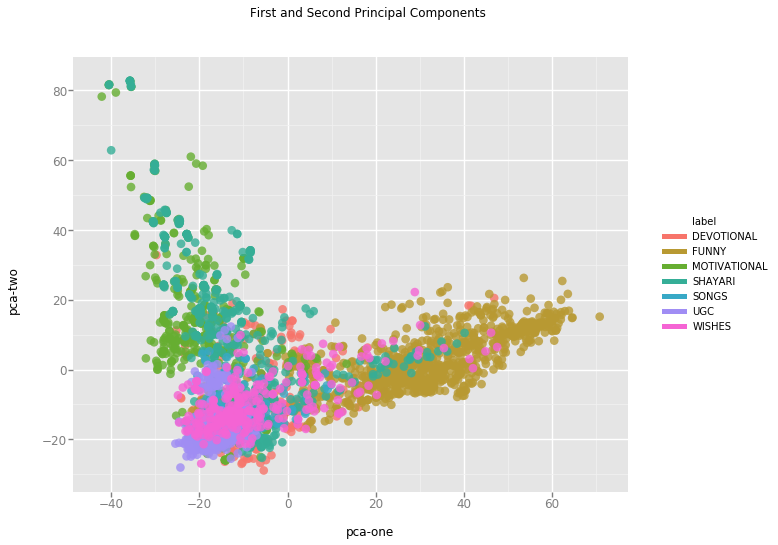

<ggplot: (-9223363301759474684)>

In [14]:
chart

## Reduce the dimension to have 90% variance

In [15]:
pca_90 = PCA(n_components=784)
pca_result_90 = pca_90.fit_transform(df[feat_cols].values)

print ('Explained variation per principal component: {}'.format(np.sum(pca_90.explained_variance_ratio_)))

Explained variation per principal component: 0.923388873507738


In [16]:
pca_result_90.shape

(19315, 784)

## attach the id , class and class id. 

In [17]:
X = pca_result_90
ids,text_labels = df.label.factorize()
Y = ids

In [18]:
n_classes = len(np.unique(Y))
input_dim = X.shape[1]

## Train a classifier to check accuracy

#### split the data

In [19]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_X, test_X, train_ids, test_ids = train_test_split(
    X, Y, test_size=0.1, random_state=0)

In [20]:
test_ids.shape

(1932,)

In [21]:
import all_classifiers as cls

###### logistic regression

In [22]:
# cls.train_and_report(train_X, train_ids,test_X,test_ids,algo_name='logistic')

## MLP

In [23]:
# cls.train_and_report(train_X, train_ids,test_X,test_ids,algo_name='mlp')

## load the data encodings and train a siamese network with triplet loss

In [41]:
import CBVR.train_triplet_v2 as tpl

In [42]:
train_X, train_ids, test_X, test_ids = tpl.reshape_and_process(train_X, train_ids, test_X, test_ids)

x_train shape: (17383, 28, 28, 1)
17383 train samples
1932 test samples
y_train shape: (17383,)


In [43]:
train_X.shape

(17383, 28, 28, 1)

In [47]:
saver, sess, global_step = tpl.train(train_X, train_ids, test_X, test_ids)




  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #:  0 global step 1   Batch #:  0 loss:  0.9997587
Epoch #:  0 global step 11   Batch #:  10 loss:  0.99986005
Epoch #:  0 global step 21   Batch #:  20 loss:  0.99997383
Epoch #:  0 global step 31   Batch #:  30 loss:  0.99996173
Epoch #:  0 global step 41   Batch #:  40 loss:  0.9999475
Epoch #:  0 global step 51   Batch #:  50 loss:  0.99990916





  0%|          | 1/500 [00:02<20:40,  2.49s/it]

Epoch #:  0 global step 61   Batch #:  60 loss:  0.9998319
Epoch #:  1 global step 68   Batch #:  0 loss:  0.99878556
Epoch #:  1 global step 78   Batch #:  10 loss:  0.9961428
Epoch #:  1 global step 88   Batch #:  20 loss:  0.9970382
Epoch #:  1 global step 98   Batch #:  30 loss:  0.9284939
Epoch #:  1 global step 108   Batch #:  40 loss:  0.9200776
Epoch #:  1 global step 118   Batch #:  50 loss:  0.6739046





  0%|          | 2/500 [00:04<18:15,  2.20s/it]

Epoch #:  1 global step 128   Batch #:  60 loss:  0.7990896
Epoch #:  2 global step 135   Batch #:  0 loss:  0.52774704
Epoch #:  2 global step 145   Batch #:  10 loss:  0.66335446
Epoch #:  2 global step 155   Batch #:  20 loss:  0.6490323
Epoch #:  2 global step 165   Batch #:  30 loss:  0.6119638
Epoch #:  2 global step 175   Batch #:  40 loss:  0.8264837
Epoch #:  2 global step 185   Batch #:  50 loss:  0.5738453





  1%|          | 3/500 [00:06<17:32,  2.12s/it]

Epoch #:  2 global step 195   Batch #:  60 loss:  0.95482963
Epoch #:  3 global step 202   Batch #:  0 loss:  0.5217387
Epoch #:  3 global step 212   Batch #:  10 loss:  0.5911489
Epoch #:  3 global step 222   Batch #:  20 loss:  0.61617315
Epoch #:  3 global step 232   Batch #:  30 loss:  0.46588472
Epoch #:  3 global step 242   Batch #:  40 loss:  0.50065404
Epoch #:  3 global step 252   Batch #:  50 loss:  0.48581505





  1%|          | 4/500 [00:08<17:19,  2.10s/it]

Epoch #:  3 global step 262   Batch #:  60 loss:  0.54952246
Epoch #:  4 global step 269   Batch #:  0 loss:  0.5216256
Epoch #:  4 global step 279   Batch #:  10 loss:  0.57121885
Epoch #:  4 global step 289   Batch #:  20 loss:  0.6078109
Epoch #:  4 global step 299   Batch #:  30 loss:  0.47512454
Epoch #:  4 global step 309   Batch #:  40 loss:  0.49709153
Epoch #:  4 global step 319   Batch #:  50 loss:  0.4873914





  1%|          | 5/500 [00:10<17:12,  2.09s/it]

Epoch #:  4 global step 329   Batch #:  60 loss:  0.52039564
Epoch #:  5 global step 336   Batch #:  0 loss:  0.5197305
Epoch #:  5 global step 346   Batch #:  10 loss:  0.5547112
Epoch #:  5 global step 356   Batch #:  20 loss:  0.59366626
Epoch #:  5 global step 366   Batch #:  30 loss:  0.47506952
Epoch #:  5 global step 376   Batch #:  40 loss:  0.54187316
Epoch #:  5 global step 386   Batch #:  50 loss:  0.47572538





  1%|          | 6/500 [00:12<17:06,  2.08s/it]

Epoch #:  5 global step 396   Batch #:  60 loss:  0.5197434
Epoch #:  6 global step 403   Batch #:  0 loss:  0.5193415
Epoch #:  6 global step 413   Batch #:  10 loss:  0.5471263
Epoch #:  6 global step 423   Batch #:  20 loss:  0.6001856
Epoch #:  6 global step 433   Batch #:  30 loss:  0.45270818
Epoch #:  6 global step 443   Batch #:  40 loss:  0.48566908
Epoch #:  6 global step 453   Batch #:  50 loss:  0.4715685





  1%|▏         | 7/500 [00:14<17:01,  2.07s/it]

Epoch #:  6 global step 463   Batch #:  60 loss:  0.51970947
Epoch #:  7 global step 470   Batch #:  0 loss:  0.51191485
Epoch #:  7 global step 480   Batch #:  10 loss:  0.52837044
Epoch #:  7 global step 490   Batch #:  20 loss:  0.58019805
Epoch #:  7 global step 500   Batch #:  30 loss:  0.43716004
Epoch #:  7 global step 510   Batch #:  40 loss:  0.4849182
Epoch #:  7 global step 520   Batch #:  50 loss:  0.47109154





  2%|▏         | 8/500 [00:16<16:58,  2.07s/it]

Epoch #:  7 global step 530   Batch #:  60 loss:  0.5190421
Epoch #:  8 global step 537   Batch #:  0 loss:  0.5110646
Epoch #:  8 global step 547   Batch #:  10 loss:  0.5358747
Epoch #:  8 global step 557   Batch #:  20 loss:  0.5900016
Epoch #:  8 global step 567   Batch #:  30 loss:  0.45906383
Epoch #:  8 global step 577   Batch #:  40 loss:  0.4838548
Epoch #:  8 global step 587   Batch #:  50 loss:  0.47649175





  2%|▏         | 9/500 [00:18<16:54,  2.07s/it]

Epoch #:  8 global step 597   Batch #:  60 loss:  0.5233982
Epoch #:  9 global step 604   Batch #:  0 loss:  0.5096474
Epoch #:  9 global step 614   Batch #:  10 loss:  0.5460147
Epoch #:  9 global step 624   Batch #:  20 loss:  0.5899862
Epoch #:  9 global step 634   Batch #:  30 loss:  0.4646322
Epoch #:  9 global step 644   Batch #:  40 loss:  0.4973222
Epoch #:  9 global step 654   Batch #:  50 loss:  0.47004604





  2%|▏         | 10/500 [00:20<16:50,  2.06s/it]

Epoch #:  9 global step 664   Batch #:  60 loss:  0.52027357
Epoch #:  10 global step 671   Batch #:  0 loss:  0.5294874
Epoch #:  10 global step 681   Batch #:  10 loss:  0.5433142
Epoch #:  10 global step 691   Batch #:  20 loss:  0.6038304
Epoch #:  10 global step 701   Batch #:  30 loss:  0.44840607
Epoch #:  10 global step 711   Batch #:  40 loss:  0.4913712
Epoch #:  10 global step 721   Batch #:  50 loss:  0.47187543





  2%|▏         | 11/500 [00:22<16:47,  2.06s/it]

Epoch #:  10 global step 731   Batch #:  60 loss:  0.51813847
Epoch #:  11 global step 738   Batch #:  0 loss:  0.50513947
Epoch #:  11 global step 748   Batch #:  10 loss:  0.5251727
Epoch #:  11 global step 758   Batch #:  20 loss:  0.57379955
Epoch #:  11 global step 768   Batch #:  30 loss:  0.43503064
Epoch #:  11 global step 778   Batch #:  40 loss:  0.47865668
Epoch #:  11 global step 788   Batch #:  50 loss:  0.49914962





  2%|▏         | 12/500 [00:24<16:44,  2.06s/it]

Epoch #:  11 global step 798   Batch #:  60 loss:  0.5164109
Epoch #:  12 global step 805   Batch #:  0 loss:  0.5076544
Epoch #:  12 global step 815   Batch #:  10 loss:  0.52983826
Epoch #:  12 global step 825   Batch #:  20 loss:  0.56961775
Epoch #:  12 global step 835   Batch #:  30 loss:  0.4867155
Epoch #:  12 global step 845   Batch #:  40 loss:  0.49731138
Epoch #:  12 global step 855   Batch #:  50 loss:  0.47070128





  3%|▎         | 13/500 [00:26<16:42,  2.06s/it]

Epoch #:  12 global step 865   Batch #:  60 loss:  0.5159131
Epoch #:  13 global step 872   Batch #:  0 loss:  0.5068168
Epoch #:  13 global step 882   Batch #:  10 loss:  0.5253678
Epoch #:  13 global step 892   Batch #:  20 loss:  0.5757267
Epoch #:  13 global step 902   Batch #:  30 loss:  0.42856267
Epoch #:  13 global step 912   Batch #:  40 loss:  0.46968418
Epoch #:  13 global step 922   Batch #:  50 loss:  0.46187377





  3%|▎         | 14/500 [00:28<16:40,  2.06s/it]

Epoch #:  13 global step 932   Batch #:  60 loss:  0.51196116
Epoch #:  14 global step 939   Batch #:  0 loss:  0.49376702
Epoch #:  14 global step 949   Batch #:  10 loss:  0.51052016
Epoch #:  14 global step 959   Batch #:  20 loss:  0.5699501
Epoch #:  14 global step 969   Batch #:  30 loss:  0.42247382
Epoch #:  14 global step 979   Batch #:  40 loss:  0.46403363
Epoch #:  14 global step 989   Batch #:  50 loss:  0.5359899





  3%|▎         | 15/500 [00:30<16:37,  2.06s/it]

Epoch #:  14 global step 999   Batch #:  60 loss:  0.51594955
Epoch #:  15 global step 1006   Batch #:  0 loss:  0.5012647
Epoch #:  15 global step 1016   Batch #:  10 loss:  0.523792
Epoch #:  15 global step 1026   Batch #:  20 loss:  0.6151781
Epoch #:  15 global step 1036   Batch #:  30 loss:  0.4517575
Epoch #:  15 global step 1046   Batch #:  40 loss:  0.46715754
Epoch #:  15 global step 1056   Batch #:  50 loss:  0.47636375





  3%|▎         | 16/500 [00:32<16:34,  2.06s/it]

Epoch #:  15 global step 1066   Batch #:  60 loss:  0.5095817
Epoch #:  16 global step 1073   Batch #:  0 loss:  0.491535
Epoch #:  16 global step 1083   Batch #:  10 loss:  0.51430094
Epoch #:  16 global step 1093   Batch #:  20 loss:  0.5707067
Epoch #:  16 global step 1103   Batch #:  30 loss:  0.4469942
Epoch #:  16 global step 1113   Batch #:  40 loss:  0.4567101
Epoch #:  16 global step 1123   Batch #:  50 loss:  0.43978474





  3%|▎         | 17/500 [00:34<16:32,  2.05s/it]

Epoch #:  16 global step 1133   Batch #:  60 loss:  0.51642483
Epoch #:  17 global step 1140   Batch #:  0 loss:  0.48137474
Epoch #:  17 global step 1150   Batch #:  10 loss:  0.5136504
Epoch #:  17 global step 1160   Batch #:  20 loss:  0.58732814
Epoch #:  17 global step 1170   Batch #:  30 loss:  0.43207258
Epoch #:  17 global step 1180   Batch #:  40 loss:  0.44600067
Epoch #:  17 global step 1190   Batch #:  50 loss:  0.42833295





  4%|▎         | 18/500 [00:36<16:29,  2.05s/it]

Epoch #:  17 global step 1200   Batch #:  60 loss:  0.52505195
Epoch #:  18 global step 1207   Batch #:  0 loss:  0.49005854
Epoch #:  18 global step 1217   Batch #:  10 loss:  0.506535
Epoch #:  18 global step 1227   Batch #:  20 loss:  0.54178053
Epoch #:  18 global step 1237   Batch #:  30 loss:  0.34711993
Epoch #:  18 global step 1247   Batch #:  40 loss:  0.40677387
Epoch #:  18 global step 1257   Batch #:  50 loss:  0.38250282





  4%|▍         | 19/500 [00:39<16:27,  2.05s/it]

Epoch #:  18 global step 1267   Batch #:  60 loss:  0.47029877
Epoch #:  19 global step 1274   Batch #:  0 loss:  0.4167009
Epoch #:  19 global step 1284   Batch #:  10 loss:  0.45404842
Epoch #:  19 global step 1294   Batch #:  20 loss:  0.5209878
Epoch #:  19 global step 1304   Batch #:  30 loss:  0.35541192
Epoch #:  19 global step 1314   Batch #:  40 loss:  0.38029888
Epoch #:  19 global step 1324   Batch #:  50 loss:  0.36328077





  4%|▍         | 20/500 [00:41<16:25,  2.05s/it]

Epoch #:  19 global step 1334   Batch #:  60 loss:  0.4335905
Epoch #:  20 global step 1341   Batch #:  0 loss:  0.40610453
Epoch #:  20 global step 1351   Batch #:  10 loss:  0.5030876
Epoch #:  20 global step 1361   Batch #:  20 loss:  0.5309735
Epoch #:  20 global step 1371   Batch #:  30 loss:  0.41514274
Epoch #:  20 global step 1381   Batch #:  40 loss:  0.36582905
Epoch #:  20 global step 1391   Batch #:  50 loss:  0.3547749





  4%|▍         | 21/500 [00:43<16:22,  2.05s/it]

Epoch #:  20 global step 1401   Batch #:  60 loss:  0.45451504
Epoch #:  21 global step 1408   Batch #:  0 loss:  0.47898266
Epoch #:  21 global step 1418   Batch #:  10 loss:  0.4991209
Epoch #:  21 global step 1428   Batch #:  20 loss:  0.4817934
Epoch #:  21 global step 1438   Batch #:  30 loss:  0.4829074
Epoch #:  21 global step 1448   Batch #:  40 loss:  0.41407594
Epoch #:  21 global step 1458   Batch #:  50 loss:  0.35572538





  4%|▍         | 22/500 [00:45<16:20,  2.05s/it]

Epoch #:  21 global step 1468   Batch #:  60 loss:  0.49366376
Epoch #:  22 global step 1475   Batch #:  0 loss:  0.3977769
Epoch #:  22 global step 1485   Batch #:  10 loss:  0.4625154
Epoch #:  22 global step 1495   Batch #:  20 loss:  0.50196624
Epoch #:  22 global step 1505   Batch #:  30 loss:  0.38788438
Epoch #:  22 global step 1515   Batch #:  40 loss:  0.34184927
Epoch #:  22 global step 1525   Batch #:  50 loss:  0.35043195





  5%|▍         | 23/500 [00:47<16:17,  2.05s/it]

Epoch #:  22 global step 1535   Batch #:  60 loss:  0.4254116
Epoch #:  23 global step 1542   Batch #:  0 loss:  0.36132902
Epoch #:  23 global step 1552   Batch #:  10 loss:  0.4505716
Epoch #:  23 global step 1562   Batch #:  20 loss:  0.4432423
Epoch #:  23 global step 1572   Batch #:  30 loss:  0.40178838
Epoch #:  23 global step 1582   Batch #:  40 loss:  0.28052163
Epoch #:  23 global step 1592   Batch #:  50 loss:  0.3706586





  5%|▍         | 24/500 [00:49<16:15,  2.05s/it]

Epoch #:  23 global step 1602   Batch #:  60 loss:  0.42759788
Epoch #:  24 global step 1609   Batch #:  0 loss:  0.3648207
Epoch #:  24 global step 1619   Batch #:  10 loss:  0.46151313
Epoch #:  24 global step 1629   Batch #:  20 loss:  0.42963248
Epoch #:  24 global step 1639   Batch #:  30 loss:  0.3197235
Epoch #:  24 global step 1649   Batch #:  40 loss:  0.24934593
Epoch #:  24 global step 1659   Batch #:  50 loss:  0.30429858





  5%|▌         | 25/500 [00:51<16:13,  2.05s/it]

Epoch #:  24 global step 1669   Batch #:  60 loss:  0.41713998
Epoch #:  25 global step 1676   Batch #:  0 loss:  0.45202604
Epoch #:  25 global step 1686   Batch #:  10 loss:  0.49035642
Epoch #:  25 global step 1696   Batch #:  20 loss:  0.49713996
Epoch #:  25 global step 1706   Batch #:  30 loss:  0.33243048
Epoch #:  25 global step 1716   Batch #:  40 loss:  0.29253063
Epoch #:  25 global step 1726   Batch #:  50 loss:  0.33909544





  5%|▌         | 26/500 [00:53<16:11,  2.05s/it]

Epoch #:  25 global step 1736   Batch #:  60 loss:  0.38488862
Epoch #:  26 global step 1743   Batch #:  0 loss:  0.48832664
Epoch #:  26 global step 1753   Batch #:  10 loss:  0.41998866
Epoch #:  26 global step 1763   Batch #:  20 loss:  0.4311371
Epoch #:  26 global step 1773   Batch #:  30 loss:  0.32490125
Epoch #:  26 global step 1783   Batch #:  40 loss:  0.33124933
Epoch #:  26 global step 1793   Batch #:  50 loss:  0.3067824





  5%|▌         | 27/500 [00:55<16:08,  2.05s/it]

Epoch #:  26 global step 1803   Batch #:  60 loss:  0.38629672
Epoch #:  27 global step 1810   Batch #:  0 loss:  0.33774456
Epoch #:  27 global step 1820   Batch #:  10 loss:  0.38713378
Epoch #:  27 global step 1830   Batch #:  20 loss:  0.44413975
Epoch #:  27 global step 1840   Batch #:  30 loss:  0.3456943
Epoch #:  27 global step 1850   Batch #:  40 loss:  0.32902235
Epoch #:  27 global step 1860   Batch #:  50 loss:  0.31941506





  6%|▌         | 28/500 [00:57<16:06,  2.05s/it]

Epoch #:  27 global step 1870   Batch #:  60 loss:  0.37686437
Epoch #:  28 global step 1877   Batch #:  0 loss:  0.2971904
Epoch #:  28 global step 1887   Batch #:  10 loss:  0.3323705
Epoch #:  28 global step 1897   Batch #:  20 loss:  0.3933149
Epoch #:  28 global step 1907   Batch #:  30 loss:  0.32031465
Epoch #:  28 global step 1917   Batch #:  40 loss:  0.2828832
Epoch #:  28 global step 1927   Batch #:  50 loss:  0.2914054





  6%|▌         | 29/500 [00:59<16:04,  2.05s/it]

Epoch #:  28 global step 1937   Batch #:  60 loss:  0.35374373
Epoch #:  29 global step 1944   Batch #:  0 loss:  0.384464
Epoch #:  29 global step 1954   Batch #:  10 loss:  0.33397928
Epoch #:  29 global step 1964   Batch #:  20 loss:  0.57405406
Epoch #:  29 global step 1974   Batch #:  30 loss:  0.3369489
Epoch #:  29 global step 1984   Batch #:  40 loss:  0.35829303
Epoch #:  29 global step 1994   Batch #:  50 loss:  0.31092703





  6%|▌         | 30/500 [01:01<16:02,  2.05s/it]

Epoch #:  29 global step 2004   Batch #:  60 loss:  0.33569527
Epoch #:  30 global step 2011   Batch #:  0 loss:  0.331381
Epoch #:  30 global step 2021   Batch #:  10 loss:  0.4122416
Epoch #:  30 global step 2031   Batch #:  20 loss:  0.416642
Epoch #:  30 global step 2041   Batch #:  30 loss:  0.3122468
Epoch #:  30 global step 2051   Batch #:  40 loss:  0.31870022
Epoch #:  30 global step 2061   Batch #:  50 loss:  0.27765608





  6%|▌         | 31/500 [01:03<16:00,  2.05s/it]

Epoch #:  30 global step 2071   Batch #:  60 loss:  0.33672312
Epoch #:  31 global step 2078   Batch #:  0 loss:  0.28443125
Epoch #:  31 global step 2088   Batch #:  10 loss:  0.3188561
Epoch #:  31 global step 2098   Batch #:  20 loss:  0.4153188
Epoch #:  31 global step 2108   Batch #:  30 loss:  0.28247556
Epoch #:  31 global step 2118   Batch #:  40 loss:  0.23405203
Epoch #:  31 global step 2128   Batch #:  50 loss:  0.2677037





  6%|▋         | 32/500 [01:05<15:58,  2.05s/it]

Epoch #:  31 global step 2138   Batch #:  60 loss:  0.32305816
Epoch #:  32 global step 2145   Batch #:  0 loss:  0.27485752
Epoch #:  32 global step 2155   Batch #:  10 loss:  0.2749761
Epoch #:  32 global step 2165   Batch #:  20 loss:  0.39558387
Epoch #:  32 global step 2175   Batch #:  30 loss:  0.27972248
Epoch #:  32 global step 2185   Batch #:  40 loss:  0.23161505
Epoch #:  32 global step 2195   Batch #:  50 loss:  0.2690942





  7%|▋         | 33/500 [01:07<15:56,  2.05s/it]

Epoch #:  32 global step 2205   Batch #:  60 loss:  0.3200447
Epoch #:  33 global step 2212   Batch #:  0 loss:  0.2656793
Epoch #:  33 global step 2222   Batch #:  10 loss:  0.30229756
Epoch #:  33 global step 2232   Batch #:  20 loss:  0.4150471
Epoch #:  33 global step 2242   Batch #:  30 loss:  0.28744635
Epoch #:  33 global step 2252   Batch #:  40 loss:  0.230815
Epoch #:  33 global step 2262   Batch #:  50 loss:  0.2674156





  7%|▋         | 34/500 [01:09<15:54,  2.05s/it]

Epoch #:  33 global step 2272   Batch #:  60 loss:  0.31249067
Epoch #:  34 global step 2279   Batch #:  0 loss:  0.2570016
Epoch #:  34 global step 2289   Batch #:  10 loss:  0.2797979
Epoch #:  34 global step 2299   Batch #:  20 loss:  0.39697647
Epoch #:  34 global step 2309   Batch #:  30 loss:  0.27180064
Epoch #:  34 global step 2319   Batch #:  40 loss:  0.22959259
Epoch #:  34 global step 2329   Batch #:  50 loss:  0.28529474





  7%|▋         | 35/500 [01:11<15:52,  2.05s/it]

Epoch #:  34 global step 2339   Batch #:  60 loss:  0.32984197
Epoch #:  35 global step 2346   Batch #:  0 loss:  0.28042892
Epoch #:  35 global step 2356   Batch #:  10 loss:  0.3303385
Epoch #:  35 global step 2366   Batch #:  20 loss:  0.42009676
Epoch #:  35 global step 2376   Batch #:  30 loss:  0.31119418
Epoch #:  35 global step 2386   Batch #:  40 loss:  0.23629192
Epoch #:  35 global step 2396   Batch #:  50 loss:  0.31391233





  7%|▋         | 36/500 [01:13<15:50,  2.05s/it]

Epoch #:  35 global step 2406   Batch #:  60 loss:  0.3243681
Epoch #:  36 global step 2413   Batch #:  0 loss:  0.2575179
Epoch #:  36 global step 2423   Batch #:  10 loss:  0.38460028
Epoch #:  36 global step 2433   Batch #:  20 loss:  0.53414184
Epoch #:  36 global step 2443   Batch #:  30 loss:  0.30601582
Epoch #:  36 global step 2453   Batch #:  40 loss:  0.2720266
Epoch #:  36 global step 2463   Batch #:  50 loss:  0.3369727





  7%|▋         | 37/500 [01:15<15:47,  2.05s/it]

Epoch #:  36 global step 2473   Batch #:  60 loss:  0.44106072
Epoch #:  37 global step 2480   Batch #:  0 loss:  0.36233607
Epoch #:  37 global step 2490   Batch #:  10 loss:  0.3164453
Epoch #:  37 global step 2500   Batch #:  20 loss:  0.39798275
Epoch #:  37 global step 2510   Batch #:  30 loss:  0.31132668
Epoch #:  37 global step 2520   Batch #:  40 loss:  0.45389348
Epoch #:  37 global step 2530   Batch #:  50 loss:  0.30444014





  8%|▊         | 38/500 [01:17<15:45,  2.05s/it]

Epoch #:  37 global step 2540   Batch #:  60 loss:  0.33318308
Epoch #:  38 global step 2547   Batch #:  0 loss:  0.29239026
Epoch #:  38 global step 2557   Batch #:  10 loss:  0.41073215
Epoch #:  38 global step 2567   Batch #:  20 loss:  0.37792796
Epoch #:  38 global step 2577   Batch #:  30 loss:  0.31722707
Epoch #:  38 global step 2587   Batch #:  40 loss:  0.29615292
Epoch #:  38 global step 2597   Batch #:  50 loss:  0.3260411





  8%|▊         | 39/500 [01:19<15:43,  2.05s/it]

Epoch #:  38 global step 2607   Batch #:  60 loss:  0.26902533
Epoch #:  39 global step 2614   Batch #:  0 loss:  0.26384813
Epoch #:  39 global step 2624   Batch #:  10 loss:  0.34178713
Epoch #:  39 global step 2634   Batch #:  20 loss:  0.35807657
Epoch #:  39 global step 2644   Batch #:  30 loss:  0.24364933
Epoch #:  39 global step 2654   Batch #:  40 loss:  0.22816506
Epoch #:  39 global step 2664   Batch #:  50 loss:  0.2449504





  8%|▊         | 40/500 [01:21<15:41,  2.05s/it]

Epoch #:  39 global step 2674   Batch #:  60 loss:  0.22993553
Epoch #:  40 global step 2681   Batch #:  0 loss:  0.23629327
Epoch #:  40 global step 2691   Batch #:  10 loss:  0.20567541
Epoch #:  40 global step 2701   Batch #:  20 loss:  0.32088572
Epoch #:  40 global step 2711   Batch #:  30 loss:  0.25431737
Epoch #:  40 global step 2721   Batch #:  40 loss:  0.22105986
Epoch #:  40 global step 2731   Batch #:  50 loss:  0.40051666





  8%|▊         | 41/500 [01:23<15:39,  2.05s/it]

Epoch #:  40 global step 2741   Batch #:  60 loss:  0.26516122
Epoch #:  41 global step 2748   Batch #:  0 loss:  0.21911326
Epoch #:  41 global step 2758   Batch #:  10 loss:  0.21890126
Epoch #:  41 global step 2768   Batch #:  20 loss:  0.3045263
Epoch #:  41 global step 2778   Batch #:  30 loss:  0.22857897
Epoch #:  41 global step 2788   Batch #:  40 loss:  0.20660889
Epoch #:  41 global step 2798   Batch #:  50 loss:  0.23659715





  8%|▊         | 42/500 [01:25<15:37,  2.05s/it]

Epoch #:  41 global step 2808   Batch #:  60 loss:  0.2428447
Epoch #:  42 global step 2815   Batch #:  0 loss:  0.21494302
Epoch #:  42 global step 2825   Batch #:  10 loss:  0.18916127
Epoch #:  42 global step 2835   Batch #:  20 loss:  0.31089756
Epoch #:  42 global step 2845   Batch #:  30 loss:  0.22074312
Epoch #:  42 global step 2855   Batch #:  40 loss:  0.21988393
Epoch #:  42 global step 2865   Batch #:  50 loss:  0.2516419





  9%|▊         | 43/500 [01:27<15:35,  2.05s/it]

Epoch #:  42 global step 2875   Batch #:  60 loss:  0.23178054
Epoch #:  43 global step 2882   Batch #:  0 loss:  0.21182753
Epoch #:  43 global step 2892   Batch #:  10 loss:  0.20977703
Epoch #:  43 global step 2902   Batch #:  20 loss:  0.32632563
Epoch #:  43 global step 2912   Batch #:  30 loss:  0.24464568
Epoch #:  43 global step 2922   Batch #:  40 loss:  0.21625315
Epoch #:  43 global step 2932   Batch #:  50 loss:  0.23944975





  9%|▉         | 44/500 [01:30<15:32,  2.05s/it]

Epoch #:  43 global step 2942   Batch #:  60 loss:  0.22194272
Epoch #:  44 global step 2949   Batch #:  0 loss:  0.20480964
Epoch #:  44 global step 2959   Batch #:  10 loss:  0.18321922
Epoch #:  44 global step 2969   Batch #:  20 loss:  0.2644775
Epoch #:  44 global step 2979   Batch #:  30 loss:  0.21249487
Epoch #:  44 global step 2989   Batch #:  40 loss:  0.19501206
Epoch #:  44 global step 2999   Batch #:  50 loss:  0.2476132





  9%|▉         | 45/500 [01:32<15:30,  2.05s/it]

Epoch #:  44 global step 3009   Batch #:  60 loss:  0.21334204
Epoch #:  45 global step 3016   Batch #:  0 loss:  0.20106459
Epoch #:  45 global step 3026   Batch #:  10 loss:  0.17406076
Epoch #:  45 global step 3036   Batch #:  20 loss:  0.27039006
Epoch #:  45 global step 3046   Batch #:  30 loss:  0.21030131
Epoch #:  45 global step 3056   Batch #:  40 loss:  0.19737145
Epoch #:  45 global step 3066   Batch #:  50 loss:  0.23393491





  9%|▉         | 46/500 [01:34<15:28,  2.05s/it]

Epoch #:  45 global step 3076   Batch #:  60 loss:  0.20759867
Epoch #:  46 global step 3083   Batch #:  0 loss:  0.19914825
Epoch #:  46 global step 3093   Batch #:  10 loss:  0.20350373
Epoch #:  46 global step 3103   Batch #:  20 loss:  0.26157686
Epoch #:  46 global step 3113   Batch #:  30 loss:  0.20889518
Epoch #:  46 global step 3123   Batch #:  40 loss:  0.19326916
Epoch #:  46 global step 3133   Batch #:  50 loss:  0.23191187





  9%|▉         | 47/500 [01:36<15:26,  2.05s/it]

Epoch #:  46 global step 3143   Batch #:  60 loss:  0.20985371
Epoch #:  47 global step 3150   Batch #:  0 loss:  0.1956153
Epoch #:  47 global step 3160   Batch #:  10 loss:  0.16584806
Epoch #:  47 global step 3170   Batch #:  20 loss:  0.27348614
Epoch #:  47 global step 3180   Batch #:  30 loss:  0.22906332
Epoch #:  47 global step 3190   Batch #:  40 loss:  0.18933187
Epoch #:  47 global step 3200   Batch #:  50 loss:  0.24127871





 10%|▉         | 48/500 [01:38<15:24,  2.05s/it]

Epoch #:  47 global step 3210   Batch #:  60 loss:  0.21920876
Epoch #:  48 global step 3217   Batch #:  0 loss:  0.20751433
Epoch #:  48 global step 3227   Batch #:  10 loss:  0.17482798
Epoch #:  48 global step 3237   Batch #:  20 loss:  0.31091005
Epoch #:  48 global step 3247   Batch #:  30 loss:  0.2191306
Epoch #:  48 global step 3257   Batch #:  40 loss:  0.20086743
Epoch #:  48 global step 3267   Batch #:  50 loss:  0.23785394





 10%|▉         | 49/500 [01:40<15:22,  2.05s/it]

Epoch #:  48 global step 3277   Batch #:  60 loss:  0.22315277
Epoch #:  49 global step 3284   Batch #:  0 loss:  0.21444397
Epoch #:  49 global step 3294   Batch #:  10 loss:  0.1945753
Epoch #:  49 global step 3304   Batch #:  20 loss:  0.27457792
Epoch #:  49 global step 3314   Batch #:  30 loss:  0.22409286
Epoch #:  49 global step 3324   Batch #:  40 loss:  0.20484
Epoch #:  49 global step 3334   Batch #:  50 loss:  0.24257034





 10%|█         | 50/500 [01:42<15:20,  2.04s/it]

Epoch #:  49 global step 3344   Batch #:  60 loss:  0.25992265
Epoch #:  50 global step 3351   Batch #:  0 loss:  0.21125422
Epoch #:  50 global step 3361   Batch #:  10 loss:  0.287403
Epoch #:  50 global step 3371   Batch #:  20 loss:  0.35052782
Epoch #:  50 global step 3381   Batch #:  30 loss:  0.28089267
Epoch #:  50 global step 3391   Batch #:  40 loss:  0.22030021
Epoch #:  50 global step 3401   Batch #:  50 loss:  0.24082775





 10%|█         | 51/500 [01:44<15:18,  2.04s/it]

Epoch #:  50 global step 3411   Batch #:  60 loss:  0.21911524
Epoch #:  51 global step 3418   Batch #:  0 loss:  0.20621638
Epoch #:  51 global step 3428   Batch #:  10 loss:  0.16200271
Epoch #:  51 global step 3438   Batch #:  20 loss:  0.30715203
Epoch #:  51 global step 3448   Batch #:  30 loss:  0.21263826
Epoch #:  51 global step 3458   Batch #:  40 loss:  0.19316748
Epoch #:  51 global step 3468   Batch #:  50 loss:  0.2301327





 10%|█         | 52/500 [01:46<15:16,  2.04s/it]

Epoch #:  51 global step 3478   Batch #:  60 loss:  0.21487468
Epoch #:  52 global step 3485   Batch #:  0 loss:  0.19887954
Epoch #:  52 global step 3495   Batch #:  10 loss:  0.13900356
Epoch #:  52 global step 3505   Batch #:  20 loss:  0.25611225
Epoch #:  52 global step 3515   Batch #:  30 loss:  0.28734085
Epoch #:  52 global step 3525   Batch #:  40 loss:  0.23989356
Epoch #:  52 global step 3535   Batch #:  50 loss:  0.23173788





 11%|█         | 53/500 [01:48<15:13,  2.04s/it]

Epoch #:  52 global step 3545   Batch #:  60 loss:  0.21160263
Epoch #:  53 global step 3552   Batch #:  0 loss:  0.20194344
Epoch #:  53 global step 3562   Batch #:  10 loss:  0.21050438
Epoch #:  53 global step 3572   Batch #:  20 loss:  0.25831026
Epoch #:  53 global step 3582   Batch #:  30 loss:  0.22458263
Epoch #:  53 global step 3592   Batch #:  40 loss:  0.1987219
Epoch #:  53 global step 3602   Batch #:  50 loss:  0.22921668





 11%|█         | 54/500 [01:50<15:11,  2.04s/it]

Epoch #:  53 global step 3612   Batch #:  60 loss:  0.2092148
Epoch #:  54 global step 3619   Batch #:  0 loss:  0.19058402
Epoch #:  54 global step 3629   Batch #:  10 loss:  0.18222909
Epoch #:  54 global step 3639   Batch #:  20 loss:  0.26479444
Epoch #:  54 global step 3649   Batch #:  30 loss:  0.23166926
Epoch #:  54 global step 3659   Batch #:  40 loss:  0.19570751
Epoch #:  54 global step 3669   Batch #:  50 loss:  0.2420661





 11%|█         | 55/500 [01:52<15:09,  2.04s/it]

Epoch #:  54 global step 3679   Batch #:  60 loss:  0.21244168
Epoch #:  55 global step 3686   Batch #:  0 loss:  0.24305612
Epoch #:  55 global step 3696   Batch #:  10 loss:  0.16298687
Epoch #:  55 global step 3706   Batch #:  20 loss:  0.28162634
Epoch #:  55 global step 3716   Batch #:  30 loss:  0.20900343
Epoch #:  55 global step 3726   Batch #:  40 loss:  0.19973196
Epoch #:  55 global step 3736   Batch #:  50 loss:  0.24236575





 11%|█         | 56/500 [01:54<15:07,  2.04s/it]

Epoch #:  55 global step 3746   Batch #:  60 loss:  0.20352705
Epoch #:  56 global step 3753   Batch #:  0 loss:  0.22251794
Epoch #:  56 global step 3763   Batch #:  10 loss:  0.1669889
Epoch #:  56 global step 3773   Batch #:  20 loss:  0.28114098
Epoch #:  56 global step 3783   Batch #:  30 loss:  0.22733195
Epoch #:  56 global step 3793   Batch #:  40 loss:  0.20419697
Epoch #:  56 global step 3803   Batch #:  50 loss:  0.23510589





 11%|█▏        | 57/500 [01:56<15:05,  2.04s/it]

Epoch #:  56 global step 3813   Batch #:  60 loss:  0.20686631
Epoch #:  57 global step 3820   Batch #:  0 loss:  0.19707136
Epoch #:  57 global step 3830   Batch #:  10 loss:  0.19487923
Epoch #:  57 global step 3840   Batch #:  20 loss:  0.2683537
Epoch #:  57 global step 3850   Batch #:  30 loss:  0.22453442
Epoch #:  57 global step 3860   Batch #:  40 loss:  0.19793592
Epoch #:  57 global step 3870   Batch #:  50 loss:  0.23340759





 12%|█▏        | 58/500 [01:58<15:03,  2.04s/it]

Epoch #:  57 global step 3880   Batch #:  60 loss:  0.21671523
Epoch #:  58 global step 3887   Batch #:  0 loss:  0.19428521
Epoch #:  58 global step 3897   Batch #:  10 loss:  0.15668602
Epoch #:  58 global step 3907   Batch #:  20 loss:  0.25478935
Epoch #:  58 global step 3917   Batch #:  30 loss:  0.20309891
Epoch #:  58 global step 3927   Batch #:  40 loss:  0.18793795
Epoch #:  58 global step 3937   Batch #:  50 loss:  0.22726822





 12%|█▏        | 59/500 [02:00<15:01,  2.04s/it]

Epoch #:  58 global step 3947   Batch #:  60 loss:  0.20655613
Epoch #:  59 global step 3954   Batch #:  0 loss:  0.19284827
Epoch #:  59 global step 3964   Batch #:  10 loss:  0.15635034
Epoch #:  59 global step 3974   Batch #:  20 loss:  0.23156196
Epoch #:  59 global step 3984   Batch #:  30 loss:  0.1826575
Epoch #:  59 global step 3994   Batch #:  40 loss:  0.18207842
Epoch #:  59 global step 4004   Batch #:  50 loss:  0.21186955





 12%|█▏        | 60/500 [02:02<14:59,  2.04s/it]

Epoch #:  59 global step 4014   Batch #:  60 loss:  0.19771782
Epoch #:  60 global step 4021   Batch #:  0 loss:  0.21382828
Epoch #:  60 global step 4031   Batch #:  10 loss:  0.17032333
Epoch #:  60 global step 4041   Batch #:  20 loss:  0.24612667
Epoch #:  60 global step 4051   Batch #:  30 loss:  0.19548337
Epoch #:  60 global step 4061   Batch #:  40 loss:  0.18884934
Epoch #:  60 global step 4071   Batch #:  50 loss:  0.28114083





 12%|█▏        | 61/500 [02:04<14:57,  2.04s/it]

Epoch #:  60 global step 4081   Batch #:  60 loss:  0.22815967
Epoch #:  61 global step 4088   Batch #:  0 loss:  0.20058876
Epoch #:  61 global step 4098   Batch #:  10 loss:  0.39433
Epoch #:  61 global step 4108   Batch #:  20 loss:  0.2930477
Epoch #:  61 global step 4118   Batch #:  30 loss:  0.21226047
Epoch #:  61 global step 4128   Batch #:  40 loss:  0.20839497
Epoch #:  61 global step 4138   Batch #:  50 loss:  0.23196168





 12%|█▏        | 62/500 [02:06<14:55,  2.04s/it]

Epoch #:  61 global step 4148   Batch #:  60 loss:  0.23589955
Epoch #:  62 global step 4155   Batch #:  0 loss:  0.23933357
Epoch #:  62 global step 4165   Batch #:  10 loss:  0.21231951
Epoch #:  62 global step 4175   Batch #:  20 loss:  0.263289
Epoch #:  62 global step 4185   Batch #:  30 loss:  0.22152522
Epoch #:  62 global step 4195   Batch #:  40 loss:  0.20213242
Epoch #:  62 global step 4205   Batch #:  50 loss:  0.228516





 13%|█▎        | 63/500 [02:08<14:53,  2.04s/it]

Epoch #:  62 global step 4215   Batch #:  60 loss:  0.2099356
Epoch #:  63 global step 4222   Batch #:  0 loss:  0.21730714
Epoch #:  63 global step 4232   Batch #:  10 loss:  0.22507867
Epoch #:  63 global step 4242   Batch #:  20 loss:  0.23272136
Epoch #:  63 global step 4252   Batch #:  30 loss:  0.19338593
Epoch #:  63 global step 4262   Batch #:  40 loss:  0.19174007
Epoch #:  63 global step 4272   Batch #:  50 loss:  0.22743678





 13%|█▎        | 64/500 [02:10<14:50,  2.04s/it]

Epoch #:  63 global step 4282   Batch #:  60 loss:  0.20389098
Epoch #:  64 global step 4289   Batch #:  0 loss:  0.17984192
Epoch #:  64 global step 4299   Batch #:  10 loss:  0.15258211
Epoch #:  64 global step 4309   Batch #:  20 loss:  0.21676698
Epoch #:  64 global step 4319   Batch #:  30 loss:  0.15244696
Epoch #:  64 global step 4329   Batch #:  40 loss:  0.18018475
Epoch #:  64 global step 4339   Batch #:  50 loss:  0.19956271





 13%|█▎        | 65/500 [02:12<14:48,  2.04s/it]

Epoch #:  64 global step 4349   Batch #:  60 loss:  0.19670261
Epoch #:  65 global step 4356   Batch #:  0 loss:  0.2567856
Epoch #:  65 global step 4366   Batch #:  10 loss:  0.20754935
Epoch #:  65 global step 4376   Batch #:  20 loss:  0.22231162
Epoch #:  65 global step 4386   Batch #:  30 loss:  0.16790849
Epoch #:  65 global step 4396   Batch #:  40 loss:  0.19470191
Epoch #:  65 global step 4406   Batch #:  50 loss:  0.20539017





 13%|█▎        | 66/500 [02:14<14:46,  2.04s/it]

Epoch #:  65 global step 4416   Batch #:  60 loss:  0.19403434
Epoch #:  66 global step 4423   Batch #:  0 loss:  0.12820537
Epoch #:  66 global step 4433   Batch #:  10 loss:  0.13822185
Epoch #:  66 global step 4443   Batch #:  20 loss:  0.19759844
Epoch #:  66 global step 4453   Batch #:  30 loss:  0.09728467
Epoch #:  66 global step 4463   Batch #:  40 loss:  0.17764293
Epoch #:  66 global step 4473   Batch #:  50 loss:  0.19576812





 13%|█▎        | 67/500 [02:16<14:44,  2.04s/it]

Epoch #:  66 global step 4483   Batch #:  60 loss:  0.15515697
Epoch #:  67 global step 4490   Batch #:  0 loss:  0.114824235
Epoch #:  67 global step 4500   Batch #:  10 loss:  0.1481739
Epoch #:  67 global step 4510   Batch #:  20 loss:  0.26147458
Epoch #:  67 global step 4520   Batch #:  30 loss:  0.18778345
Epoch #:  67 global step 4530   Batch #:  40 loss:  0.20182933
Epoch #:  67 global step 4540   Batch #:  50 loss:  0.19378923





 14%|█▎        | 68/500 [02:18<14:42,  2.04s/it]

Epoch #:  67 global step 4550   Batch #:  60 loss:  0.16822493
Epoch #:  68 global step 4557   Batch #:  0 loss:  0.13702703
Epoch #:  68 global step 4567   Batch #:  10 loss:  0.13882665
Epoch #:  68 global step 4577   Batch #:  20 loss:  0.21162201
Epoch #:  68 global step 4587   Batch #:  30 loss:  0.091482215
Epoch #:  68 global step 4597   Batch #:  40 loss:  0.16112942
Epoch #:  68 global step 4607   Batch #:  50 loss:  0.18104675





 14%|█▍        | 69/500 [02:20<14:40,  2.04s/it]

Epoch #:  68 global step 4617   Batch #:  60 loss:  0.17461668
Epoch #:  69 global step 4624   Batch #:  0 loss:  0.10484781
Epoch #:  69 global step 4634   Batch #:  10 loss:  0.17249773
Epoch #:  69 global step 4644   Batch #:  20 loss:  0.17987563
Epoch #:  69 global step 4654   Batch #:  30 loss:  0.25058892
Epoch #:  69 global step 4664   Batch #:  40 loss:  0.21182786
Epoch #:  69 global step 4674   Batch #:  50 loss:  0.28670532





 14%|█▍        | 70/500 [02:23<14:38,  2.04s/it]

Epoch #:  69 global step 4684   Batch #:  60 loss:  0.2230181
Epoch #:  70 global step 4691   Batch #:  0 loss:  0.16653329
Epoch #:  70 global step 4701   Batch #:  10 loss:  0.1429367
Epoch #:  70 global step 4711   Batch #:  20 loss:  0.2138863
Epoch #:  70 global step 4721   Batch #:  30 loss:  0.10381477
Epoch #:  70 global step 4731   Batch #:  40 loss:  0.17227538
Epoch #:  70 global step 4741   Batch #:  50 loss:  0.18136476





 14%|█▍        | 71/500 [02:25<14:36,  2.04s/it]

Epoch #:  70 global step 4751   Batch #:  60 loss:  0.16207191
Epoch #:  71 global step 4758   Batch #:  0 loss:  0.12960236
Epoch #:  71 global step 4768   Batch #:  10 loss:  0.122488424
Epoch #:  71 global step 4778   Batch #:  20 loss:  0.15045555
Epoch #:  71 global step 4788   Batch #:  30 loss:  0.07215076
Epoch #:  71 global step 4798   Batch #:  40 loss:  0.12962212
Epoch #:  71 global step 4808   Batch #:  50 loss:  0.16176488





 14%|█▍        | 72/500 [02:27<14:34,  2.04s/it]

Epoch #:  71 global step 4818   Batch #:  60 loss:  0.17337826
Epoch #:  72 global step 4825   Batch #:  0 loss:  0.121269554
Epoch #:  72 global step 4835   Batch #:  10 loss:  0.094841436
Epoch #:  72 global step 4845   Batch #:  20 loss:  0.13102996
Epoch #:  72 global step 4855   Batch #:  30 loss:  0.06243048
Epoch #:  72 global step 4865   Batch #:  40 loss:  0.12224123
Epoch #:  72 global step 4875   Batch #:  50 loss:  0.12494381





 15%|█▍        | 73/500 [02:29<14:32,  2.04s/it]

Epoch #:  72 global step 4885   Batch #:  60 loss:  0.16127011
Epoch #:  73 global step 4892   Batch #:  0 loss:  0.10280209
Epoch #:  73 global step 4902   Batch #:  10 loss:  0.08159272
Epoch #:  73 global step 4912   Batch #:  20 loss:  0.13822867
Epoch #:  73 global step 4922   Batch #:  30 loss:  0.05759767
Epoch #:  73 global step 4932   Batch #:  40 loss:  0.11536601
Epoch #:  73 global step 4942   Batch #:  50 loss:  0.12346439





 15%|█▍        | 74/500 [02:31<14:30,  2.04s/it]

Epoch #:  73 global step 4952   Batch #:  60 loss:  0.17072856
Epoch #:  74 global step 4959   Batch #:  0 loss:  0.11068074
Epoch #:  74 global step 4969   Batch #:  10 loss:  0.11488282
Epoch #:  74 global step 4979   Batch #:  20 loss:  0.17144175
Epoch #:  74 global step 4989   Batch #:  30 loss:  0.08527869
Epoch #:  74 global step 4999   Batch #:  40 loss:  0.12739226
Epoch #:  74 global step 5009   Batch #:  50 loss:  0.11804181





 15%|█▌        | 75/500 [02:33<14:28,  2.04s/it]

Epoch #:  74 global step 5019   Batch #:  60 loss:  0.19804767
Epoch #:  75 global step 5026   Batch #:  0 loss:  0.16093871
Epoch #:  75 global step 5036   Batch #:  10 loss:  0.14983425
Epoch #:  75 global step 5046   Batch #:  20 loss:  0.20445044
Epoch #:  75 global step 5056   Batch #:  30 loss:  0.09460606
Epoch #:  75 global step 5066   Batch #:  40 loss:  0.1912814
Epoch #:  75 global step 5076   Batch #:  50 loss:  0.1479641





 15%|█▌        | 76/500 [02:35<14:26,  2.04s/it]

Epoch #:  75 global step 5086   Batch #:  60 loss:  0.1826912
Epoch #:  76 global step 5093   Batch #:  0 loss:  0.16591395
Epoch #:  76 global step 5103   Batch #:  10 loss:  0.16002253
Epoch #:  76 global step 5113   Batch #:  20 loss:  0.23215665
Epoch #:  76 global step 5123   Batch #:  30 loss:  0.09872209
Epoch #:  76 global step 5133   Batch #:  40 loss:  0.14718266
Epoch #:  76 global step 5143   Batch #:  50 loss:  0.14556368





 15%|█▌        | 77/500 [02:37<14:24,  2.04s/it]

Epoch #:  76 global step 5153   Batch #:  60 loss:  0.15907302
Epoch #:  77 global step 5160   Batch #:  0 loss:  0.12730706
Epoch #:  77 global step 5170   Batch #:  10 loss:  0.1350643
Epoch #:  77 global step 5180   Batch #:  20 loss:  0.1734438
Epoch #:  77 global step 5190   Batch #:  30 loss:  0.06350764
Epoch #:  77 global step 5200   Batch #:  40 loss:  0.1163919
Epoch #:  77 global step 5210   Batch #:  50 loss:  0.120751284





 16%|█▌        | 78/500 [02:39<14:22,  2.04s/it]

Epoch #:  77 global step 5220   Batch #:  60 loss:  0.13027832
Epoch #:  78 global step 5227   Batch #:  0 loss:  0.103858754
Epoch #:  78 global step 5237   Batch #:  10 loss:  0.12044529
Epoch #:  78 global step 5247   Batch #:  20 loss:  0.14593875
Epoch #:  78 global step 5257   Batch #:  30 loss:  0.0741761
Epoch #:  78 global step 5267   Batch #:  40 loss:  0.12499051
Epoch #:  78 global step 5277   Batch #:  50 loss:  0.11317841





 16%|█▌        | 79/500 [02:41<14:19,  2.04s/it]

Epoch #:  78 global step 5287   Batch #:  60 loss:  0.12385226
Epoch #:  79 global step 5294   Batch #:  0 loss:  0.10210076
Epoch #:  79 global step 5304   Batch #:  10 loss:  0.11975994
Epoch #:  79 global step 5314   Batch #:  20 loss:  0.20437306
Epoch #:  79 global step 5324   Batch #:  30 loss:  0.09713231
Epoch #:  79 global step 5334   Batch #:  40 loss:  0.1561189
Epoch #:  79 global step 5344   Batch #:  50 loss:  0.114379235





 16%|█▌        | 80/500 [02:43<14:17,  2.04s/it]

Epoch #:  79 global step 5354   Batch #:  60 loss:  0.14739725
Epoch #:  80 global step 5361   Batch #:  0 loss:  0.10446215
Epoch #:  80 global step 5371   Batch #:  10 loss:  0.082055435
Epoch #:  80 global step 5381   Batch #:  20 loss:  0.11501837
Epoch #:  80 global step 5391   Batch #:  30 loss:  0.12029041
Epoch #:  80 global step 5401   Batch #:  40 loss:  0.11663655
Epoch #:  80 global step 5411   Batch #:  50 loss:  0.14078858





 16%|█▌        | 81/500 [02:45<14:15,  2.04s/it]

Epoch #:  80 global step 5421   Batch #:  60 loss:  0.11426296
Epoch #:  81 global step 5428   Batch #:  0 loss:  0.1273955
Epoch #:  81 global step 5438   Batch #:  10 loss:  0.10784098
Epoch #:  81 global step 5448   Batch #:  20 loss:  0.13843584
Epoch #:  81 global step 5458   Batch #:  30 loss:  0.05753056
Epoch #:  81 global step 5468   Batch #:  40 loss:  0.10149898
Epoch #:  81 global step 5478   Batch #:  50 loss:  0.10729352





 16%|█▋        | 82/500 [02:47<14:13,  2.04s/it]

Epoch #:  81 global step 5488   Batch #:  60 loss:  0.10175047
Epoch #:  82 global step 5495   Batch #:  0 loss:  0.10706891
Epoch #:  82 global step 5505   Batch #:  10 loss:  0.09227007
Epoch #:  82 global step 5515   Batch #:  20 loss:  0.13634443
Epoch #:  82 global step 5525   Batch #:  30 loss:  0.060926598
Epoch #:  82 global step 5535   Batch #:  40 loss:  0.1257497
Epoch #:  82 global step 5545   Batch #:  50 loss:  0.11075603





 17%|█▋        | 83/500 [02:49<14:11,  2.04s/it]

Epoch #:  82 global step 5555   Batch #:  60 loss:  0.10650999
Epoch #:  83 global step 5562   Batch #:  0 loss:  0.09670602
Epoch #:  83 global step 5572   Batch #:  10 loss:  0.07651991
Epoch #:  83 global step 5582   Batch #:  20 loss:  0.12849171
Epoch #:  83 global step 5592   Batch #:  30 loss:  0.055253267
Epoch #:  83 global step 5602   Batch #:  40 loss:  0.1498691
Epoch #:  83 global step 5612   Batch #:  50 loss:  0.10902623





 17%|█▋        | 84/500 [02:51<14:09,  2.04s/it]

Epoch #:  83 global step 5622   Batch #:  60 loss:  0.09210468
Epoch #:  84 global step 5629   Batch #:  0 loss:  0.10756965
Epoch #:  84 global step 5639   Batch #:  10 loss:  0.07816301
Epoch #:  84 global step 5649   Batch #:  20 loss:  0.12644632
Epoch #:  84 global step 5659   Batch #:  30 loss:  0.061063226
Epoch #:  84 global step 5669   Batch #:  40 loss:  0.113785975
Epoch #:  84 global step 5679   Batch #:  50 loss:  0.11152091





 17%|█▋        | 85/500 [02:53<14:07,  2.04s/it]

Epoch #:  84 global step 5689   Batch #:  60 loss:  0.08436326
Epoch #:  85 global step 5696   Batch #:  0 loss:  0.0973781
Epoch #:  85 global step 5706   Batch #:  10 loss:  0.07267171
Epoch #:  85 global step 5716   Batch #:  20 loss:  0.12853596
Epoch #:  85 global step 5726   Batch #:  30 loss:  0.067931995
Epoch #:  85 global step 5736   Batch #:  40 loss:  0.098726586
Epoch #:  85 global step 5746   Batch #:  50 loss:  0.11148611





 17%|█▋        | 86/500 [02:55<14:05,  2.04s/it]

Epoch #:  85 global step 5756   Batch #:  60 loss:  0.090466
Epoch #:  86 global step 5763   Batch #:  0 loss:  0.090202905
Epoch #:  86 global step 5773   Batch #:  10 loss:  0.085129276
Epoch #:  86 global step 5783   Batch #:  20 loss:  0.12426804
Epoch #:  86 global step 5793   Batch #:  30 loss:  0.08553073
Epoch #:  86 global step 5803   Batch #:  40 loss:  0.10233045
Epoch #:  86 global step 5813   Batch #:  50 loss:  0.10529433





 17%|█▋        | 87/500 [02:57<14:03,  2.04s/it]

Epoch #:  86 global step 5823   Batch #:  60 loss:  0.09988753
Epoch #:  87 global step 5830   Batch #:  0 loss:  0.09519719
Epoch #:  87 global step 5840   Batch #:  10 loss:  0.09832108
Epoch #:  87 global step 5850   Batch #:  20 loss:  0.1304447
Epoch #:  87 global step 5860   Batch #:  30 loss:  0.055838507
Epoch #:  87 global step 5870   Batch #:  40 loss:  0.10340535
Epoch #:  87 global step 5880   Batch #:  50 loss:  0.1766596





 18%|█▊        | 88/500 [02:59<14:01,  2.04s/it]

Epoch #:  87 global step 5890   Batch #:  60 loss:  0.12185504
Epoch #:  88 global step 5897   Batch #:  0 loss:  0.11285668
Epoch #:  88 global step 5907   Batch #:  10 loss:  0.11033647
Epoch #:  88 global step 5917   Batch #:  20 loss:  0.1333242
Epoch #:  88 global step 5927   Batch #:  30 loss:  0.14456181
Epoch #:  88 global step 5937   Batch #:  40 loss:  0.21783479
Epoch #:  88 global step 5947   Batch #:  50 loss:  0.18385908





 18%|█▊        | 89/500 [03:01<13:59,  2.04s/it]

Epoch #:  88 global step 5957   Batch #:  60 loss:  0.13403828
Epoch #:  89 global step 5964   Batch #:  0 loss:  0.19370158
Epoch #:  89 global step 5974   Batch #:  10 loss:  0.14232811
Epoch #:  89 global step 5984   Batch #:  20 loss:  0.16809626
Epoch #:  89 global step 5994   Batch #:  30 loss:  0.06379393
Epoch #:  89 global step 6004   Batch #:  40 loss:  0.13482717
Epoch #:  89 global step 6014   Batch #:  50 loss:  0.14930457





 18%|█▊        | 90/500 [03:03<13:57,  2.04s/it]

Epoch #:  89 global step 6024   Batch #:  60 loss:  0.112756334
Epoch #:  90 global step 6031   Batch #:  0 loss:  0.13535745
Epoch #:  90 global step 6041   Batch #:  10 loss:  0.12552197
Epoch #:  90 global step 6051   Batch #:  20 loss:  0.18564922
Epoch #:  90 global step 6061   Batch #:  30 loss:  0.079292424
Epoch #:  90 global step 6071   Batch #:  40 loss:  0.18751176
Epoch #:  90 global step 6081   Batch #:  50 loss:  0.24015494





 18%|█▊        | 91/500 [03:05<13:55,  2.04s/it]

Epoch #:  90 global step 6091   Batch #:  60 loss:  0.17308678
Epoch #:  91 global step 6098   Batch #:  0 loss:  0.11733935
Epoch #:  91 global step 6108   Batch #:  10 loss:  0.152262
Epoch #:  91 global step 6118   Batch #:  20 loss:  0.24269326
Epoch #:  91 global step 6128   Batch #:  30 loss:  0.060712133
Epoch #:  91 global step 6138   Batch #:  40 loss:  0.12526502
Epoch #:  91 global step 6148   Batch #:  50 loss:  0.16316792





 18%|█▊        | 92/500 [03:07<13:53,  2.04s/it]

Epoch #:  91 global step 6158   Batch #:  60 loss:  0.114479564
Epoch #:  92 global step 6165   Batch #:  0 loss:  0.0950521
Epoch #:  92 global step 6175   Batch #:  10 loss:  0.14817011
Epoch #:  92 global step 6185   Batch #:  20 loss:  0.08055132
Epoch #:  92 global step 6195   Batch #:  30 loss:  0.07351192
Epoch #:  92 global step 6205   Batch #:  40 loss:  0.08386178
Epoch #:  92 global step 6215   Batch #:  50 loss:  0.18371838





 19%|█▊        | 93/500 [03:09<13:51,  2.04s/it]

Epoch #:  92 global step 6225   Batch #:  60 loss:  0.098218165
Epoch #:  93 global step 6232   Batch #:  0 loss:  0.11877205
Epoch #:  93 global step 6242   Batch #:  10 loss:  0.120876804
Epoch #:  93 global step 6252   Batch #:  20 loss:  0.1138537
Epoch #:  93 global step 6262   Batch #:  30 loss:  0.044374425
Epoch #:  93 global step 6272   Batch #:  40 loss:  0.083389
Epoch #:  93 global step 6282   Batch #:  50 loss:  0.14773951





 19%|█▉        | 94/500 [03:11<13:49,  2.04s/it]

Epoch #:  93 global step 6292   Batch #:  60 loss:  0.097183704
Epoch #:  94 global step 6299   Batch #:  0 loss:  0.078896895
Epoch #:  94 global step 6309   Batch #:  10 loss:  0.121243045
Epoch #:  94 global step 6319   Batch #:  20 loss:  0.18762079
Epoch #:  94 global step 6329   Batch #:  30 loss:  0.051006
Epoch #:  94 global step 6339   Batch #:  40 loss:  0.11263451
Epoch #:  94 global step 6349   Batch #:  50 loss:  0.14629139





 19%|█▉        | 95/500 [03:14<13:47,  2.04s/it]

Epoch #:  94 global step 6359   Batch #:  60 loss:  0.08902789
Epoch #:  95 global step 6366   Batch #:  0 loss:  0.07630858
Epoch #:  95 global step 6376   Batch #:  10 loss:  0.07550114
Epoch #:  95 global step 6386   Batch #:  20 loss:  0.092560105
Epoch #:  95 global step 6396   Batch #:  30 loss:  0.0459568
Epoch #:  95 global step 6406   Batch #:  40 loss:  0.10795465
Epoch #:  95 global step 6416   Batch #:  50 loss:  0.13433035





 19%|█▉        | 96/500 [03:16<13:44,  2.04s/it]

Epoch #:  95 global step 6426   Batch #:  60 loss:  0.13175932
Epoch #:  96 global step 6433   Batch #:  0 loss:  0.16802928
Epoch #:  96 global step 6443   Batch #:  10 loss:  0.16913287
Epoch #:  96 global step 6453   Batch #:  20 loss:  0.17718406
Epoch #:  96 global step 6463   Batch #:  30 loss:  0.07270007
Epoch #:  96 global step 6473   Batch #:  40 loss:  0.49255565
Epoch #:  96 global step 6483   Batch #:  50 loss:  0.51451486





 19%|█▉        | 97/500 [03:18<13:42,  2.04s/it]

Epoch #:  96 global step 6493   Batch #:  60 loss:  0.4978593
Epoch #:  97 global step 6500   Batch #:  0 loss:  0.4340964
Epoch #:  97 global step 6510   Batch #:  10 loss:  0.5072353
Epoch #:  97 global step 6520   Batch #:  20 loss:  0.51091087
Epoch #:  97 global step 6530   Batch #:  30 loss:  0.3976856
Epoch #:  97 global step 6540   Batch #:  40 loss:  0.35290647
Epoch #:  97 global step 6550   Batch #:  50 loss:  0.3042727





 20%|█▉        | 98/500 [03:20<13:40,  2.04s/it]

Epoch #:  97 global step 6560   Batch #:  60 loss:  0.27275467
Epoch #:  98 global step 6567   Batch #:  0 loss:  0.27207783
Epoch #:  98 global step 6577   Batch #:  10 loss:  0.2573606
Epoch #:  98 global step 6587   Batch #:  20 loss:  0.31076914
Epoch #:  98 global step 6597   Batch #:  30 loss:  0.16978133
Epoch #:  98 global step 6607   Batch #:  40 loss:  0.18530309
Epoch #:  98 global step 6617   Batch #:  50 loss:  0.26964968





 20%|█▉        | 99/500 [03:22<13:38,  2.04s/it]

Epoch #:  98 global step 6627   Batch #:  60 loss:  0.27544135
Epoch #:  99 global step 6634   Batch #:  0 loss:  0.20151256
Epoch #:  99 global step 6644   Batch #:  10 loss:  0.19885665
Epoch #:  99 global step 6654   Batch #:  20 loss:  0.34078342
Epoch #:  99 global step 6664   Batch #:  30 loss:  0.13028793
Epoch #:  99 global step 6674   Batch #:  40 loss:  0.20872195
Epoch #:  99 global step 6684   Batch #:  50 loss:  0.21897222





 20%|██        | 100/500 [03:24<13:36,  2.04s/it]

Epoch #:  99 global step 6694   Batch #:  60 loss:  0.20058197
Epoch #:  100 global step 6701   Batch #:  0 loss:  0.16120958
Epoch #:  100 global step 6711   Batch #:  10 loss:  0.1414046
Epoch #:  100 global step 6721   Batch #:  20 loss:  0.20659193
Epoch #:  100 global step 6731   Batch #:  30 loss:  0.19366533
Epoch #:  100 global step 6741   Batch #:  40 loss:  0.15501016
Epoch #:  100 global step 6751   Batch #:  50 loss:  0.20289329





 20%|██        | 101/500 [03:26<13:34,  2.04s/it]

Epoch #:  100 global step 6761   Batch #:  60 loss:  0.19558986
Epoch #:  101 global step 6768   Batch #:  0 loss:  0.19464095
Epoch #:  101 global step 6778   Batch #:  10 loss:  0.12944898
Epoch #:  101 global step 6788   Batch #:  20 loss:  0.2157412
Epoch #:  101 global step 6798   Batch #:  30 loss:  0.12915927
Epoch #:  101 global step 6808   Batch #:  40 loss:  0.13334629
Epoch #:  101 global step 6818   Batch #:  50 loss:  0.19503212





 20%|██        | 102/500 [03:28<13:32,  2.04s/it]

Epoch #:  101 global step 6828   Batch #:  60 loss:  0.23790075
Epoch #:  102 global step 6835   Batch #:  0 loss:  0.23995006
Epoch #:  102 global step 6845   Batch #:  10 loss:  0.17288238
Epoch #:  102 global step 6855   Batch #:  20 loss:  0.22413538
Epoch #:  102 global step 6865   Batch #:  30 loss:  0.07129237
Epoch #:  102 global step 6875   Batch #:  40 loss:  0.10704066
Epoch #:  102 global step 6885   Batch #:  50 loss:  0.15899818





 21%|██        | 103/500 [03:30<13:30,  2.04s/it]

Epoch #:  102 global step 6895   Batch #:  60 loss:  0.1594907
Epoch #:  103 global step 6902   Batch #:  0 loss:  0.13023078
Epoch #:  103 global step 6912   Batch #:  10 loss:  0.13178304
Epoch #:  103 global step 6922   Batch #:  20 loss:  0.14317317
Epoch #:  103 global step 6932   Batch #:  30 loss:  0.07561976
Epoch #:  103 global step 6942   Batch #:  40 loss:  0.09841401
Epoch #:  103 global step 6952   Batch #:  50 loss:  0.13768445





 21%|██        | 104/500 [03:32<13:28,  2.04s/it]

Epoch #:  103 global step 6962   Batch #:  60 loss:  0.13226403
Epoch #:  104 global step 6969   Batch #:  0 loss:  0.12529881
Epoch #:  104 global step 6979   Batch #:  10 loss:  0.11751275
Epoch #:  104 global step 6989   Batch #:  20 loss:  0.1374965
Epoch #:  104 global step 6999   Batch #:  30 loss:  0.058851413
Epoch #:  104 global step 7009   Batch #:  40 loss:  0.096447594
Epoch #:  104 global step 7019   Batch #:  50 loss:  0.13088627





 21%|██        | 105/500 [03:34<13:26,  2.04s/it]

Epoch #:  104 global step 7029   Batch #:  60 loss:  0.110448964
Epoch #:  105 global step 7036   Batch #:  0 loss:  0.08733454
Epoch #:  105 global step 7046   Batch #:  10 loss:  0.12451014
Epoch #:  105 global step 7056   Batch #:  20 loss:  0.14951824
Epoch #:  105 global step 7066   Batch #:  30 loss:  0.18934877
Epoch #:  105 global step 7076   Batch #:  40 loss:  0.22419323
Epoch #:  105 global step 7086   Batch #:  50 loss:  0.97271806





 21%|██        | 106/500 [03:36<13:24,  2.04s/it]

Epoch #:  105 global step 7096   Batch #:  60 loss:  0.6694386
Epoch #:  106 global step 7103   Batch #:  0 loss:  0.5768038
Epoch #:  106 global step 7113   Batch #:  10 loss:  0.63430864
Epoch #:  106 global step 7123   Batch #:  20 loss:  0.5956703
Epoch #:  106 global step 7133   Batch #:  30 loss:  0.5588169
Epoch #:  106 global step 7143   Batch #:  40 loss:  0.5101919
Epoch #:  106 global step 7153   Batch #:  50 loss:  0.46566254





 21%|██▏       | 107/500 [03:38<13:22,  2.04s/it]

Epoch #:  106 global step 7163   Batch #:  60 loss:  0.49450323
Epoch #:  107 global step 7170   Batch #:  0 loss:  0.45712832
Epoch #:  107 global step 7180   Batch #:  10 loss:  0.46810108
Epoch #:  107 global step 7190   Batch #:  20 loss:  0.5350387
Epoch #:  107 global step 7200   Batch #:  30 loss:  0.41537008
Epoch #:  107 global step 7210   Batch #:  40 loss:  0.45291945
Epoch #:  107 global step 7220   Batch #:  50 loss:  0.41561693





 22%|██▏       | 108/500 [03:40<13:20,  2.04s/it]

Epoch #:  107 global step 7230   Batch #:  60 loss:  0.38238382
Epoch #:  108 global step 7237   Batch #:  0 loss:  0.3780524
Epoch #:  108 global step 7247   Batch #:  10 loss:  0.4143519
Epoch #:  108 global step 7257   Batch #:  20 loss:  0.4209621
Epoch #:  108 global step 7267   Batch #:  30 loss:  0.3093075
Epoch #:  108 global step 7277   Batch #:  40 loss:  0.32115376
Epoch #:  108 global step 7287   Batch #:  50 loss:  0.32596186





 22%|██▏       | 109/500 [03:42<13:18,  2.04s/it]

Epoch #:  108 global step 7297   Batch #:  60 loss:  0.28628448
Epoch #:  109 global step 7304   Batch #:  0 loss:  0.31663737
Epoch #:  109 global step 7314   Batch #:  10 loss:  0.2528537
Epoch #:  109 global step 7324   Batch #:  20 loss:  0.34279698
Epoch #:  109 global step 7334   Batch #:  30 loss:  0.21916664
Epoch #:  109 global step 7344   Batch #:  40 loss:  0.26247117
Epoch #:  109 global step 7354   Batch #:  50 loss:  0.31036144





 22%|██▏       | 110/500 [03:44<13:16,  2.04s/it]

Epoch #:  109 global step 7364   Batch #:  60 loss:  0.23501354
Epoch #:  110 global step 7371   Batch #:  0 loss:  0.23973736
Epoch #:  110 global step 7381   Batch #:  10 loss:  0.21657833
Epoch #:  110 global step 7391   Batch #:  20 loss:  0.28555623
Epoch #:  110 global step 7401   Batch #:  30 loss:  0.17661335
Epoch #:  110 global step 7411   Batch #:  40 loss:  0.23659696
Epoch #:  110 global step 7421   Batch #:  50 loss:  0.28583652





 22%|██▏       | 111/500 [03:46<13:14,  2.04s/it]

Epoch #:  110 global step 7431   Batch #:  60 loss:  0.22058015
Epoch #:  111 global step 7438   Batch #:  0 loss:  0.27247712
Epoch #:  111 global step 7448   Batch #:  10 loss:  0.18243524
Epoch #:  111 global step 7458   Batch #:  20 loss:  0.3636663
Epoch #:  111 global step 7468   Batch #:  30 loss:  0.28734335
Epoch #:  111 global step 7478   Batch #:  40 loss:  0.19926266
Epoch #:  111 global step 7488   Batch #:  50 loss:  0.26959887





 22%|██▏       | 112/500 [03:48<13:12,  2.04s/it]

Epoch #:  111 global step 7498   Batch #:  60 loss:  0.23686033
Epoch #:  112 global step 7505   Batch #:  0 loss:  0.24082467
Epoch #:  112 global step 7515   Batch #:  10 loss:  0.19241452
Epoch #:  112 global step 7525   Batch #:  20 loss:  0.24222451
Epoch #:  112 global step 7535   Batch #:  30 loss:  0.18315725
Epoch #:  112 global step 7545   Batch #:  40 loss:  0.16092752
Epoch #:  112 global step 7555   Batch #:  50 loss:  0.21356297





 23%|██▎       | 113/500 [03:50<13:10,  2.04s/it]

Epoch #:  112 global step 7565   Batch #:  60 loss:  0.17801853
Epoch #:  113 global step 7572   Batch #:  0 loss:  0.18898912
Epoch #:  113 global step 7582   Batch #:  10 loss:  0.17016795
Epoch #:  113 global step 7592   Batch #:  20 loss:  0.21019267
Epoch #:  113 global step 7602   Batch #:  30 loss:  0.16260546
Epoch #:  113 global step 7612   Batch #:  40 loss:  0.1717918
Epoch #:  113 global step 7622   Batch #:  50 loss:  0.19294158





 23%|██▎       | 114/500 [03:52<13:08,  2.04s/it]

Epoch #:  113 global step 7632   Batch #:  60 loss:  0.215777
Epoch #:  114 global step 7639   Batch #:  0 loss:  0.20090684
Epoch #:  114 global step 7649   Batch #:  10 loss:  0.147718
Epoch #:  114 global step 7659   Batch #:  20 loss:  0.20354408
Epoch #:  114 global step 7669   Batch #:  30 loss:  0.13803752
Epoch #:  114 global step 7679   Batch #:  40 loss:  0.13605936
Epoch #:  114 global step 7689   Batch #:  50 loss:  0.1997325





 23%|██▎       | 115/500 [03:54<13:05,  2.04s/it]

Epoch #:  114 global step 7699   Batch #:  60 loss:  0.1595446
Epoch #:  115 global step 7706   Batch #:  0 loss:  0.17374639
Epoch #:  115 global step 7716   Batch #:  10 loss:  0.13379078
Epoch #:  115 global step 7726   Batch #:  20 loss:  0.16133143
Epoch #:  115 global step 7736   Batch #:  30 loss:  0.11071551
Epoch #:  115 global step 7746   Batch #:  40 loss:  0.110080265
Epoch #:  115 global step 7756   Batch #:  50 loss:  0.7167918





 23%|██▎       | 116/500 [03:56<13:03,  2.04s/it]

Epoch #:  115 global step 7766   Batch #:  60 loss:  0.83421564
Epoch #:  116 global step 7773   Batch #:  0 loss:  0.47434247
Epoch #:  116 global step 7783   Batch #:  10 loss:  0.50296885
Epoch #:  116 global step 7793   Batch #:  20 loss:  0.49196622
Epoch #:  116 global step 7803   Batch #:  30 loss:  0.28308654
Epoch #:  116 global step 7813   Batch #:  40 loss:  0.32853615
Epoch #:  116 global step 7823   Batch #:  50 loss:  0.37366793





 23%|██▎       | 117/500 [03:58<13:01,  2.04s/it]

Epoch #:  116 global step 7833   Batch #:  60 loss:  0.3456831
Epoch #:  117 global step 7840   Batch #:  0 loss:  0.27414498
Epoch #:  117 global step 7850   Batch #:  10 loss:  0.27685767
Epoch #:  117 global step 7860   Batch #:  20 loss:  0.28107426
Epoch #:  117 global step 7870   Batch #:  30 loss:  0.1651565
Epoch #:  117 global step 7880   Batch #:  40 loss:  0.17551032
Epoch #:  117 global step 7890   Batch #:  50 loss:  0.19692992





 24%|██▎       | 118/500 [04:00<12:59,  2.04s/it]

Epoch #:  117 global step 7900   Batch #:  60 loss:  0.24776453
Epoch #:  118 global step 7907   Batch #:  0 loss:  0.25341377
Epoch #:  118 global step 7917   Batch #:  10 loss:  0.17173786
Epoch #:  118 global step 7927   Batch #:  20 loss:  0.23712188
Epoch #:  118 global step 7937   Batch #:  30 loss:  0.096978806
Epoch #:  118 global step 7947   Batch #:  40 loss:  0.14159662
Epoch #:  118 global step 7957   Batch #:  50 loss:  0.17286465





 24%|██▍       | 119/500 [04:02<12:57,  2.04s/it]

Epoch #:  118 global step 7967   Batch #:  60 loss:  0.13546579
Epoch #:  119 global step 7974   Batch #:  0 loss:  0.2309892
Epoch #:  119 global step 7984   Batch #:  10 loss:  0.15081665
Epoch #:  119 global step 7994   Batch #:  20 loss:  0.20839287
Epoch #:  119 global step 8004   Batch #:  30 loss:  0.09780097
Epoch #:  119 global step 8014   Batch #:  40 loss:  0.1139054
Epoch #:  119 global step 8024   Batch #:  50 loss:  0.14316055





 24%|██▍       | 120/500 [04:04<12:55,  2.04s/it]

Epoch #:  119 global step 8034   Batch #:  60 loss:  0.09478531
Epoch #:  120 global step 8041   Batch #:  0 loss:  0.21978088
Epoch #:  120 global step 8051   Batch #:  10 loss:  0.117372505
Epoch #:  120 global step 8061   Batch #:  20 loss:  0.1555768
Epoch #:  120 global step 8071   Batch #:  30 loss:  0.058670465
Epoch #:  120 global step 8081   Batch #:  40 loss:  0.12470351
Epoch #:  120 global step 8091   Batch #:  50 loss:  0.13195121





 24%|██▍       | 121/500 [04:07<12:53,  2.04s/it]

Epoch #:  120 global step 8101   Batch #:  60 loss:  0.09171111
Epoch #:  121 global step 8108   Batch #:  0 loss:  0.19500466
Epoch #:  121 global step 8118   Batch #:  10 loss:  0.10360827
Epoch #:  121 global step 8128   Batch #:  20 loss:  0.14432734
Epoch #:  121 global step 8138   Batch #:  30 loss:  0.0591728
Epoch #:  121 global step 8148   Batch #:  40 loss:  0.11231078
Epoch #:  121 global step 8158   Batch #:  50 loss:  0.12945187





 24%|██▍       | 122/500 [04:09<12:51,  2.04s/it]

Epoch #:  121 global step 8168   Batch #:  60 loss:  0.07946516
Epoch #:  122 global step 8175   Batch #:  0 loss:  0.1813679
Epoch #:  122 global step 8185   Batch #:  10 loss:  0.102401026
Epoch #:  122 global step 8195   Batch #:  20 loss:  0.13475439
Epoch #:  122 global step 8205   Batch #:  30 loss:  0.05810561
Epoch #:  122 global step 8215   Batch #:  40 loss:  0.109893516
Epoch #:  122 global step 8225   Batch #:  50 loss:  0.12531239





 25%|██▍       | 123/500 [04:11<12:49,  2.04s/it]

Epoch #:  122 global step 8235   Batch #:  60 loss:  0.081092246
Epoch #:  123 global step 8242   Batch #:  0 loss:  0.15083708
Epoch #:  123 global step 8252   Batch #:  10 loss:  0.10221508
Epoch #:  123 global step 8262   Batch #:  20 loss:  0.13321874
Epoch #:  123 global step 8272   Batch #:  30 loss:  0.054753136
Epoch #:  123 global step 8282   Batch #:  40 loss:  0.11009614
Epoch #:  123 global step 8292   Batch #:  50 loss:  0.13288073





 25%|██▍       | 124/500 [04:13<12:47,  2.04s/it]

Epoch #:  123 global step 8302   Batch #:  60 loss:  0.08978882
Epoch #:  124 global step 8309   Batch #:  0 loss:  0.1290166
Epoch #:  124 global step 8319   Batch #:  10 loss:  0.11010519
Epoch #:  124 global step 8329   Batch #:  20 loss:  0.12720804
Epoch #:  124 global step 8339   Batch #:  30 loss:  0.058542177
Epoch #:  124 global step 8349   Batch #:  40 loss:  0.12285102
Epoch #:  124 global step 8359   Batch #:  50 loss:  0.13861488





 25%|██▌       | 125/500 [04:15<12:45,  2.04s/it]

Epoch #:  124 global step 8369   Batch #:  60 loss:  0.08470805
Epoch #:  125 global step 8376   Batch #:  0 loss:  0.11268553
Epoch #:  125 global step 8386   Batch #:  10 loss:  0.0978092
Epoch #:  125 global step 8396   Batch #:  20 loss:  0.12291338
Epoch #:  125 global step 8406   Batch #:  30 loss:  0.063216545
Epoch #:  125 global step 8416   Batch #:  40 loss:  0.10361515
Epoch #:  125 global step 8426   Batch #:  50 loss:  0.12011551





 25%|██▌       | 126/500 [04:17<12:43,  2.04s/it]

Epoch #:  125 global step 8436   Batch #:  60 loss:  0.08373811
Epoch #:  126 global step 8443   Batch #:  0 loss:  0.12382609
Epoch #:  126 global step 8453   Batch #:  10 loss:  0.11432182
Epoch #:  126 global step 8463   Batch #:  20 loss:  0.13015963
Epoch #:  126 global step 8473   Batch #:  30 loss:  0.06114388
Epoch #:  126 global step 8483   Batch #:  40 loss:  0.17445432
Epoch #:  126 global step 8493   Batch #:  50 loss:  0.12853645





 25%|██▌       | 127/500 [04:19<12:41,  2.04s/it]

Epoch #:  126 global step 8503   Batch #:  60 loss:  0.09109048
Epoch #:  127 global step 8510   Batch #:  0 loss:  0.10663972
Epoch #:  127 global step 8520   Batch #:  10 loss:  0.1089929
Epoch #:  127 global step 8530   Batch #:  20 loss:  0.13064843
Epoch #:  127 global step 8540   Batch #:  30 loss:  0.058983423
Epoch #:  127 global step 8550   Batch #:  40 loss:  0.11086607
Epoch #:  127 global step 8560   Batch #:  50 loss:  0.11750714





 26%|██▌       | 128/500 [04:21<12:39,  2.04s/it]

Epoch #:  127 global step 8570   Batch #:  60 loss:  0.101725176
Epoch #:  128 global step 8577   Batch #:  0 loss:  0.10939657
Epoch #:  128 global step 8587   Batch #:  10 loss:  0.107255325
Epoch #:  128 global step 8597   Batch #:  20 loss:  0.13597456
Epoch #:  128 global step 8607   Batch #:  30 loss:  0.055526227
Epoch #:  128 global step 8617   Batch #:  40 loss:  0.116709575
Epoch #:  128 global step 8627   Batch #:  50 loss:  0.118063904





 26%|██▌       | 129/500 [04:23<12:37,  2.04s/it]

Epoch #:  128 global step 8637   Batch #:  60 loss:  0.08737898
Epoch #:  129 global step 8644   Batch #:  0 loss:  0.1068577
Epoch #:  129 global step 8654   Batch #:  10 loss:  0.11013536
Epoch #:  129 global step 8664   Batch #:  20 loss:  0.14285038
Epoch #:  129 global step 8674   Batch #:  30 loss:  0.05489787
Epoch #:  129 global step 8684   Batch #:  40 loss:  0.112188675
Epoch #:  129 global step 8694   Batch #:  50 loss:  0.12204234





 26%|██▌       | 130/500 [04:25<12:35,  2.04s/it]

Epoch #:  129 global step 8704   Batch #:  60 loss:  0.0873994
Epoch #:  130 global step 8711   Batch #:  0 loss:  0.100249395
Epoch #:  130 global step 8721   Batch #:  10 loss:  0.10115874
Epoch #:  130 global step 8731   Batch #:  20 loss:  0.13255833
Epoch #:  130 global step 8741   Batch #:  30 loss:  0.05220256
Epoch #:  130 global step 8751   Batch #:  40 loss:  0.10655229
Epoch #:  130 global step 8761   Batch #:  50 loss:  0.19405746





 26%|██▌       | 131/500 [04:27<12:33,  2.04s/it]

Epoch #:  130 global step 8771   Batch #:  60 loss:  0.12393204
Epoch #:  131 global step 8778   Batch #:  0 loss:  0.10758711
Epoch #:  131 global step 8788   Batch #:  10 loss:  0.11842927
Epoch #:  131 global step 8798   Batch #:  20 loss:  0.12650824
Epoch #:  131 global step 8808   Batch #:  30 loss:  0.0570633
Epoch #:  131 global step 8818   Batch #:  40 loss:  0.10822732
Epoch #:  131 global step 8828   Batch #:  50 loss:  0.14592808





 26%|██▋       | 132/500 [04:29<12:31,  2.04s/it]

Epoch #:  131 global step 8838   Batch #:  60 loss:  0.11359068
Epoch #:  132 global step 8845   Batch #:  0 loss:  0.1488063
Epoch #:  132 global step 8855   Batch #:  10 loss:  0.1292486
Epoch #:  132 global step 8865   Batch #:  20 loss:  0.15892477
Epoch #:  132 global step 8875   Batch #:  30 loss:  0.12970293
Epoch #:  132 global step 8885   Batch #:  40 loss:  0.2471197
Epoch #:  132 global step 8895   Batch #:  50 loss:  0.22970328





 27%|██▋       | 133/500 [04:31<12:29,  2.04s/it]

Epoch #:  132 global step 8905   Batch #:  60 loss:  0.11986694
Epoch #:  133 global step 8912   Batch #:  0 loss:  0.16398054
Epoch #:  133 global step 8922   Batch #:  10 loss:  0.15266639
Epoch #:  133 global step 8932   Batch #:  20 loss:  0.19064975
Epoch #:  133 global step 8942   Batch #:  30 loss:  0.07325407
Epoch #:  133 global step 8952   Batch #:  40 loss:  0.19000219
Epoch #:  133 global step 8962   Batch #:  50 loss:  0.15889658





 27%|██▋       | 134/500 [04:33<12:27,  2.04s/it]

Epoch #:  133 global step 8972   Batch #:  60 loss:  0.10986849
Epoch #:  134 global step 8979   Batch #:  0 loss:  0.11524266
Epoch #:  134 global step 8989   Batch #:  10 loss:  0.10758546
Epoch #:  134 global step 8999   Batch #:  20 loss:  0.15415718
Epoch #:  134 global step 9009   Batch #:  30 loss:  0.054793566
Epoch #:  134 global step 9019   Batch #:  40 loss:  0.10679269
Epoch #:  134 global step 9029   Batch #:  50 loss:  0.1109171





 27%|██▋       | 135/500 [04:35<12:25,  2.04s/it]

Epoch #:  134 global step 9039   Batch #:  60 loss:  0.12926961
Epoch #:  135 global step 9046   Batch #:  0 loss:  0.120395236
Epoch #:  135 global step 9056   Batch #:  10 loss:  0.10237418
Epoch #:  135 global step 9066   Batch #:  20 loss:  0.17077565
Epoch #:  135 global step 9076   Batch #:  30 loss:  0.060883883
Epoch #:  135 global step 9086   Batch #:  40 loss:  0.1339889
Epoch #:  135 global step 9096   Batch #:  50 loss:  0.12002263





 27%|██▋       | 136/500 [04:37<12:22,  2.04s/it]

Epoch #:  135 global step 9106   Batch #:  60 loss:  0.10328854
Epoch #:  136 global step 9113   Batch #:  0 loss:  0.10132162
Epoch #:  136 global step 9123   Batch #:  10 loss:  0.10185066
Epoch #:  136 global step 9133   Batch #:  20 loss:  0.1498285
Epoch #:  136 global step 9143   Batch #:  30 loss:  0.05649051
Epoch #:  136 global step 9153   Batch #:  40 loss:  0.111689664
Epoch #:  136 global step 9163   Batch #:  50 loss:  0.11648585





 27%|██▋       | 137/500 [04:39<12:20,  2.04s/it]

Epoch #:  136 global step 9173   Batch #:  60 loss:  0.10082285
Epoch #:  137 global step 9180   Batch #:  0 loss:  0.09729519
Epoch #:  137 global step 9190   Batch #:  10 loss:  0.09929127
Epoch #:  137 global step 9200   Batch #:  20 loss:  0.14597157
Epoch #:  137 global step 9210   Batch #:  30 loss:  0.05341996
Epoch #:  137 global step 9220   Batch #:  40 loss:  0.106512085
Epoch #:  137 global step 9230   Batch #:  50 loss:  0.11171638





 28%|██▊       | 138/500 [04:41<12:18,  2.04s/it]

Epoch #:  137 global step 9240   Batch #:  60 loss:  0.12184276
Epoch #:  138 global step 9247   Batch #:  0 loss:  0.13608888
Epoch #:  138 global step 9257   Batch #:  10 loss:  0.18475136
Epoch #:  138 global step 9267   Batch #:  20 loss:  0.1756517
Epoch #:  138 global step 9277   Batch #:  30 loss:  0.119770385
Epoch #:  138 global step 9287   Batch #:  40 loss:  0.17336614
Epoch #:  138 global step 9297   Batch #:  50 loss:  0.14573543





 28%|██▊       | 139/500 [04:43<12:16,  2.04s/it]

Epoch #:  138 global step 9307   Batch #:  60 loss:  0.10159347
Epoch #:  139 global step 9314   Batch #:  0 loss:  0.27978104
Epoch #:  139 global step 9324   Batch #:  10 loss:  0.13735567
Epoch #:  139 global step 9334   Batch #:  20 loss:  0.14144138
Epoch #:  139 global step 9344   Batch #:  30 loss:  0.09036462
Epoch #:  139 global step 9354   Batch #:  40 loss:  0.13434146
Epoch #:  139 global step 9364   Batch #:  50 loss:  0.12708794





 28%|██▊       | 140/500 [04:45<12:14,  2.04s/it]

Epoch #:  139 global step 9374   Batch #:  60 loss:  0.09976413
Epoch #:  140 global step 9381   Batch #:  0 loss:  0.09818838
Epoch #:  140 global step 9391   Batch #:  10 loss:  0.0835648
Epoch #:  140 global step 9401   Batch #:  20 loss:  0.14087477
Epoch #:  140 global step 9411   Batch #:  30 loss:  0.07092416
Epoch #:  140 global step 9421   Batch #:  40 loss:  0.12702465
Epoch #:  140 global step 9431   Batch #:  50 loss:  0.2135533





 28%|██▊       | 141/500 [04:47<12:12,  2.04s/it]

Epoch #:  140 global step 9441   Batch #:  60 loss:  0.16329452
Epoch #:  141 global step 9448   Batch #:  0 loss:  0.193802
Epoch #:  141 global step 9458   Batch #:  10 loss:  0.1608993
Epoch #:  141 global step 9468   Batch #:  20 loss:  0.27190176
Epoch #:  141 global step 9478   Batch #:  30 loss:  0.09610593
Epoch #:  141 global step 9488   Batch #:  40 loss:  0.17456023
Epoch #:  141 global step 9498   Batch #:  50 loss:  0.170097





 28%|██▊       | 142/500 [04:49<12:10,  2.04s/it]

Epoch #:  141 global step 9508   Batch #:  60 loss:  0.18782829
Epoch #:  142 global step 9515   Batch #:  0 loss:  0.1356015
Epoch #:  142 global step 9525   Batch #:  10 loss:  0.15800533
Epoch #:  142 global step 9535   Batch #:  20 loss:  0.14761187
Epoch #:  142 global step 9545   Batch #:  30 loss:  0.053809974
Epoch #:  142 global step 9555   Batch #:  40 loss:  0.12560266
Epoch #:  142 global step 9565   Batch #:  50 loss:  0.12394958





 29%|██▊       | 143/500 [04:51<12:08,  2.04s/it]

Epoch #:  142 global step 9575   Batch #:  60 loss:  0.0878374
Epoch #:  143 global step 9582   Batch #:  0 loss:  0.08853144
Epoch #:  143 global step 9592   Batch #:  10 loss:  0.107970856
Epoch #:  143 global step 9602   Batch #:  20 loss:  0.13495485
Epoch #:  143 global step 9612   Batch #:  30 loss:  0.0425905
Epoch #:  143 global step 9622   Batch #:  40 loss:  0.11891154
Epoch #:  143 global step 9632   Batch #:  50 loss:  0.10890526





 29%|██▉       | 144/500 [04:53<12:06,  2.04s/it]

Epoch #:  143 global step 9642   Batch #:  60 loss:  0.08076363
Epoch #:  144 global step 9649   Batch #:  0 loss:  0.079325765
Epoch #:  144 global step 9659   Batch #:  10 loss:  0.119069375
Epoch #:  144 global step 9669   Batch #:  20 loss:  0.13178931
Epoch #:  144 global step 9679   Batch #:  30 loss:  0.04266869
Epoch #:  144 global step 9689   Batch #:  40 loss:  0.117413804
Epoch #:  144 global step 9699   Batch #:  50 loss:  0.108418465





 29%|██▉       | 145/500 [04:55<12:04,  2.04s/it]

Epoch #:  144 global step 9709   Batch #:  60 loss:  0.08378612
Epoch #:  145 global step 9716   Batch #:  0 loss:  0.069978826
Epoch #:  145 global step 9726   Batch #:  10 loss:  0.09177897
Epoch #:  145 global step 9736   Batch #:  20 loss:  0.13284634
Epoch #:  145 global step 9746   Batch #:  30 loss:  0.050277863
Epoch #:  145 global step 9756   Batch #:  40 loss:  0.11511182
Epoch #:  145 global step 9766   Batch #:  50 loss:  0.11615883





 29%|██▉       | 146/500 [04:57<12:02,  2.04s/it]

Epoch #:  145 global step 9776   Batch #:  60 loss:  0.081580326
Epoch #:  146 global step 9783   Batch #:  0 loss:  0.07136846
Epoch #:  146 global step 9793   Batch #:  10 loss:  0.08976049
Epoch #:  146 global step 9803   Batch #:  20 loss:  0.1289191
Epoch #:  146 global step 9813   Batch #:  30 loss:  0.045253783
Epoch #:  146 global step 9823   Batch #:  40 loss:  0.113719836
Epoch #:  146 global step 9833   Batch #:  50 loss:  0.11105098





 29%|██▉       | 147/500 [04:59<12:00,  2.04s/it]

Epoch #:  146 global step 9843   Batch #:  60 loss:  0.08301303
Epoch #:  147 global step 9850   Batch #:  0 loss:  0.06709802
Epoch #:  147 global step 9860   Batch #:  10 loss:  0.08988601
Epoch #:  147 global step 9870   Batch #:  20 loss:  0.11880829
Epoch #:  147 global step 9880   Batch #:  30 loss:  0.045458585
Epoch #:  147 global step 9890   Batch #:  40 loss:  0.10826471
Epoch #:  147 global step 9900   Batch #:  50 loss:  0.106068596





 30%|██▉       | 148/500 [05:02<11:58,  2.04s/it]

Epoch #:  147 global step 9910   Batch #:  60 loss:  0.08442698
Epoch #:  148 global step 9917   Batch #:  0 loss:  0.06324385
Epoch #:  148 global step 9927   Batch #:  10 loss:  0.0879375
Epoch #:  148 global step 9937   Batch #:  20 loss:  0.1195282
Epoch #:  148 global step 9947   Batch #:  30 loss:  0.04261663
Epoch #:  148 global step 9957   Batch #:  40 loss:  0.10730845
Epoch #:  148 global step 9967   Batch #:  50 loss:  0.10590197





 30%|██▉       | 149/500 [05:04<11:56,  2.04s/it]

Epoch #:  148 global step 9977   Batch #:  60 loss:  0.0803636
Epoch #:  149 global step 9984   Batch #:  0 loss:  0.06134702
Epoch #:  149 global step 9994   Batch #:  10 loss:  0.0940097
Epoch #:  149 global step 10004   Batch #:  20 loss:  0.11690705
Epoch #:  149 global step 10014   Batch #:  30 loss:  0.042975526
Epoch #:  149 global step 10024   Batch #:  40 loss:  0.10620271
Epoch #:  149 global step 10034   Batch #:  50 loss:  0.097280554





 30%|███       | 150/500 [05:06<11:54,  2.04s/it]

Epoch #:  149 global step 10044   Batch #:  60 loss:  0.083515935
Epoch #:  150 global step 10051   Batch #:  0 loss:  0.06463167
Epoch #:  150 global step 10061   Batch #:  10 loss:  0.087043144
Epoch #:  150 global step 10071   Batch #:  20 loss:  0.1178704
Epoch #:  150 global step 10081   Batch #:  30 loss:  0.04280198
Epoch #:  150 global step 10091   Batch #:  40 loss:  0.10480266
Epoch #:  150 global step 10101   Batch #:  50 loss:  0.09212557





 30%|███       | 151/500 [05:08<11:52,  2.04s/it]

Epoch #:  150 global step 10111   Batch #:  60 loss:  0.08045052
Epoch #:  151 global step 10118   Batch #:  0 loss:  0.062315907
Epoch #:  151 global step 10128   Batch #:  10 loss:  0.08964695
Epoch #:  151 global step 10138   Batch #:  20 loss:  0.11455235
Epoch #:  151 global step 10148   Batch #:  30 loss:  0.047464546
Epoch #:  151 global step 10158   Batch #:  40 loss:  0.103024594
Epoch #:  151 global step 10168   Batch #:  50 loss:  0.09331985





 30%|███       | 152/500 [05:10<11:50,  2.04s/it]

Epoch #:  151 global step 10178   Batch #:  60 loss:  0.07944047
Epoch #:  152 global step 10185   Batch #:  0 loss:  0.060572762
Epoch #:  152 global step 10195   Batch #:  10 loss:  0.08749173
Epoch #:  152 global step 10205   Batch #:  20 loss:  0.11481821
Epoch #:  152 global step 10215   Batch #:  30 loss:  0.04242943
Epoch #:  152 global step 10225   Batch #:  40 loss:  0.10271986
Epoch #:  152 global step 10235   Batch #:  50 loss:  0.10001318





 31%|███       | 153/500 [05:12<11:48,  2.04s/it]

Epoch #:  152 global step 10245   Batch #:  60 loss:  0.08034111
Epoch #:  153 global step 10252   Batch #:  0 loss:  0.059791192
Epoch #:  153 global step 10262   Batch #:  10 loss:  0.08581974
Epoch #:  153 global step 10272   Batch #:  20 loss:  0.113711506
Epoch #:  153 global step 10282   Batch #:  30 loss:  0.043436203
Epoch #:  153 global step 10292   Batch #:  40 loss:  0.10354514
Epoch #:  153 global step 10302   Batch #:  50 loss:  0.10279006





 31%|███       | 154/500 [05:14<11:45,  2.04s/it]

Epoch #:  153 global step 10312   Batch #:  60 loss:  0.08880931
Epoch #:  154 global step 10319   Batch #:  0 loss:  0.063547306
Epoch #:  154 global step 10329   Batch #:  10 loss:  0.09077158
Epoch #:  154 global step 10339   Batch #:  20 loss:  0.11420636
Epoch #:  154 global step 10349   Batch #:  30 loss:  0.042670365
Epoch #:  154 global step 10359   Batch #:  40 loss:  0.10010666
Epoch #:  154 global step 10369   Batch #:  50 loss:  0.09445733





 31%|███       | 155/500 [05:16<11:43,  2.04s/it]

Epoch #:  154 global step 10379   Batch #:  60 loss:  0.0875473
Epoch #:  155 global step 10386   Batch #:  0 loss:  0.060106087
Epoch #:  155 global step 10396   Batch #:  10 loss:  0.083752066
Epoch #:  155 global step 10406   Batch #:  20 loss:  0.11289316
Epoch #:  155 global step 10416   Batch #:  30 loss:  0.04168613
Epoch #:  155 global step 10426   Batch #:  40 loss:  0.09944435
Epoch #:  155 global step 10436   Batch #:  50 loss:  0.10724964





 31%|███       | 156/500 [05:18<11:41,  2.04s/it]

Epoch #:  155 global step 10446   Batch #:  60 loss:  0.08979695
Epoch #:  156 global step 10453   Batch #:  0 loss:  0.054388635
Epoch #:  156 global step 10463   Batch #:  10 loss:  0.07815139
Epoch #:  156 global step 10473   Batch #:  20 loss:  0.11352117
Epoch #:  156 global step 10483   Batch #:  30 loss:  0.040780507
Epoch #:  156 global step 10493   Batch #:  40 loss:  0.099154145
Epoch #:  156 global step 10503   Batch #:  50 loss:  0.09497118





 31%|███▏      | 157/500 [05:20<11:39,  2.04s/it]

Epoch #:  156 global step 10513   Batch #:  60 loss:  0.08452049
Epoch #:  157 global step 10520   Batch #:  0 loss:  0.05263929
Epoch #:  157 global step 10530   Batch #:  10 loss:  0.0759775
Epoch #:  157 global step 10540   Batch #:  20 loss:  0.11491314
Epoch #:  157 global step 10550   Batch #:  30 loss:  0.04147564
Epoch #:  157 global step 10560   Batch #:  40 loss:  0.094998695
Epoch #:  157 global step 10570   Batch #:  50 loss:  0.100666545





 32%|███▏      | 158/500 [05:22<11:37,  2.04s/it]

Epoch #:  157 global step 10580   Batch #:  60 loss:  0.1850836
Epoch #:  158 global step 10587   Batch #:  0 loss:  0.13110384
Epoch #:  158 global step 10597   Batch #:  10 loss:  0.09129843
Epoch #:  158 global step 10607   Batch #:  20 loss:  0.1223007
Epoch #:  158 global step 10617   Batch #:  30 loss:  0.10894116
Epoch #:  158 global step 10627   Batch #:  40 loss:  0.13471925
Epoch #:  158 global step 10637   Batch #:  50 loss:  0.17532445





 32%|███▏      | 159/500 [05:24<11:35,  2.04s/it]

Epoch #:  158 global step 10647   Batch #:  60 loss:  0.10832454
Epoch #:  159 global step 10654   Batch #:  0 loss:  0.1094827
Epoch #:  159 global step 10664   Batch #:  10 loss:  0.10509161
Epoch #:  159 global step 10674   Batch #:  20 loss:  0.14246239
Epoch #:  159 global step 10684   Batch #:  30 loss:  0.05339296
Epoch #:  159 global step 10694   Batch #:  40 loss:  0.11566566
Epoch #:  159 global step 10704   Batch #:  50 loss:  0.09836001





 32%|███▏      | 160/500 [05:26<11:33,  2.04s/it]

Epoch #:  159 global step 10714   Batch #:  60 loss:  0.08564077
Epoch #:  160 global step 10721   Batch #:  0 loss:  0.18855642
Epoch #:  160 global step 10731   Batch #:  10 loss:  0.23722234
Epoch #:  160 global step 10741   Batch #:  20 loss:  0.20559826
Epoch #:  160 global step 10751   Batch #:  30 loss:  0.06940775
Epoch #:  160 global step 10761   Batch #:  40 loss:  0.10881165
Epoch #:  160 global step 10771   Batch #:  50 loss:  0.107667886





 32%|███▏      | 161/500 [05:28<11:31,  2.04s/it]

Epoch #:  160 global step 10781   Batch #:  60 loss:  0.09770903
Epoch #:  161 global step 10788   Batch #:  0 loss:  0.07972104
Epoch #:  161 global step 10798   Batch #:  10 loss:  0.06426401
Epoch #:  161 global step 10808   Batch #:  20 loss:  0.13053435
Epoch #:  161 global step 10818   Batch #:  30 loss:  0.055682886
Epoch #:  161 global step 10828   Batch #:  40 loss:  0.118457325
Epoch #:  161 global step 10838   Batch #:  50 loss:  0.116671436





 32%|███▏      | 162/500 [05:30<11:29,  2.04s/it]

Epoch #:  161 global step 10848   Batch #:  60 loss:  0.09300921
Epoch #:  162 global step 10855   Batch #:  0 loss:  0.070010096
Epoch #:  162 global step 10865   Batch #:  10 loss:  0.06431752
Epoch #:  162 global step 10875   Batch #:  20 loss:  0.12946549
Epoch #:  162 global step 10885   Batch #:  30 loss:  0.051073663
Epoch #:  162 global step 10895   Batch #:  40 loss:  0.10418426
Epoch #:  162 global step 10905   Batch #:  50 loss:  0.115393385





 33%|███▎      | 163/500 [05:32<11:27,  2.04s/it]

Epoch #:  162 global step 10915   Batch #:  60 loss:  0.08729374
Epoch #:  163 global step 10922   Batch #:  0 loss:  0.07462387
Epoch #:  163 global step 10932   Batch #:  10 loss:  0.060626037
Epoch #:  163 global step 10942   Batch #:  20 loss:  0.12480277
Epoch #:  163 global step 10952   Batch #:  30 loss:  0.050892472
Epoch #:  163 global step 10962   Batch #:  40 loss:  0.10045463
Epoch #:  163 global step 10972   Batch #:  50 loss:  0.10938394





 33%|███▎      | 164/500 [05:34<11:25,  2.04s/it]

Epoch #:  163 global step 10982   Batch #:  60 loss:  0.09241143
Epoch #:  164 global step 10989   Batch #:  0 loss:  0.07204961
Epoch #:  164 global step 10999   Batch #:  10 loss:  0.067732684
Epoch #:  164 global step 11009   Batch #:  20 loss:  0.118694626
Epoch #:  164 global step 11019   Batch #:  30 loss:  0.056730144
Epoch #:  164 global step 11029   Batch #:  40 loss:  0.1144167
Epoch #:  164 global step 11039   Batch #:  50 loss:  0.10655648





 33%|███▎      | 165/500 [05:36<11:23,  2.04s/it]

Epoch #:  164 global step 11049   Batch #:  60 loss:  0.094606034
Epoch #:  165 global step 11056   Batch #:  0 loss:  0.06445775
Epoch #:  165 global step 11066   Batch #:  10 loss:  0.05557568
Epoch #:  165 global step 11076   Batch #:  20 loss:  0.12481798
Epoch #:  165 global step 11086   Batch #:  30 loss:  0.04775013
Epoch #:  165 global step 11096   Batch #:  40 loss:  0.10567415
Epoch #:  165 global step 11106   Batch #:  50 loss:  0.10697922





 33%|███▎      | 166/500 [05:38<11:21,  2.04s/it]

Epoch #:  165 global step 11116   Batch #:  60 loss:  0.08752611
Epoch #:  166 global step 11123   Batch #:  0 loss:  0.06010646
Epoch #:  166 global step 11133   Batch #:  10 loss:  0.059822917
Epoch #:  166 global step 11143   Batch #:  20 loss:  0.11947695
Epoch #:  166 global step 11153   Batch #:  30 loss:  0.04758135
Epoch #:  166 global step 11163   Batch #:  40 loss:  0.103875175
Epoch #:  166 global step 11173   Batch #:  50 loss:  0.10134609





 33%|███▎      | 167/500 [05:40<11:19,  2.04s/it]

Epoch #:  166 global step 11183   Batch #:  60 loss:  0.08633043
Epoch #:  167 global step 11190   Batch #:  0 loss:  0.062197022
Epoch #:  167 global step 11200   Batch #:  10 loss:  0.048494156
Epoch #:  167 global step 11210   Batch #:  20 loss:  0.116787225
Epoch #:  167 global step 11220   Batch #:  30 loss:  0.044366777
Epoch #:  167 global step 11230   Batch #:  40 loss:  0.10290382
Epoch #:  167 global step 11240   Batch #:  50 loss:  0.10414118





 34%|███▎      | 168/500 [05:42<11:17,  2.04s/it]

Epoch #:  167 global step 11250   Batch #:  60 loss:  0.08578817
Epoch #:  168 global step 11257   Batch #:  0 loss:  0.05862648
Epoch #:  168 global step 11267   Batch #:  10 loss:  0.050810687
Epoch #:  168 global step 11277   Batch #:  20 loss:  0.11147095
Epoch #:  168 global step 11287   Batch #:  30 loss:  0.04412012
Epoch #:  168 global step 11297   Batch #:  40 loss:  0.102058336
Epoch #:  168 global step 11307   Batch #:  50 loss:  0.10138304





 34%|███▍      | 169/500 [05:44<11:15,  2.04s/it]

Epoch #:  168 global step 11317   Batch #:  60 loss:  0.085034035
Epoch #:  169 global step 11324   Batch #:  0 loss:  0.0616043
Epoch #:  169 global step 11334   Batch #:  10 loss:  0.049321223
Epoch #:  169 global step 11344   Batch #:  20 loss:  0.10642804
Epoch #:  169 global step 11354   Batch #:  30 loss:  0.042304073
Epoch #:  169 global step 11364   Batch #:  40 loss:  0.10108712
Epoch #:  169 global step 11374   Batch #:  50 loss:  0.10149419





 34%|███▍      | 170/500 [05:46<11:13,  2.04s/it]

Epoch #:  169 global step 11384   Batch #:  60 loss:  0.09020941
Epoch #:  170 global step 11391   Batch #:  0 loss:  0.059980236
Epoch #:  170 global step 11401   Batch #:  10 loss:  0.04605149
Epoch #:  170 global step 11411   Batch #:  20 loss:  0.10537626
Epoch #:  170 global step 11421   Batch #:  30 loss:  0.043156337
Epoch #:  170 global step 11431   Batch #:  40 loss:  0.09962038
Epoch #:  170 global step 11441   Batch #:  50 loss:  0.10333349





 34%|███▍      | 171/500 [05:48<11:11,  2.04s/it]

Epoch #:  170 global step 11451   Batch #:  60 loss:  0.09015001
Epoch #:  171 global step 11458   Batch #:  0 loss:  0.06261831
Epoch #:  171 global step 11468   Batch #:  10 loss:  0.052045494
Epoch #:  171 global step 11478   Batch #:  20 loss:  0.10481339
Epoch #:  171 global step 11488   Batch #:  30 loss:  0.044238944
Epoch #:  171 global step 11498   Batch #:  40 loss:  0.10041384
Epoch #:  171 global step 11508   Batch #:  50 loss:  0.100735664





 34%|███▍      | 172/500 [05:50<11:09,  2.04s/it]

Epoch #:  171 global step 11518   Batch #:  60 loss:  0.08996044
Epoch #:  172 global step 11525   Batch #:  0 loss:  0.059245355
Epoch #:  172 global step 11535   Batch #:  10 loss:  0.05650645
Epoch #:  172 global step 11545   Batch #:  20 loss:  0.10125725
Epoch #:  172 global step 11555   Batch #:  30 loss:  0.04129181
Epoch #:  172 global step 11565   Batch #:  40 loss:  0.096903406
Epoch #:  172 global step 11575   Batch #:  50 loss:  0.09873358





 35%|███▍      | 173/500 [05:52<11:06,  2.04s/it]

Epoch #:  172 global step 11585   Batch #:  60 loss:  0.08042955
Epoch #:  173 global step 11592   Batch #:  0 loss:  0.058234595
Epoch #:  173 global step 11602   Batch #:  10 loss:  0.05168737
Epoch #:  173 global step 11612   Batch #:  20 loss:  0.10022804
Epoch #:  173 global step 11622   Batch #:  30 loss:  0.041570622
Epoch #:  173 global step 11632   Batch #:  40 loss:  0.098411314
Epoch #:  173 global step 11642   Batch #:  50 loss:  0.102596454





 35%|███▍      | 174/500 [05:54<11:04,  2.04s/it]

Epoch #:  173 global step 11652   Batch #:  60 loss:  0.083527096
Epoch #:  174 global step 11659   Batch #:  0 loss:  0.06414753
Epoch #:  174 global step 11669   Batch #:  10 loss:  0.043976586
Epoch #:  174 global step 11679   Batch #:  20 loss:  0.0865236
Epoch #:  174 global step 11689   Batch #:  30 loss:  0.042491667
Epoch #:  174 global step 11699   Batch #:  40 loss:  0.090735726
Epoch #:  174 global step 11709   Batch #:  50 loss:  0.10006528





 35%|███▌      | 175/500 [05:56<11:02,  2.04s/it]

Epoch #:  174 global step 11719   Batch #:  60 loss:  0.08206444
Epoch #:  175 global step 11726   Batch #:  0 loss:  0.06393329
Epoch #:  175 global step 11736   Batch #:  10 loss:  0.05189079
Epoch #:  175 global step 11746   Batch #:  20 loss:  0.08496176
Epoch #:  175 global step 11756   Batch #:  30 loss:  0.049025826
Epoch #:  175 global step 11766   Batch #:  40 loss:  0.08900813
Epoch #:  175 global step 11776   Batch #:  50 loss:  0.100482225





 35%|███▌      | 176/500 [05:58<11:00,  2.04s/it]

Epoch #:  175 global step 11786   Batch #:  60 loss:  0.08185606
Epoch #:  176 global step 11793   Batch #:  0 loss:  0.061812706
Epoch #:  176 global step 11803   Batch #:  10 loss:  0.044579707
Epoch #:  176 global step 11813   Batch #:  20 loss:  0.086519375
Epoch #:  176 global step 11823   Batch #:  30 loss:  0.044105228
Epoch #:  176 global step 11833   Batch #:  40 loss:  0.0900987
Epoch #:  176 global step 11843   Batch #:  50 loss:  0.09752802





 35%|███▌      | 177/500 [06:01<10:58,  2.04s/it]

Epoch #:  176 global step 11853   Batch #:  60 loss:  0.0837807
Epoch #:  177 global step 11860   Batch #:  0 loss:  0.0719195
Epoch #:  177 global step 11870   Batch #:  10 loss:  0.05527165
Epoch #:  177 global step 11880   Batch #:  20 loss:  0.080387324
Epoch #:  177 global step 11890   Batch #:  30 loss:  0.0404758
Epoch #:  177 global step 11900   Batch #:  40 loss:  0.08702945
Epoch #:  177 global step 11910   Batch #:  50 loss:  0.100749515





 36%|███▌      | 178/500 [06:03<10:56,  2.04s/it]

Epoch #:  177 global step 11920   Batch #:  60 loss:  0.07945341
Epoch #:  178 global step 11927   Batch #:  0 loss:  0.06460234
Epoch #:  178 global step 11937   Batch #:  10 loss:  0.046065744
Epoch #:  178 global step 11947   Batch #:  20 loss:  0.0826611
Epoch #:  178 global step 11957   Batch #:  30 loss:  0.044539437
Epoch #:  178 global step 11967   Batch #:  40 loss:  0.08716011
Epoch #:  178 global step 11977   Batch #:  50 loss:  0.09865345





 36%|███▌      | 179/500 [06:05<10:54,  2.04s/it]

Epoch #:  178 global step 11987   Batch #:  60 loss:  0.0788156
Epoch #:  179 global step 11994   Batch #:  0 loss:  0.062392335
Epoch #:  179 global step 12004   Batch #:  10 loss:  0.046768077
Epoch #:  179 global step 12014   Batch #:  20 loss:  0.07654865
Epoch #:  179 global step 12024   Batch #:  30 loss:  0.045233484
Epoch #:  179 global step 12034   Batch #:  40 loss:  0.079413205
Epoch #:  179 global step 12044   Batch #:  50 loss:  0.0817119





 36%|███▌      | 180/500 [06:07<10:52,  2.04s/it]

Epoch #:  179 global step 12054   Batch #:  60 loss:  0.07863126
Epoch #:  180 global step 12061   Batch #:  0 loss:  0.06623848
Epoch #:  180 global step 12071   Batch #:  10 loss:  0.048362352
Epoch #:  180 global step 12081   Batch #:  20 loss:  0.0730608
Epoch #:  180 global step 12091   Batch #:  30 loss:  0.036111224
Epoch #:  180 global step 12101   Batch #:  40 loss:  0.08567096
Epoch #:  180 global step 12111   Batch #:  50 loss:  0.08029511





 36%|███▌      | 181/500 [06:09<10:50,  2.04s/it]

Epoch #:  180 global step 12121   Batch #:  60 loss:  0.085313566
Epoch #:  181 global step 12128   Batch #:  0 loss:  0.0595211
Epoch #:  181 global step 12138   Batch #:  10 loss:  0.051396213
Epoch #:  181 global step 12148   Batch #:  20 loss:  0.07803589
Epoch #:  181 global step 12158   Batch #:  30 loss:  0.040124033
Epoch #:  181 global step 12168   Batch #:  40 loss:  0.08271783
Epoch #:  181 global step 12178   Batch #:  50 loss:  0.07617777





 36%|███▋      | 182/500 [06:11<10:48,  2.04s/it]

Epoch #:  181 global step 12188   Batch #:  60 loss:  0.084514104
Epoch #:  182 global step 12195   Batch #:  0 loss:  0.06602922
Epoch #:  182 global step 12205   Batch #:  10 loss:  0.05916819
Epoch #:  182 global step 12215   Batch #:  20 loss:  0.07740006
Epoch #:  182 global step 12225   Batch #:  30 loss:  0.045809515
Epoch #:  182 global step 12235   Batch #:  40 loss:  0.08598363
Epoch #:  182 global step 12245   Batch #:  50 loss:  0.07425367





 37%|███▋      | 183/500 [06:13<10:46,  2.04s/it]

Epoch #:  182 global step 12255   Batch #:  60 loss:  0.07971547
Epoch #:  183 global step 12262   Batch #:  0 loss:  0.06266883
Epoch #:  183 global step 12272   Batch #:  10 loss:  0.050403498
Epoch #:  183 global step 12282   Batch #:  20 loss:  0.0716247
Epoch #:  183 global step 12292   Batch #:  30 loss:  0.038890794
Epoch #:  183 global step 12302   Batch #:  40 loss:  0.08961439
Epoch #:  183 global step 12312   Batch #:  50 loss:  0.080018096





 37%|███▋      | 184/500 [06:15<10:44,  2.04s/it]

Epoch #:  183 global step 12322   Batch #:  60 loss:  0.078080975
Epoch #:  184 global step 12329   Batch #:  0 loss:  0.06426717
Epoch #:  184 global step 12339   Batch #:  10 loss:  0.050574135
Epoch #:  184 global step 12349   Batch #:  20 loss:  0.07713095
Epoch #:  184 global step 12359   Batch #:  30 loss:  0.039717674
Epoch #:  184 global step 12369   Batch #:  40 loss:  0.08872867
Epoch #:  184 global step 12379   Batch #:  50 loss:  0.07633775





 37%|███▋      | 185/500 [06:17<10:42,  2.04s/it]

Epoch #:  184 global step 12389   Batch #:  60 loss:  0.078113966
Epoch #:  185 global step 12396   Batch #:  0 loss:  0.06849289
Epoch #:  185 global step 12406   Batch #:  10 loss:  0.050352577
Epoch #:  185 global step 12416   Batch #:  20 loss:  0.07902751
Epoch #:  185 global step 12426   Batch #:  30 loss:  0.08085455
Epoch #:  185 global step 12436   Batch #:  40 loss:  0.17274852
Epoch #:  185 global step 12446   Batch #:  50 loss:  0.16951111





 37%|███▋      | 186/500 [06:19<10:40,  2.04s/it]

Epoch #:  185 global step 12456   Batch #:  60 loss:  0.2814033
Epoch #:  186 global step 12463   Batch #:  0 loss:  0.1681183
Epoch #:  186 global step 12473   Batch #:  10 loss:  0.1976591
Epoch #:  186 global step 12483   Batch #:  20 loss:  0.2234171
Epoch #:  186 global step 12493   Batch #:  30 loss:  0.11522059
Epoch #:  186 global step 12503   Batch #:  40 loss:  0.49154755
Epoch #:  186 global step 12513   Batch #:  50 loss:  0.23040585





 37%|███▋      | 187/500 [06:21<10:38,  2.04s/it]

Epoch #:  186 global step 12523   Batch #:  60 loss:  0.16056715
Epoch #:  187 global step 12530   Batch #:  0 loss:  0.11895136
Epoch #:  187 global step 12540   Batch #:  10 loss:  0.11254276
Epoch #:  187 global step 12550   Batch #:  20 loss:  0.19540118
Epoch #:  187 global step 12560   Batch #:  30 loss:  0.5298454
Epoch #:  187 global step 12570   Batch #:  40 loss:  0.446335
Epoch #:  187 global step 12580   Batch #:  50 loss:  0.3743228





 38%|███▊      | 188/500 [06:23<10:36,  2.04s/it]

Epoch #:  187 global step 12590   Batch #:  60 loss:  0.3464194
Epoch #:  188 global step 12597   Batch #:  0 loss:  0.2979058
Epoch #:  188 global step 12607   Batch #:  10 loss:  0.2519413
Epoch #:  188 global step 12617   Batch #:  20 loss:  0.26933357
Epoch #:  188 global step 12627   Batch #:  30 loss:  0.15554625
Epoch #:  188 global step 12637   Batch #:  40 loss:  0.1501842
Epoch #:  188 global step 12647   Batch #:  50 loss:  0.21974331





 38%|███▊      | 189/500 [06:25<10:34,  2.04s/it]

Epoch #:  188 global step 12657   Batch #:  60 loss:  0.15818763
Epoch #:  189 global step 12664   Batch #:  0 loss:  0.18061322
Epoch #:  189 global step 12674   Batch #:  10 loss:  0.13540481
Epoch #:  189 global step 12684   Batch #:  20 loss:  0.29810068
Epoch #:  189 global step 12694   Batch #:  30 loss:  0.18371932
Epoch #:  189 global step 12704   Batch #:  40 loss:  0.1377725
Epoch #:  189 global step 12714   Batch #:  50 loss:  0.18663725





 38%|███▊      | 190/500 [06:27<10:32,  2.04s/it]

Epoch #:  189 global step 12724   Batch #:  60 loss:  0.0972911
Epoch #:  190 global step 12731   Batch #:  0 loss:  0.14308247
Epoch #:  190 global step 12741   Batch #:  10 loss:  0.1300489
Epoch #:  190 global step 12751   Batch #:  20 loss:  0.38720897
Epoch #:  190 global step 12761   Batch #:  30 loss:  0.166563
Epoch #:  190 global step 12771   Batch #:  40 loss:  0.3100154
Epoch #:  190 global step 12781   Batch #:  50 loss:  0.2853944





 38%|███▊      | 191/500 [06:29<10:30,  2.04s/it]

Epoch #:  190 global step 12791   Batch #:  60 loss:  0.28929675
Epoch #:  191 global step 12798   Batch #:  0 loss:  0.22440043
Epoch #:  191 global step 12808   Batch #:  10 loss:  0.22914934
Epoch #:  191 global step 12818   Batch #:  20 loss:  0.2788065
Epoch #:  191 global step 12828   Batch #:  30 loss:  0.14317192
Epoch #:  191 global step 12838   Batch #:  40 loss:  0.17972364
Epoch #:  191 global step 12848   Batch #:  50 loss:  0.21087927





 38%|███▊      | 192/500 [06:31<10:28,  2.04s/it]

Epoch #:  191 global step 12858   Batch #:  60 loss:  0.14414768
Epoch #:  192 global step 12865   Batch #:  0 loss:  0.12859854
Epoch #:  192 global step 12875   Batch #:  10 loss:  0.14096229
Epoch #:  192 global step 12885   Batch #:  20 loss:  0.16529463
Epoch #:  192 global step 12895   Batch #:  30 loss:  0.089156106
Epoch #:  192 global step 12905   Batch #:  40 loss:  0.1165123
Epoch #:  192 global step 12915   Batch #:  50 loss:  0.1539597





 39%|███▊      | 193/500 [06:33<10:26,  2.04s/it]

Epoch #:  192 global step 12925   Batch #:  60 loss:  0.124644116
Epoch #:  193 global step 12932   Batch #:  0 loss:  0.13079262
Epoch #:  193 global step 12942   Batch #:  10 loss:  0.13245498
Epoch #:  193 global step 12952   Batch #:  20 loss:  0.124025345
Epoch #:  193 global step 12962   Batch #:  30 loss:  0.09311205
Epoch #:  193 global step 12972   Batch #:  40 loss:  0.11379005
Epoch #:  193 global step 12982   Batch #:  50 loss:  0.12754922





 39%|███▉      | 194/500 [06:35<10:23,  2.04s/it]

Epoch #:  193 global step 12992   Batch #:  60 loss:  0.08815782
Epoch #:  194 global step 12999   Batch #:  0 loss:  0.108528554
Epoch #:  194 global step 13009   Batch #:  10 loss:  0.12331038
Epoch #:  194 global step 13019   Batch #:  20 loss:  0.11867805
Epoch #:  194 global step 13029   Batch #:  30 loss:  0.07200809
Epoch #:  194 global step 13039   Batch #:  40 loss:  0.1126439
Epoch #:  194 global step 13049   Batch #:  50 loss:  0.11095038





 39%|███▉      | 195/500 [06:37<10:21,  2.04s/it]

Epoch #:  194 global step 13059   Batch #:  60 loss:  0.16709897
Epoch #:  195 global step 13066   Batch #:  0 loss:  0.1334309
Epoch #:  195 global step 13076   Batch #:  10 loss:  0.1118641
Epoch #:  195 global step 13086   Batch #:  20 loss:  0.1255193
Epoch #:  195 global step 13096   Batch #:  30 loss:  0.064590156
Epoch #:  195 global step 13106   Batch #:  40 loss:  0.10775088
Epoch #:  195 global step 13116   Batch #:  50 loss:  0.15134433





 39%|███▉      | 196/500 [06:39<10:19,  2.04s/it]

Epoch #:  195 global step 13126   Batch #:  60 loss:  0.15729254
Epoch #:  196 global step 13133   Batch #:  0 loss:  0.11452772
Epoch #:  196 global step 13143   Batch #:  10 loss:  0.104369074
Epoch #:  196 global step 13153   Batch #:  20 loss:  0.121683985
Epoch #:  196 global step 13163   Batch #:  30 loss:  0.08759126
Epoch #:  196 global step 13173   Batch #:  40 loss:  0.12654583
Epoch #:  196 global step 13183   Batch #:  50 loss:  0.11259868





 39%|███▉      | 197/500 [06:41<10:17,  2.04s/it]

Epoch #:  196 global step 13193   Batch #:  60 loss:  0.09360211
Epoch #:  197 global step 13200   Batch #:  0 loss:  0.10725291
Epoch #:  197 global step 13210   Batch #:  10 loss:  0.10021298
Epoch #:  197 global step 13220   Batch #:  20 loss:  0.11790397
Epoch #:  197 global step 13230   Batch #:  30 loss:  0.06938879
Epoch #:  197 global step 13240   Batch #:  40 loss:  0.12902094
Epoch #:  197 global step 13250   Batch #:  50 loss:  0.11583281





 40%|███▉      | 198/500 [06:43<10:15,  2.04s/it]

Epoch #:  197 global step 13260   Batch #:  60 loss:  0.16778
Epoch #:  198 global step 13267   Batch #:  0 loss:  0.15063687
Epoch #:  198 global step 13277   Batch #:  10 loss:  0.09126786
Epoch #:  198 global step 13287   Batch #:  20 loss:  0.16140337
Epoch #:  198 global step 13297   Batch #:  30 loss:  0.060910285
Epoch #:  198 global step 13307   Batch #:  40 loss:  0.11583478
Epoch #:  198 global step 13317   Batch #:  50 loss:  0.11206438





 40%|███▉      | 199/500 [06:45<10:13,  2.04s/it]

Epoch #:  198 global step 13327   Batch #:  60 loss:  0.0846806
Epoch #:  199 global step 13334   Batch #:  0 loss:  0.09694399
Epoch #:  199 global step 13344   Batch #:  10 loss:  0.087311
Epoch #:  199 global step 13354   Batch #:  20 loss:  0.11662435
Epoch #:  199 global step 13364   Batch #:  30 loss:  0.06013246
Epoch #:  199 global step 13374   Batch #:  40 loss:  0.1136393
Epoch #:  199 global step 13384   Batch #:  50 loss:  0.11089484





 40%|████      | 200/500 [06:47<10:11,  2.04s/it]

Epoch #:  199 global step 13394   Batch #:  60 loss:  0.08190745
Epoch #:  200 global step 13401   Batch #:  0 loss:  0.09229058
Epoch #:  200 global step 13411   Batch #:  10 loss:  0.08514109
Epoch #:  200 global step 13421   Batch #:  20 loss:  0.12002455
Epoch #:  200 global step 13431   Batch #:  30 loss:  0.05832656
Epoch #:  200 global step 13441   Batch #:  40 loss:  0.1099648
Epoch #:  200 global step 13451   Batch #:  50 loss:  0.10907896





 40%|████      | 201/500 [06:49<10:09,  2.04s/it]

Epoch #:  200 global step 13461   Batch #:  60 loss:  0.07810366
Epoch #:  201 global step 13468   Batch #:  0 loss:  0.08910956
Epoch #:  201 global step 13478   Batch #:  10 loss:  0.07693431
Epoch #:  201 global step 13488   Batch #:  20 loss:  0.11615287
Epoch #:  201 global step 13498   Batch #:  30 loss:  0.058653556
Epoch #:  201 global step 13508   Batch #:  40 loss:  0.10349663
Epoch #:  201 global step 13518   Batch #:  50 loss:  0.107361935





 40%|████      | 202/500 [06:51<10:07,  2.04s/it]

Epoch #:  201 global step 13528   Batch #:  60 loss:  0.08126819
Epoch #:  202 global step 13535   Batch #:  0 loss:  0.09622078
Epoch #:  202 global step 13545   Batch #:  10 loss:  0.072352484
Epoch #:  202 global step 13555   Batch #:  20 loss:  0.11778185
Epoch #:  202 global step 13565   Batch #:  30 loss:  0.056099266
Epoch #:  202 global step 13575   Batch #:  40 loss:  0.10778919
Epoch #:  202 global step 13585   Batch #:  50 loss:  0.10813284





 41%|████      | 203/500 [06:53<10:05,  2.04s/it]

Epoch #:  202 global step 13595   Batch #:  60 loss:  0.07953327
Epoch #:  203 global step 13602   Batch #:  0 loss:  0.09792019
Epoch #:  203 global step 13612   Batch #:  10 loss:  0.0964429
Epoch #:  203 global step 13622   Batch #:  20 loss:  0.20853257
Epoch #:  203 global step 13632   Batch #:  30 loss:  0.05913337
Epoch #:  203 global step 13642   Batch #:  40 loss:  0.109063596
Epoch #:  203 global step 13652   Batch #:  50 loss:  0.106852986





 41%|████      | 204/500 [06:55<10:03,  2.04s/it]

Epoch #:  203 global step 13662   Batch #:  60 loss:  0.07986333
Epoch #:  204 global step 13669   Batch #:  0 loss:  0.088049
Epoch #:  204 global step 13679   Batch #:  10 loss:  0.0769269
Epoch #:  204 global step 13689   Batch #:  20 loss:  0.122233175
Epoch #:  204 global step 13699   Batch #:  30 loss:  0.075005956
Epoch #:  204 global step 13709   Batch #:  40 loss:  0.11332939
Epoch #:  204 global step 13719   Batch #:  50 loss:  0.11036841





 41%|████      | 205/500 [06:57<10:01,  2.04s/it]

Epoch #:  204 global step 13729   Batch #:  60 loss:  0.08480999
Epoch #:  205 global step 13736   Batch #:  0 loss:  0.08682116
Epoch #:  205 global step 13746   Batch #:  10 loss:  0.08773997
Epoch #:  205 global step 13756   Batch #:  20 loss:  0.118571244
Epoch #:  205 global step 13766   Batch #:  30 loss:  0.05572827
Epoch #:  205 global step 13776   Batch #:  40 loss:  0.11329474
Epoch #:  205 global step 13786   Batch #:  50 loss:  0.17957488





 41%|████      | 206/500 [07:00<09:59,  2.04s/it]

Epoch #:  205 global step 13796   Batch #:  60 loss:  0.19079953
Epoch #:  206 global step 13803   Batch #:  0 loss:  0.20816639
Epoch #:  206 global step 13813   Batch #:  10 loss:  0.18329917
Epoch #:  206 global step 13823   Batch #:  20 loss:  0.20858695
Epoch #:  206 global step 13833   Batch #:  30 loss:  0.09838514
Epoch #:  206 global step 13843   Batch #:  40 loss:  0.12823002
Epoch #:  206 global step 13853   Batch #:  50 loss:  0.11885144





 41%|████▏     | 207/500 [07:02<09:57,  2.04s/it]

Epoch #:  206 global step 13863   Batch #:  60 loss:  0.09567232
Epoch #:  207 global step 13870   Batch #:  0 loss:  0.09532323
Epoch #:  207 global step 13880   Batch #:  10 loss:  0.17885216
Epoch #:  207 global step 13890   Batch #:  20 loss:  0.25574562
Epoch #:  207 global step 13900   Batch #:  30 loss:  0.110052414
Epoch #:  207 global step 13910   Batch #:  40 loss:  0.2219013
Epoch #:  207 global step 13920   Batch #:  50 loss:  0.1614357





 42%|████▏     | 208/500 [07:04<09:55,  2.04s/it]

Epoch #:  207 global step 13930   Batch #:  60 loss:  0.22576873
Epoch #:  208 global step 13937   Batch #:  0 loss:  0.12899417
Epoch #:  208 global step 13947   Batch #:  10 loss:  0.27625272
Epoch #:  208 global step 13957   Batch #:  20 loss:  0.2687783
Epoch #:  208 global step 13967   Batch #:  30 loss:  0.12045951
Epoch #:  208 global step 13977   Batch #:  40 loss:  0.14760283
Epoch #:  208 global step 13987   Batch #:  50 loss:  0.1617412





 42%|████▏     | 209/500 [07:06<09:53,  2.04s/it]

Epoch #:  208 global step 13997   Batch #:  60 loss:  0.15396659
Epoch #:  209 global step 14004   Batch #:  0 loss:  0.11374234
Epoch #:  209 global step 14014   Batch #:  10 loss:  0.12503517
Epoch #:  209 global step 14024   Batch #:  20 loss:  0.17292921
Epoch #:  209 global step 14034   Batch #:  30 loss:  0.07649883
Epoch #:  209 global step 14044   Batch #:  40 loss:  0.15659605
Epoch #:  209 global step 14054   Batch #:  50 loss:  0.13084722





 42%|████▏     | 210/500 [07:08<09:51,  2.04s/it]

Epoch #:  209 global step 14064   Batch #:  60 loss:  0.11400827
Epoch #:  210 global step 14071   Batch #:  0 loss:  0.09691201
Epoch #:  210 global step 14081   Batch #:  10 loss:  0.13126329
Epoch #:  210 global step 14091   Batch #:  20 loss:  0.15410674
Epoch #:  210 global step 14101   Batch #:  30 loss:  0.06877721
Epoch #:  210 global step 14111   Batch #:  40 loss:  0.1085488
Epoch #:  210 global step 14121   Batch #:  50 loss:  0.13180216





 42%|████▏     | 211/500 [07:10<09:49,  2.04s/it]

Epoch #:  210 global step 14131   Batch #:  60 loss:  0.1009989
Epoch #:  211 global step 14138   Batch #:  0 loss:  0.095275536
Epoch #:  211 global step 14148   Batch #:  10 loss:  0.098928235
Epoch #:  211 global step 14158   Batch #:  20 loss:  0.12862206
Epoch #:  211 global step 14168   Batch #:  30 loss:  0.06816019
Epoch #:  211 global step 14178   Batch #:  40 loss:  0.1314196
Epoch #:  211 global step 14188   Batch #:  50 loss:  0.14158757





 42%|████▏     | 212/500 [07:12<09:47,  2.04s/it]

Epoch #:  211 global step 14198   Batch #:  60 loss:  0.09945941
Epoch #:  212 global step 14205   Batch #:  0 loss:  0.112834536
Epoch #:  212 global step 14215   Batch #:  10 loss:  0.11016944
Epoch #:  212 global step 14225   Batch #:  20 loss:  0.15276556
Epoch #:  212 global step 14235   Batch #:  30 loss:  0.06506287
Epoch #:  212 global step 14245   Batch #:  40 loss:  0.11835594
Epoch #:  212 global step 14255   Batch #:  50 loss:  0.13004346





 43%|████▎     | 213/500 [07:14<09:45,  2.04s/it]

Epoch #:  212 global step 14265   Batch #:  60 loss:  0.09077626
Epoch #:  213 global step 14272   Batch #:  0 loss:  0.102740854
Epoch #:  213 global step 14282   Batch #:  10 loss:  0.10957413
Epoch #:  213 global step 14292   Batch #:  20 loss:  0.14582008
Epoch #:  213 global step 14302   Batch #:  30 loss:  0.05866141
Epoch #:  213 global step 14312   Batch #:  40 loss:  0.115842916
Epoch #:  213 global step 14322   Batch #:  50 loss:  0.11682062





 43%|████▎     | 214/500 [07:16<09:43,  2.04s/it]

Epoch #:  213 global step 14332   Batch #:  60 loss:  0.08311723
Epoch #:  214 global step 14339   Batch #:  0 loss:  0.0957521
Epoch #:  214 global step 14349   Batch #:  10 loss:  0.108266026
Epoch #:  214 global step 14359   Batch #:  20 loss:  0.1343529
Epoch #:  214 global step 14369   Batch #:  30 loss:  0.05962982
Epoch #:  214 global step 14379   Batch #:  40 loss:  0.10229984
Epoch #:  214 global step 14389   Batch #:  50 loss:  0.10942295





 43%|████▎     | 215/500 [07:18<09:41,  2.04s/it]

Epoch #:  214 global step 14399   Batch #:  60 loss:  0.08498113
Epoch #:  215 global step 14406   Batch #:  0 loss:  0.09664538
Epoch #:  215 global step 14416   Batch #:  10 loss:  0.111408114
Epoch #:  215 global step 14426   Batch #:  20 loss:  0.13155018
Epoch #:  215 global step 14436   Batch #:  30 loss:  0.05221211
Epoch #:  215 global step 14446   Batch #:  40 loss:  0.10764398
Epoch #:  215 global step 14456   Batch #:  50 loss:  0.111317106





 43%|████▎     | 216/500 [07:20<09:39,  2.04s/it]

Epoch #:  215 global step 14466   Batch #:  60 loss:  0.08913703
Epoch #:  216 global step 14473   Batch #:  0 loss:  0.09258965
Epoch #:  216 global step 14483   Batch #:  10 loss:  0.09972993
Epoch #:  216 global step 14493   Batch #:  20 loss:  0.13808188
Epoch #:  216 global step 14503   Batch #:  30 loss:  0.05115532
Epoch #:  216 global step 14513   Batch #:  40 loss:  0.109762885
Epoch #:  216 global step 14523   Batch #:  50 loss:  0.11035131





 43%|████▎     | 217/500 [07:22<09:36,  2.04s/it]

Epoch #:  216 global step 14533   Batch #:  60 loss:  0.085359335
Epoch #:  217 global step 14540   Batch #:  0 loss:  0.094263405
Epoch #:  217 global step 14550   Batch #:  10 loss:  0.10155308
Epoch #:  217 global step 14560   Batch #:  20 loss:  0.12782972
Epoch #:  217 global step 14570   Batch #:  30 loss:  0.05198368
Epoch #:  217 global step 14580   Batch #:  40 loss:  0.11109226
Epoch #:  217 global step 14590   Batch #:  50 loss:  0.12692128





 44%|████▎     | 218/500 [07:24<09:34,  2.04s/it]

Epoch #:  217 global step 14600   Batch #:  60 loss:  0.09172169
Epoch #:  218 global step 14607   Batch #:  0 loss:  0.10100634
Epoch #:  218 global step 14617   Batch #:  10 loss:  0.10507369
Epoch #:  218 global step 14627   Batch #:  20 loss:  0.13412812
Epoch #:  218 global step 14637   Batch #:  30 loss:  0.051554617
Epoch #:  218 global step 14647   Batch #:  40 loss:  0.1000628
Epoch #:  218 global step 14657   Batch #:  50 loss:  0.1105145





 44%|████▍     | 219/500 [07:26<09:32,  2.04s/it]

Epoch #:  218 global step 14667   Batch #:  60 loss:  0.08726422
Epoch #:  219 global step 14674   Batch #:  0 loss:  0.08560822
Epoch #:  219 global step 14684   Batch #:  10 loss:  0.104112744
Epoch #:  219 global step 14694   Batch #:  20 loss:  0.13466834
Epoch #:  219 global step 14704   Batch #:  30 loss:  0.051229313
Epoch #:  219 global step 14714   Batch #:  40 loss:  0.10138298
Epoch #:  219 global step 14724   Batch #:  50 loss:  0.1090229





 44%|████▍     | 220/500 [07:28<09:30,  2.04s/it]

Epoch #:  219 global step 14734   Batch #:  60 loss:  0.08357831
Epoch #:  220 global step 14741   Batch #:  0 loss:  0.098807685
Epoch #:  220 global step 14751   Batch #:  10 loss:  0.08436881
Epoch #:  220 global step 14761   Batch #:  20 loss:  0.12287551
Epoch #:  220 global step 14771   Batch #:  30 loss:  0.054548413
Epoch #:  220 global step 14781   Batch #:  40 loss:  0.09977917
Epoch #:  220 global step 14791   Batch #:  50 loss:  0.10490087





 44%|████▍     | 221/500 [07:30<09:28,  2.04s/it]

Epoch #:  220 global step 14801   Batch #:  60 loss:  0.08732592
Epoch #:  221 global step 14808   Batch #:  0 loss:  0.09570742
Epoch #:  221 global step 14818   Batch #:  10 loss:  0.080212794
Epoch #:  221 global step 14828   Batch #:  20 loss:  0.11890315
Epoch #:  221 global step 14838   Batch #:  30 loss:  0.058079887
Epoch #:  221 global step 14848   Batch #:  40 loss:  0.10667837
Epoch #:  221 global step 14858   Batch #:  50 loss:  0.10945993





 44%|████▍     | 222/500 [07:32<09:26,  2.04s/it]

Epoch #:  221 global step 14868   Batch #:  60 loss:  0.08203996
Epoch #:  222 global step 14875   Batch #:  0 loss:  0.10239048
Epoch #:  222 global step 14885   Batch #:  10 loss:  0.081586614
Epoch #:  222 global step 14895   Batch #:  20 loss:  0.13841602
Epoch #:  222 global step 14905   Batch #:  30 loss:  0.05833878
Epoch #:  222 global step 14915   Batch #:  40 loss:  0.10664446
Epoch #:  222 global step 14925   Batch #:  50 loss:  0.10483104





 45%|████▍     | 223/500 [07:34<09:24,  2.04s/it]

Epoch #:  222 global step 14935   Batch #:  60 loss:  0.080362655
Epoch #:  223 global step 14942   Batch #:  0 loss:  0.09736481
Epoch #:  223 global step 14952   Batch #:  10 loss:  0.06900904
Epoch #:  223 global step 14962   Batch #:  20 loss:  0.12581153
Epoch #:  223 global step 14972   Batch #:  30 loss:  0.057528812
Epoch #:  223 global step 14982   Batch #:  40 loss:  0.10628906
Epoch #:  223 global step 14992   Batch #:  50 loss:  0.1129324





 45%|████▍     | 224/500 [07:36<09:22,  2.04s/it]

Epoch #:  223 global step 15002   Batch #:  60 loss:  0.08284536
Epoch #:  224 global step 15009   Batch #:  0 loss:  0.09174147
Epoch #:  224 global step 15019   Batch #:  10 loss:  0.09356937
Epoch #:  224 global step 15029   Batch #:  20 loss:  0.12144733
Epoch #:  224 global step 15039   Batch #:  30 loss:  0.061286982
Epoch #:  224 global step 15049   Batch #:  40 loss:  0.10889777
Epoch #:  224 global step 15059   Batch #:  50 loss:  0.11662728





 45%|████▌     | 225/500 [07:38<09:20,  2.04s/it]

Epoch #:  224 global step 15069   Batch #:  60 loss:  0.08456909
Epoch #:  225 global step 15076   Batch #:  0 loss:  0.15818489
Epoch #:  225 global step 15086   Batch #:  10 loss:  0.08758639
Epoch #:  225 global step 15096   Batch #:  20 loss:  0.13909972
Epoch #:  225 global step 15106   Batch #:  30 loss:  0.058257025
Epoch #:  225 global step 15116   Batch #:  40 loss:  0.10898183
Epoch #:  225 global step 15126   Batch #:  50 loss:  0.2145569





 45%|████▌     | 226/500 [07:40<09:18,  2.04s/it]

Epoch #:  225 global step 15136   Batch #:  60 loss:  0.13828509
Epoch #:  226 global step 15143   Batch #:  0 loss:  0.11100169
Epoch #:  226 global step 15153   Batch #:  10 loss:  0.112206265
Epoch #:  226 global step 15163   Batch #:  20 loss:  0.18263024
Epoch #:  226 global step 15173   Batch #:  30 loss:  0.06557892
Epoch #:  226 global step 15183   Batch #:  40 loss:  0.11417604
Epoch #:  226 global step 15193   Batch #:  50 loss:  0.11301135





 45%|████▌     | 227/500 [07:42<09:16,  2.04s/it]

Epoch #:  226 global step 15203   Batch #:  60 loss:  0.11103902
Epoch #:  227 global step 15210   Batch #:  0 loss:  0.086192064
Epoch #:  227 global step 15220   Batch #:  10 loss:  0.089550406
Epoch #:  227 global step 15230   Batch #:  20 loss:  0.12081068
Epoch #:  227 global step 15240   Batch #:  30 loss:  0.049856994
Epoch #:  227 global step 15250   Batch #:  40 loss:  0.10002279
Epoch #:  227 global step 15260   Batch #:  50 loss:  0.10717758





 46%|████▌     | 228/500 [07:44<09:14,  2.04s/it]

Epoch #:  227 global step 15270   Batch #:  60 loss:  0.06817888
Epoch #:  228 global step 15277   Batch #:  0 loss:  0.091591686
Epoch #:  228 global step 15287   Batch #:  10 loss:  0.07271626
Epoch #:  228 global step 15297   Batch #:  20 loss:  0.16148074
Epoch #:  228 global step 15307   Batch #:  30 loss:  0.051135793
Epoch #:  228 global step 15317   Batch #:  40 loss:  0.100886844
Epoch #:  228 global step 15327   Batch #:  50 loss:  0.10137265





 46%|████▌     | 229/500 [07:46<09:12,  2.04s/it]

Epoch #:  228 global step 15337   Batch #:  60 loss:  0.10729569
Epoch #:  229 global step 15344   Batch #:  0 loss:  0.08536057
Epoch #:  229 global step 15354   Batch #:  10 loss:  0.059403207
Epoch #:  229 global step 15364   Batch #:  20 loss:  0.12352992
Epoch #:  229 global step 15374   Batch #:  30 loss:  0.073881395
Epoch #:  229 global step 15384   Batch #:  40 loss:  0.16355473
Epoch #:  229 global step 15394   Batch #:  50 loss:  0.12079568





 46%|████▌     | 230/500 [07:48<09:10,  2.04s/it]

Epoch #:  229 global step 15404   Batch #:  60 loss:  0.08485175
Epoch #:  230 global step 15411   Batch #:  0 loss:  0.08868079
Epoch #:  230 global step 15421   Batch #:  10 loss:  0.0627784
Epoch #:  230 global step 15431   Batch #:  20 loss:  0.09777342
Epoch #:  230 global step 15441   Batch #:  30 loss:  0.088880435
Epoch #:  230 global step 15451   Batch #:  40 loss:  0.10287207
Epoch #:  230 global step 15461   Batch #:  50 loss:  0.11140185





 46%|████▌     | 231/500 [07:50<09:08,  2.04s/it]

Epoch #:  230 global step 15471   Batch #:  60 loss:  0.083159775
Epoch #:  231 global step 15478   Batch #:  0 loss:  0.084758066
Epoch #:  231 global step 15488   Batch #:  10 loss:  0.05632361
Epoch #:  231 global step 15498   Batch #:  20 loss:  0.0914827
Epoch #:  231 global step 15508   Batch #:  30 loss:  0.056718327
Epoch #:  231 global step 15518   Batch #:  40 loss:  0.10034965
Epoch #:  231 global step 15528   Batch #:  50 loss:  0.104321055





 46%|████▋     | 232/500 [07:52<09:06,  2.04s/it]

Epoch #:  231 global step 15538   Batch #:  60 loss:  0.073520325
Epoch #:  232 global step 15545   Batch #:  0 loss:  0.08300095
Epoch #:  232 global step 15555   Batch #:  10 loss:  0.05300972
Epoch #:  232 global step 15565   Batch #:  20 loss:  0.10038787
Epoch #:  232 global step 15575   Batch #:  30 loss:  0.056903224
Epoch #:  232 global step 15585   Batch #:  40 loss:  0.098581806
Epoch #:  232 global step 15595   Batch #:  50 loss:  0.10609327





 47%|████▋     | 233/500 [07:54<09:04,  2.04s/it]

Epoch #:  232 global step 15605   Batch #:  60 loss:  0.0730408
Epoch #:  233 global step 15612   Batch #:  0 loss:  0.081797756
Epoch #:  233 global step 15622   Batch #:  10 loss:  0.070269905
Epoch #:  233 global step 15632   Batch #:  20 loss:  0.1024755
Epoch #:  233 global step 15642   Batch #:  30 loss:  0.055677626
Epoch #:  233 global step 15652   Batch #:  40 loss:  0.09647549
Epoch #:  233 global step 15662   Batch #:  50 loss:  0.1053447





 47%|████▋     | 234/500 [07:57<09:02,  2.04s/it]

Epoch #:  233 global step 15672   Batch #:  60 loss:  0.06668786
Epoch #:  234 global step 15679   Batch #:  0 loss:  0.08138961
Epoch #:  234 global step 15689   Batch #:  10 loss:  0.054360654
Epoch #:  234 global step 15699   Batch #:  20 loss:  0.09553484
Epoch #:  234 global step 15709   Batch #:  30 loss:  0.056430325
Epoch #:  234 global step 15719   Batch #:  40 loss:  0.09706278
Epoch #:  234 global step 15729   Batch #:  50 loss:  0.10584743





 47%|████▋     | 235/500 [07:59<09:00,  2.04s/it]

Epoch #:  234 global step 15739   Batch #:  60 loss:  0.069474235
Epoch #:  235 global step 15746   Batch #:  0 loss:  0.08209512
Epoch #:  235 global step 15756   Batch #:  10 loss:  0.05766851
Epoch #:  235 global step 15766   Batch #:  20 loss:  0.07734505
Epoch #:  235 global step 15776   Batch #:  30 loss:  0.05187784
Epoch #:  235 global step 15786   Batch #:  40 loss:  0.09696063
Epoch #:  235 global step 15796   Batch #:  50 loss:  0.10461762





 47%|████▋     | 236/500 [08:01<08:58,  2.04s/it]

Epoch #:  235 global step 15806   Batch #:  60 loss:  0.06956676
Epoch #:  236 global step 15813   Batch #:  0 loss:  0.08142807
Epoch #:  236 global step 15823   Batch #:  10 loss:  0.05843568
Epoch #:  236 global step 15833   Batch #:  20 loss:  0.08960969
Epoch #:  236 global step 15843   Batch #:  30 loss:  0.051685207
Epoch #:  236 global step 15853   Batch #:  40 loss:  0.09620696
Epoch #:  236 global step 15863   Batch #:  50 loss:  0.1044213





 47%|████▋     | 237/500 [08:03<08:56,  2.04s/it]

Epoch #:  236 global step 15873   Batch #:  60 loss:  0.07257393
Epoch #:  237 global step 15880   Batch #:  0 loss:  0.081161484
Epoch #:  237 global step 15890   Batch #:  10 loss:  0.050779905
Epoch #:  237 global step 15900   Batch #:  20 loss:  0.07572637
Epoch #:  237 global step 15910   Batch #:  30 loss:  0.051377825
Epoch #:  237 global step 15920   Batch #:  40 loss:  0.09472836
Epoch #:  237 global step 15930   Batch #:  50 loss:  0.10078396





 48%|████▊     | 238/500 [08:05<08:54,  2.04s/it]

Epoch #:  237 global step 15940   Batch #:  60 loss:  0.06979599
Epoch #:  238 global step 15947   Batch #:  0 loss:  0.08141579
Epoch #:  238 global step 15957   Batch #:  10 loss:  0.059955448
Epoch #:  238 global step 15967   Batch #:  20 loss:  0.08235533
Epoch #:  238 global step 15977   Batch #:  30 loss:  0.05089812
Epoch #:  238 global step 15987   Batch #:  40 loss:  0.09337162
Epoch #:  238 global step 15997   Batch #:  50 loss:  0.104670316





 48%|████▊     | 239/500 [08:07<08:52,  2.04s/it]

Epoch #:  238 global step 16007   Batch #:  60 loss:  0.070814215
Epoch #:  239 global step 16014   Batch #:  0 loss:  0.08039771
Epoch #:  239 global step 16024   Batch #:  10 loss:  0.05757942
Epoch #:  239 global step 16034   Batch #:  20 loss:  0.07812395
Epoch #:  239 global step 16044   Batch #:  30 loss:  0.050224353
Epoch #:  239 global step 16054   Batch #:  40 loss:  0.09159055
Epoch #:  239 global step 16064   Batch #:  50 loss:  0.10343778





 48%|████▊     | 240/500 [08:09<08:49,  2.04s/it]

Epoch #:  239 global step 16074   Batch #:  60 loss:  0.07016583
Epoch #:  240 global step 16081   Batch #:  0 loss:  0.079456925
Epoch #:  240 global step 16091   Batch #:  10 loss:  0.041213926
Epoch #:  240 global step 16101   Batch #:  20 loss:  0.080968216
Epoch #:  240 global step 16111   Batch #:  30 loss:  0.051136427
Epoch #:  240 global step 16121   Batch #:  40 loss:  0.09289476
Epoch #:  240 global step 16131   Batch #:  50 loss:  0.10184818





 48%|████▊     | 241/500 [08:11<08:47,  2.04s/it]

Epoch #:  240 global step 16141   Batch #:  60 loss:  0.07097998
Epoch #:  241 global step 16148   Batch #:  0 loss:  0.08034076
Epoch #:  241 global step 16158   Batch #:  10 loss:  0.062087476
Epoch #:  241 global step 16168   Batch #:  20 loss:  0.07153767
Epoch #:  241 global step 16178   Batch #:  30 loss:  0.05086244
Epoch #:  241 global step 16188   Batch #:  40 loss:  0.09001856
Epoch #:  241 global step 16198   Batch #:  50 loss:  0.103566065





 48%|████▊     | 242/500 [08:13<08:45,  2.04s/it]

Epoch #:  241 global step 16208   Batch #:  60 loss:  0.07049011
Epoch #:  242 global step 16215   Batch #:  0 loss:  0.07865855
Epoch #:  242 global step 16225   Batch #:  10 loss:  0.05622727
Epoch #:  242 global step 16235   Batch #:  20 loss:  0.088810205
Epoch #:  242 global step 16245   Batch #:  30 loss:  0.049962595
Epoch #:  242 global step 16255   Batch #:  40 loss:  0.08959613
Epoch #:  242 global step 16265   Batch #:  50 loss:  0.102179





 49%|████▊     | 243/500 [08:15<08:43,  2.04s/it]

Epoch #:  242 global step 16275   Batch #:  60 loss:  0.07146682
Epoch #:  243 global step 16282   Batch #:  0 loss:  0.07848938
Epoch #:  243 global step 16292   Batch #:  10 loss:  0.05608229
Epoch #:  243 global step 16302   Batch #:  20 loss:  0.08284839
Epoch #:  243 global step 16312   Batch #:  30 loss:  0.049770705
Epoch #:  243 global step 16322   Batch #:  40 loss:  0.091925874
Epoch #:  243 global step 16332   Batch #:  50 loss:  0.09980735





 49%|████▉     | 244/500 [08:17<08:41,  2.04s/it]

Epoch #:  243 global step 16342   Batch #:  60 loss:  0.077538125
Epoch #:  244 global step 16349   Batch #:  0 loss:  0.07790239
Epoch #:  244 global step 16359   Batch #:  10 loss:  0.04799593
Epoch #:  244 global step 16369   Batch #:  20 loss:  0.07977473
Epoch #:  244 global step 16379   Batch #:  30 loss:  0.050271165
Epoch #:  244 global step 16389   Batch #:  40 loss:  0.09218785
Epoch #:  244 global step 16399   Batch #:  50 loss:  0.102702454





 49%|████▉     | 245/500 [08:19<08:39,  2.04s/it]

Epoch #:  244 global step 16409   Batch #:  60 loss:  0.06912855
Epoch #:  245 global step 16416   Batch #:  0 loss:  0.07687728
Epoch #:  245 global step 16426   Batch #:  10 loss:  0.049563844
Epoch #:  245 global step 16436   Batch #:  20 loss:  0.079608224
Epoch #:  245 global step 16446   Batch #:  30 loss:  0.04969573
Epoch #:  245 global step 16456   Batch #:  40 loss:  0.09175379
Epoch #:  245 global step 16466   Batch #:  50 loss:  0.10596616





 49%|████▉     | 246/500 [08:21<08:37,  2.04s/it]

Epoch #:  245 global step 16476   Batch #:  60 loss:  0.07518902
Epoch #:  246 global step 16483   Batch #:  0 loss:  0.0766883
Epoch #:  246 global step 16493   Batch #:  10 loss:  0.05755309
Epoch #:  246 global step 16503   Batch #:  20 loss:  0.08169272
Epoch #:  246 global step 16513   Batch #:  30 loss:  0.0494998
Epoch #:  246 global step 16523   Batch #:  40 loss:  0.088977434
Epoch #:  246 global step 16533   Batch #:  50 loss:  0.10403921





 49%|████▉     | 247/500 [08:23<08:35,  2.04s/it]

Epoch #:  246 global step 16543   Batch #:  60 loss:  0.06909255
Epoch #:  247 global step 16550   Batch #:  0 loss:  0.07847625
Epoch #:  247 global step 16560   Batch #:  10 loss:  0.05905421
Epoch #:  247 global step 16570   Batch #:  20 loss:  0.09547301
Epoch #:  247 global step 16580   Batch #:  30 loss:  0.049855694
Epoch #:  247 global step 16590   Batch #:  40 loss:  0.088456474
Epoch #:  247 global step 16600   Batch #:  50 loss:  0.10395743





 50%|████▉     | 248/500 [08:25<08:33,  2.04s/it]

Epoch #:  247 global step 16610   Batch #:  60 loss:  0.06759215
Epoch #:  248 global step 16617   Batch #:  0 loss:  0.0770156
Epoch #:  248 global step 16627   Batch #:  10 loss:  0.0463828
Epoch #:  248 global step 16637   Batch #:  20 loss:  0.07324918
Epoch #:  248 global step 16647   Batch #:  30 loss:  0.049794767
Epoch #:  248 global step 16657   Batch #:  40 loss:  0.08779948
Epoch #:  248 global step 16667   Batch #:  50 loss:  0.10362628





 50%|████▉     | 249/500 [08:27<08:31,  2.04s/it]

Epoch #:  248 global step 16677   Batch #:  60 loss:  0.06977843
Epoch #:  249 global step 16684   Batch #:  0 loss:  0.07622537
Epoch #:  249 global step 16694   Batch #:  10 loss:  0.043412652
Epoch #:  249 global step 16704   Batch #:  20 loss:  0.09181035
Epoch #:  249 global step 16714   Batch #:  30 loss:  0.048892163
Epoch #:  249 global step 16724   Batch #:  40 loss:  0.08781483
Epoch #:  249 global step 16734   Batch #:  50 loss:  0.103315555





 50%|█████     | 250/500 [08:29<08:29,  2.04s/it]

Epoch #:  249 global step 16744   Batch #:  60 loss:  0.06766515
Epoch #:  250 global step 16751   Batch #:  0 loss:  0.078217514
Epoch #:  250 global step 16761   Batch #:  10 loss:  0.04974482
Epoch #:  250 global step 16771   Batch #:  20 loss:  0.07761036
Epoch #:  250 global step 16781   Batch #:  30 loss:  0.068207406
Epoch #:  250 global step 16791   Batch #:  40 loss:  0.096975155
Epoch #:  250 global step 16801   Batch #:  50 loss:  0.10633677





 50%|█████     | 251/500 [08:31<08:27,  2.04s/it]

Epoch #:  250 global step 16811   Batch #:  60 loss:  0.12928864
Epoch #:  251 global step 16818   Batch #:  0 loss:  0.06253558
Epoch #:  251 global step 16828   Batch #:  10 loss:  0.0709367
Epoch #:  251 global step 16838   Batch #:  20 loss:  0.09727811
Epoch #:  251 global step 16848   Batch #:  30 loss:  0.09182738
Epoch #:  251 global step 16858   Batch #:  40 loss:  0.10077696
Epoch #:  251 global step 16868   Batch #:  50 loss:  0.13146351





 50%|█████     | 252/500 [08:33<08:25,  2.04s/it]

Epoch #:  251 global step 16878   Batch #:  60 loss:  0.13025536
Epoch #:  252 global step 16885   Batch #:  0 loss:  0.13462962
Epoch #:  252 global step 16895   Batch #:  10 loss:  0.17125994
Epoch #:  252 global step 16905   Batch #:  20 loss:  0.18892108
Epoch #:  252 global step 16915   Batch #:  30 loss:  0.24013399
Epoch #:  252 global step 16925   Batch #:  40 loss:  0.14159462
Epoch #:  252 global step 16935   Batch #:  50 loss:  0.20411156





 51%|█████     | 253/500 [08:35<08:23,  2.04s/it]

Epoch #:  252 global step 16945   Batch #:  60 loss:  0.10728241
Epoch #:  253 global step 16952   Batch #:  0 loss:  0.14667293
Epoch #:  253 global step 16962   Batch #:  10 loss:  0.14593492
Epoch #:  253 global step 16972   Batch #:  20 loss:  0.2783531
Epoch #:  253 global step 16982   Batch #:  30 loss:  0.10716012
Epoch #:  253 global step 16992   Batch #:  40 loss:  0.27040052
Epoch #:  253 global step 17002   Batch #:  50 loss:  0.24737707





 51%|█████     | 254/500 [08:37<08:21,  2.04s/it]

Epoch #:  253 global step 17012   Batch #:  60 loss:  0.27984196
Epoch #:  254 global step 17019   Batch #:  0 loss:  0.21775609
Epoch #:  254 global step 17029   Batch #:  10 loss:  0.37443078
Epoch #:  254 global step 17039   Batch #:  20 loss:  0.28941327
Epoch #:  254 global step 17049   Batch #:  30 loss:  0.12410586
Epoch #:  254 global step 17059   Batch #:  40 loss:  0.11869653
Epoch #:  254 global step 17069   Batch #:  50 loss:  0.14167266





 51%|█████     | 255/500 [08:39<08:19,  2.04s/it]

Epoch #:  254 global step 17079   Batch #:  60 loss:  0.09806607
Epoch #:  255 global step 17086   Batch #:  0 loss:  0.115563475
Epoch #:  255 global step 17096   Batch #:  10 loss:  0.21482871
Epoch #:  255 global step 17106   Batch #:  20 loss:  0.14818186
Epoch #:  255 global step 17116   Batch #:  30 loss:  0.07288692
Epoch #:  255 global step 17126   Batch #:  40 loss:  0.1166126
Epoch #:  255 global step 17136   Batch #:  50 loss:  0.1642374





 51%|█████     | 256/500 [08:41<08:17,  2.04s/it]

Epoch #:  255 global step 17146   Batch #:  60 loss:  0.12019805
Epoch #:  256 global step 17153   Batch #:  0 loss:  0.1320386
Epoch #:  256 global step 17163   Batch #:  10 loss:  0.09559274
Epoch #:  256 global step 17173   Batch #:  20 loss:  0.13333806
Epoch #:  256 global step 17183   Batch #:  30 loss:  0.062817186
Epoch #:  256 global step 17193   Batch #:  40 loss:  0.101102054
Epoch #:  256 global step 17203   Batch #:  50 loss:  0.108670294





 51%|█████▏    | 257/500 [08:43<08:15,  2.04s/it]

Epoch #:  256 global step 17213   Batch #:  60 loss:  0.10139385
Epoch #:  257 global step 17220   Batch #:  0 loss:  0.56327045
Epoch #:  257 global step 17230   Batch #:  10 loss:  0.16624254
Epoch #:  257 global step 17240   Batch #:  20 loss:  0.17640646
Epoch #:  257 global step 17250   Batch #:  30 loss:  0.073800474
Epoch #:  257 global step 17260   Batch #:  40 loss:  0.12570179
Epoch #:  257 global step 17270   Batch #:  50 loss:  0.15495679





 52%|█████▏    | 258/500 [08:45<08:13,  2.04s/it]

Epoch #:  257 global step 17280   Batch #:  60 loss:  0.10187738
Epoch #:  258 global step 17287   Batch #:  0 loss:  0.115598634
Epoch #:  258 global step 17297   Batch #:  10 loss:  0.100953564
Epoch #:  258 global step 17307   Batch #:  20 loss:  0.14900376
Epoch #:  258 global step 17317   Batch #:  30 loss:  0.073938504
Epoch #:  258 global step 17327   Batch #:  40 loss:  0.10413712
Epoch #:  258 global step 17337   Batch #:  50 loss:  0.1342739





 52%|█████▏    | 259/500 [08:47<08:11,  2.04s/it]

Epoch #:  258 global step 17347   Batch #:  60 loss:  0.0785757
Epoch #:  259 global step 17354   Batch #:  0 loss:  0.20672724
Epoch #:  259 global step 17364   Batch #:  10 loss:  0.075833894
Epoch #:  259 global step 17374   Batch #:  20 loss:  0.16281739
Epoch #:  259 global step 17384   Batch #:  30 loss:  0.07548831
Epoch #:  259 global step 17394   Batch #:  40 loss:  0.108293116
Epoch #:  259 global step 17404   Batch #:  50 loss:  0.105328076





 52%|█████▏    | 260/500 [08:49<08:09,  2.04s/it]

Epoch #:  259 global step 17414   Batch #:  60 loss:  0.07968852
Epoch #:  260 global step 17421   Batch #:  0 loss:  0.2075194
Epoch #:  260 global step 17431   Batch #:  10 loss:  0.07803776
Epoch #:  260 global step 17441   Batch #:  20 loss:  0.13174075
Epoch #:  260 global step 17451   Batch #:  30 loss:  0.0722199
Epoch #:  260 global step 17461   Batch #:  40 loss:  0.104386985
Epoch #:  260 global step 17471   Batch #:  50 loss:  0.098042294





 52%|█████▏    | 261/500 [08:51<08:07,  2.04s/it]

Epoch #:  260 global step 17481   Batch #:  60 loss:  0.07662691
Epoch #:  261 global step 17488   Batch #:  0 loss:  0.2112645
Epoch #:  261 global step 17498   Batch #:  10 loss:  0.06269069
Epoch #:  261 global step 17508   Batch #:  20 loss:  0.12014199
Epoch #:  261 global step 17518   Batch #:  30 loss:  0.06888505
Epoch #:  261 global step 17528   Batch #:  40 loss:  0.107127875
Epoch #:  261 global step 17538   Batch #:  50 loss:  0.09782908





 52%|█████▏    | 262/500 [08:53<08:05,  2.04s/it]

Epoch #:  261 global step 17548   Batch #:  60 loss:  0.07899556
Epoch #:  262 global step 17555   Batch #:  0 loss:  0.082610376
Epoch #:  262 global step 17565   Batch #:  10 loss:  0.060231213
Epoch #:  262 global step 17575   Batch #:  20 loss:  0.11005177
Epoch #:  262 global step 17585   Batch #:  30 loss:  0.06984083
Epoch #:  262 global step 17595   Batch #:  40 loss:  0.11252015
Epoch #:  262 global step 17605   Batch #:  50 loss:  0.098466





 53%|█████▎    | 263/500 [08:56<08:03,  2.04s/it]

Epoch #:  262 global step 17615   Batch #:  60 loss:  0.079094775
Epoch #:  263 global step 17622   Batch #:  0 loss:  0.08083476
Epoch #:  263 global step 17632   Batch #:  10 loss:  0.055857964
Epoch #:  263 global step 17642   Batch #:  20 loss:  0.10459824
Epoch #:  263 global step 17652   Batch #:  30 loss:  0.06528744
Epoch #:  263 global step 17662   Batch #:  40 loss:  0.108171456
Epoch #:  263 global step 17672   Batch #:  50 loss:  0.09679219





 53%|█████▎    | 264/500 [08:58<08:00,  2.04s/it]

Epoch #:  263 global step 17682   Batch #:  60 loss:  0.07496114
Epoch #:  264 global step 17689   Batch #:  0 loss:  0.080994815
Epoch #:  264 global step 17699   Batch #:  10 loss:  0.05362096
Epoch #:  264 global step 17709   Batch #:  20 loss:  0.102208845
Epoch #:  264 global step 17719   Batch #:  30 loss:  0.06550944
Epoch #:  264 global step 17729   Batch #:  40 loss:  0.10608504
Epoch #:  264 global step 17739   Batch #:  50 loss:  0.09825647





 53%|█████▎    | 265/500 [09:00<07:58,  2.04s/it]

Epoch #:  264 global step 17749   Batch #:  60 loss:  0.078649774
Epoch #:  265 global step 17756   Batch #:  0 loss:  0.07819386
Epoch #:  265 global step 17766   Batch #:  10 loss:  0.05222676
Epoch #:  265 global step 17776   Batch #:  20 loss:  0.09871324
Epoch #:  265 global step 17786   Batch #:  30 loss:  0.06801737
Epoch #:  265 global step 17796   Batch #:  40 loss:  0.104418315
Epoch #:  265 global step 17806   Batch #:  50 loss:  0.09726508





 53%|█████▎    | 266/500 [09:02<07:56,  2.04s/it]

Epoch #:  265 global step 17816   Batch #:  60 loss:  0.077556826
Epoch #:  266 global step 17823   Batch #:  0 loss:  0.07836071
Epoch #:  266 global step 17833   Batch #:  10 loss:  0.06630218
Epoch #:  266 global step 17843   Batch #:  20 loss:  0.10026861
Epoch #:  266 global step 17853   Batch #:  30 loss:  0.067315966
Epoch #:  266 global step 17863   Batch #:  40 loss:  0.10757127
Epoch #:  266 global step 17873   Batch #:  50 loss:  0.09752401





 53%|█████▎    | 267/500 [09:04<07:54,  2.04s/it]

Epoch #:  266 global step 17883   Batch #:  60 loss:  0.07781039
Epoch #:  267 global step 17890   Batch #:  0 loss:  0.080506824
Epoch #:  267 global step 17900   Batch #:  10 loss:  0.05910152
Epoch #:  267 global step 17910   Batch #:  20 loss:  0.09485172
Epoch #:  267 global step 17920   Batch #:  30 loss:  0.06673906
Epoch #:  267 global step 17930   Batch #:  40 loss:  0.103345886
Epoch #:  267 global step 17940   Batch #:  50 loss:  0.09751535





 54%|█████▎    | 268/500 [09:06<07:52,  2.04s/it]

Epoch #:  267 global step 17950   Batch #:  60 loss:  0.07756562
Epoch #:  268 global step 17957   Batch #:  0 loss:  0.079133354
Epoch #:  268 global step 17967   Batch #:  10 loss:  0.05966478
Epoch #:  268 global step 17977   Batch #:  20 loss:  0.1024579
Epoch #:  268 global step 17987   Batch #:  30 loss:  0.06599932
Epoch #:  268 global step 17997   Batch #:  40 loss:  0.104924165
Epoch #:  268 global step 18007   Batch #:  50 loss:  0.09699873





 54%|█████▍    | 269/500 [09:08<07:50,  2.04s/it]

Epoch #:  268 global step 18017   Batch #:  60 loss:  0.077741496
Epoch #:  269 global step 18024   Batch #:  0 loss:  0.07800632
Epoch #:  269 global step 18034   Batch #:  10 loss:  0.07029192
Epoch #:  269 global step 18044   Batch #:  20 loss:  0.10681605
Epoch #:  269 global step 18054   Batch #:  30 loss:  0.06489946
Epoch #:  269 global step 18064   Batch #:  40 loss:  0.10733059
Epoch #:  269 global step 18074   Batch #:  50 loss:  0.09802254





 54%|█████▍    | 270/500 [09:10<07:48,  2.04s/it]

Epoch #:  269 global step 18084   Batch #:  60 loss:  0.071914986
Epoch #:  270 global step 18091   Batch #:  0 loss:  0.07627515
Epoch #:  270 global step 18101   Batch #:  10 loss:  0.0766953
Epoch #:  270 global step 18111   Batch #:  20 loss:  0.09760273
Epoch #:  270 global step 18121   Batch #:  30 loss:  0.068268806
Epoch #:  270 global step 18131   Batch #:  40 loss:  0.10644023
Epoch #:  270 global step 18141   Batch #:  50 loss:  0.09822931





 54%|█████▍    | 271/500 [09:12<07:46,  2.04s/it]

Epoch #:  270 global step 18151   Batch #:  60 loss:  0.06808863
Epoch #:  271 global step 18158   Batch #:  0 loss:  0.07654604
Epoch #:  271 global step 18168   Batch #:  10 loss:  0.062100574
Epoch #:  271 global step 18178   Batch #:  20 loss:  0.10385182
Epoch #:  271 global step 18188   Batch #:  30 loss:  0.06761841
Epoch #:  271 global step 18198   Batch #:  40 loss:  0.106615506
Epoch #:  271 global step 18208   Batch #:  50 loss:  0.09862749





 54%|█████▍    | 272/500 [09:14<07:44,  2.04s/it]

Epoch #:  271 global step 18218   Batch #:  60 loss:  0.06777558
Epoch #:  272 global step 18225   Batch #:  0 loss:  0.07649722
Epoch #:  272 global step 18235   Batch #:  10 loss:  0.06631811
Epoch #:  272 global step 18245   Batch #:  20 loss:  0.10865515
Epoch #:  272 global step 18255   Batch #:  30 loss:  0.06606136
Epoch #:  272 global step 18265   Batch #:  40 loss:  0.10699481
Epoch #:  272 global step 18275   Batch #:  50 loss:  0.09565508





 55%|█████▍    | 273/500 [09:16<07:42,  2.04s/it]

Epoch #:  272 global step 18285   Batch #:  60 loss:  0.06749373
Epoch #:  273 global step 18292   Batch #:  0 loss:  0.07499173
Epoch #:  273 global step 18302   Batch #:  10 loss:  0.069568425
Epoch #:  273 global step 18312   Batch #:  20 loss:  0.10188388
Epoch #:  273 global step 18322   Batch #:  30 loss:  0.0668269
Epoch #:  273 global step 18332   Batch #:  40 loss:  0.10417584
Epoch #:  273 global step 18342   Batch #:  50 loss:  0.09663206





 55%|█████▍    | 274/500 [09:18<07:40,  2.04s/it]

Epoch #:  273 global step 18352   Batch #:  60 loss:  0.067958996
Epoch #:  274 global step 18359   Batch #:  0 loss:  0.07443247
Epoch #:  274 global step 18369   Batch #:  10 loss:  0.06718322
Epoch #:  274 global step 18379   Batch #:  20 loss:  0.103065625
Epoch #:  274 global step 18389   Batch #:  30 loss:  0.06792921
Epoch #:  274 global step 18399   Batch #:  40 loss:  0.104812525
Epoch #:  274 global step 18409   Batch #:  50 loss:  0.09835445





 55%|█████▌    | 275/500 [09:20<07:38,  2.04s/it]

Epoch #:  274 global step 18419   Batch #:  60 loss:  0.06877278
Epoch #:  275 global step 18426   Batch #:  0 loss:  0.07453876
Epoch #:  275 global step 18436   Batch #:  10 loss:  0.06701548
Epoch #:  275 global step 18446   Batch #:  20 loss:  0.10436689
Epoch #:  275 global step 18456   Batch #:  30 loss:  0.0681724
Epoch #:  275 global step 18466   Batch #:  40 loss:  0.10500691
Epoch #:  275 global step 18476   Batch #:  50 loss:  0.096133105





 55%|█████▌    | 276/500 [09:22<07:36,  2.04s/it]

Epoch #:  275 global step 18486   Batch #:  60 loss:  0.06898204
Epoch #:  276 global step 18493   Batch #:  0 loss:  0.07448362
Epoch #:  276 global step 18503   Batch #:  10 loss:  0.07181829
Epoch #:  276 global step 18513   Batch #:  20 loss:  0.11969752
Epoch #:  276 global step 18523   Batch #:  30 loss:  0.06660141
Epoch #:  276 global step 18533   Batch #:  40 loss:  0.10547473
Epoch #:  276 global step 18543   Batch #:  50 loss:  0.092891075





 55%|█████▌    | 277/500 [09:24<07:34,  2.04s/it]

Epoch #:  276 global step 18553   Batch #:  60 loss:  0.07147219
Epoch #:  277 global step 18560   Batch #:  0 loss:  0.07741583
Epoch #:  277 global step 18570   Batch #:  10 loss:  0.057428345
Epoch #:  277 global step 18580   Batch #:  20 loss:  0.10261048
Epoch #:  277 global step 18590   Batch #:  30 loss:  0.065380566
Epoch #:  277 global step 18600   Batch #:  40 loss:  0.10656276
Epoch #:  277 global step 18610   Batch #:  50 loss:  0.09685414





 56%|█████▌    | 278/500 [09:26<07:32,  2.04s/it]

Epoch #:  277 global step 18620   Batch #:  60 loss:  0.069113255
Epoch #:  278 global step 18627   Batch #:  0 loss:  0.08010971
Epoch #:  278 global step 18637   Batch #:  10 loss:  0.06689001
Epoch #:  278 global step 18647   Batch #:  20 loss:  0.1091675
Epoch #:  278 global step 18657   Batch #:  30 loss:  0.06572751
Epoch #:  278 global step 18667   Batch #:  40 loss:  0.10440269
Epoch #:  278 global step 18677   Batch #:  50 loss:  0.09576323





 56%|█████▌    | 279/500 [09:28<07:30,  2.04s/it]

Epoch #:  278 global step 18687   Batch #:  60 loss:  0.07267915
Epoch #:  279 global step 18694   Batch #:  0 loss:  0.07727473
Epoch #:  279 global step 18704   Batch #:  10 loss:  0.060867507
Epoch #:  279 global step 18714   Batch #:  20 loss:  0.10319752
Epoch #:  279 global step 18724   Batch #:  30 loss:  0.06730021
Epoch #:  279 global step 18734   Batch #:  40 loss:  0.10945454
Epoch #:  279 global step 18744   Batch #:  50 loss:  0.09542271





 56%|█████▌    | 280/500 [09:30<07:28,  2.04s/it]

Epoch #:  279 global step 18754   Batch #:  60 loss:  0.07036875
Epoch #:  280 global step 18761   Batch #:  0 loss:  0.077473775
Epoch #:  280 global step 18771   Batch #:  10 loss:  0.06750147
Epoch #:  280 global step 18781   Batch #:  20 loss:  0.11136636
Epoch #:  280 global step 18791   Batch #:  30 loss:  0.068010636
Epoch #:  280 global step 18801   Batch #:  40 loss:  0.106814966
Epoch #:  280 global step 18811   Batch #:  50 loss:  0.09386628





 56%|█████▌    | 281/500 [09:32<07:26,  2.04s/it]

Epoch #:  280 global step 18821   Batch #:  60 loss:  0.069492914
Epoch #:  281 global step 18828   Batch #:  0 loss:  0.077026606
Epoch #:  281 global step 18838   Batch #:  10 loss:  0.06631852
Epoch #:  281 global step 18848   Batch #:  20 loss:  0.10383165
Epoch #:  281 global step 18858   Batch #:  30 loss:  0.066152886
Epoch #:  281 global step 18868   Batch #:  40 loss:  0.102551565
Epoch #:  281 global step 18878   Batch #:  50 loss:  0.0937041





 56%|█████▋    | 282/500 [09:34<07:24,  2.04s/it]

Epoch #:  281 global step 18888   Batch #:  60 loss:  0.06774003
Epoch #:  282 global step 18895   Batch #:  0 loss:  0.07794506
Epoch #:  282 global step 18905   Batch #:  10 loss:  0.068756774
Epoch #:  282 global step 18915   Batch #:  20 loss:  0.11355866
Epoch #:  282 global step 18925   Batch #:  30 loss:  0.063918546
Epoch #:  282 global step 18935   Batch #:  40 loss:  0.10105794
Epoch #:  282 global step 18945   Batch #:  50 loss:  0.09117621





 57%|█████▋    | 283/500 [09:36<07:22,  2.04s/it]

Epoch #:  282 global step 18955   Batch #:  60 loss:  0.066244155
Epoch #:  283 global step 18962   Batch #:  0 loss:  0.076267354
Epoch #:  283 global step 18972   Batch #:  10 loss:  0.06660019
Epoch #:  283 global step 18982   Batch #:  20 loss:  0.11171758
Epoch #:  283 global step 18992   Batch #:  30 loss:  0.06373351
Epoch #:  283 global step 19002   Batch #:  40 loss:  0.10462877
Epoch #:  283 global step 19012   Batch #:  50 loss:  0.094325505





 57%|█████▋    | 284/500 [09:38<07:20,  2.04s/it]

Epoch #:  283 global step 19022   Batch #:  60 loss:  0.06504295
Epoch #:  284 global step 19029   Batch #:  0 loss:  0.076589294
Epoch #:  284 global step 19039   Batch #:  10 loss:  0.06265126
Epoch #:  284 global step 19049   Batch #:  20 loss:  0.10300808
Epoch #:  284 global step 19059   Batch #:  30 loss:  0.06433159
Epoch #:  284 global step 19069   Batch #:  40 loss:  0.10020345
Epoch #:  284 global step 19079   Batch #:  50 loss:  0.09156917





 57%|█████▋    | 285/500 [09:40<07:18,  2.04s/it]

Epoch #:  284 global step 19089   Batch #:  60 loss:  0.06378543
Epoch #:  285 global step 19096   Batch #:  0 loss:  0.07372065
Epoch #:  285 global step 19106   Batch #:  10 loss:  0.062123235
Epoch #:  285 global step 19116   Batch #:  20 loss:  0.10266319
Epoch #:  285 global step 19126   Batch #:  30 loss:  0.0637922
Epoch #:  285 global step 19136   Batch #:  40 loss:  0.10365152
Epoch #:  285 global step 19146   Batch #:  50 loss:  0.0971292





 57%|█████▋    | 286/500 [09:42<07:16,  2.04s/it]

Epoch #:  285 global step 19156   Batch #:  60 loss:  0.063624814
Epoch #:  286 global step 19163   Batch #:  0 loss:  0.077171035
Epoch #:  286 global step 19173   Batch #:  10 loss:  0.073361725
Epoch #:  286 global step 19183   Batch #:  20 loss:  0.09660606
Epoch #:  286 global step 19193   Batch #:  30 loss:  0.066854335
Epoch #:  286 global step 19203   Batch #:  40 loss:  0.103057735
Epoch #:  286 global step 19213   Batch #:  50 loss:  0.09373082





 57%|█████▋    | 287/500 [09:44<07:14,  2.04s/it]

Epoch #:  286 global step 19223   Batch #:  60 loss:  0.06251693
Epoch #:  287 global step 19230   Batch #:  0 loss:  0.076850966
Epoch #:  287 global step 19240   Batch #:  10 loss:  0.0637687
Epoch #:  287 global step 19250   Batch #:  20 loss:  0.093420036
Epoch #:  287 global step 19260   Batch #:  30 loss:  0.06255814
Epoch #:  287 global step 19270   Batch #:  40 loss:  0.10777395
Epoch #:  287 global step 19280   Batch #:  50 loss:  0.09367515





 58%|█████▊    | 288/500 [09:46<07:12,  2.04s/it]

Epoch #:  287 global step 19290   Batch #:  60 loss:  0.06144807
Epoch #:  288 global step 19297   Batch #:  0 loss:  0.07496132
Epoch #:  288 global step 19307   Batch #:  10 loss:  0.07653383
Epoch #:  288 global step 19317   Batch #:  20 loss:  0.09310324
Epoch #:  288 global step 19327   Batch #:  30 loss:  0.06502024
Epoch #:  288 global step 19337   Batch #:  40 loss:  0.10461253
Epoch #:  288 global step 19347   Batch #:  50 loss:  0.09247421





 58%|█████▊    | 289/500 [09:48<07:09,  2.04s/it]

Epoch #:  288 global step 19357   Batch #:  60 loss:  0.060938194
Epoch #:  289 global step 19364   Batch #:  0 loss:  0.07635359
Epoch #:  289 global step 19374   Batch #:  10 loss:  0.0618305
Epoch #:  289 global step 19384   Batch #:  20 loss:  0.10338148
Epoch #:  289 global step 19394   Batch #:  30 loss:  0.06253925
Epoch #:  289 global step 19404   Batch #:  40 loss:  0.10222268
Epoch #:  289 global step 19414   Batch #:  50 loss:  0.09536012





 58%|█████▊    | 290/500 [09:50<07:07,  2.04s/it]

Epoch #:  289 global step 19424   Batch #:  60 loss:  0.060752414
Epoch #:  290 global step 19431   Batch #:  0 loss:  0.079814635
Epoch #:  290 global step 19441   Batch #:  10 loss:  0.072129235
Epoch #:  290 global step 19451   Batch #:  20 loss:  0.17948501
Epoch #:  290 global step 19461   Batch #:  30 loss:  0.098710746
Epoch #:  290 global step 19471   Batch #:  40 loss:  0.11846437
Epoch #:  290 global step 19481   Batch #:  50 loss:  0.12681091





 58%|█████▊    | 291/500 [09:53<07:05,  2.04s/it]

Epoch #:  290 global step 19491   Batch #:  60 loss:  0.085767865
Epoch #:  291 global step 19498   Batch #:  0 loss:  0.11888
Epoch #:  291 global step 19508   Batch #:  10 loss:  0.07779802
Epoch #:  291 global step 19518   Batch #:  20 loss:  0.094556294
Epoch #:  291 global step 19528   Batch #:  30 loss:  0.068779945
Epoch #:  291 global step 19538   Batch #:  40 loss:  0.11277924
Epoch #:  291 global step 19548   Batch #:  50 loss:  0.11089207





 58%|█████▊    | 292/500 [09:55<07:03,  2.04s/it]

Epoch #:  291 global step 19558   Batch #:  60 loss:  0.06847366
Epoch #:  292 global step 19565   Batch #:  0 loss:  0.08282903
Epoch #:  292 global step 19575   Batch #:  10 loss:  0.0825376
Epoch #:  292 global step 19585   Batch #:  20 loss:  0.11544111
Epoch #:  292 global step 19595   Batch #:  30 loss:  0.07964591
Epoch #:  292 global step 19605   Batch #:  40 loss:  0.19222218
Epoch #:  292 global step 19615   Batch #:  50 loss:  0.113358505





 59%|█████▊    | 293/500 [09:57<07:01,  2.04s/it]

Epoch #:  292 global step 19625   Batch #:  60 loss:  0.081237115
Epoch #:  293 global step 19632   Batch #:  0 loss:  0.13333654
Epoch #:  293 global step 19642   Batch #:  10 loss:  0.16093242
Epoch #:  293 global step 19652   Batch #:  20 loss:  0.161583
Epoch #:  293 global step 19662   Batch #:  30 loss:  0.0688479
Epoch #:  293 global step 19672   Batch #:  40 loss:  0.10489973
Epoch #:  293 global step 19682   Batch #:  50 loss:  0.10314408





 59%|█████▉    | 294/500 [09:59<06:59,  2.04s/it]

Epoch #:  293 global step 19692   Batch #:  60 loss:  0.15690792
Epoch #:  294 global step 19699   Batch #:  0 loss:  0.0943535
Epoch #:  294 global step 19709   Batch #:  10 loss:  0.101001315
Epoch #:  294 global step 19719   Batch #:  20 loss:  0.13556209
Epoch #:  294 global step 19729   Batch #:  30 loss:  0.053690314
Epoch #:  294 global step 19739   Batch #:  40 loss:  0.10192772
Epoch #:  294 global step 19749   Batch #:  50 loss:  0.102916196





 59%|█████▉    | 295/500 [10:01<06:57,  2.04s/it]

Epoch #:  294 global step 19759   Batch #:  60 loss:  0.07402774
Epoch #:  295 global step 19766   Batch #:  0 loss:  0.08997918
Epoch #:  295 global step 19776   Batch #:  10 loss:  0.074718244
Epoch #:  295 global step 19786   Batch #:  20 loss:  0.1318695
Epoch #:  295 global step 19796   Batch #:  30 loss:  0.1603616
Epoch #:  295 global step 19806   Batch #:  40 loss:  0.23119394
Epoch #:  295 global step 19816   Batch #:  50 loss:  0.1260698





 59%|█████▉    | 296/500 [10:03<06:55,  2.04s/it]

Epoch #:  295 global step 19826   Batch #:  60 loss:  0.10239774
Epoch #:  296 global step 19833   Batch #:  0 loss:  0.17075631
Epoch #:  296 global step 19843   Batch #:  10 loss:  0.11016214
Epoch #:  296 global step 19853   Batch #:  20 loss:  0.17982058
Epoch #:  296 global step 19863   Batch #:  30 loss:  0.086595364
Epoch #:  296 global step 19873   Batch #:  40 loss:  0.10788593
Epoch #:  296 global step 19883   Batch #:  50 loss:  0.13917752





 59%|█████▉    | 297/500 [10:05<06:53,  2.04s/it]

Epoch #:  296 global step 19893   Batch #:  60 loss:  0.10436015
Epoch #:  297 global step 19900   Batch #:  0 loss:  0.110721365
Epoch #:  297 global step 19910   Batch #:  10 loss:  0.12355553
Epoch #:  297 global step 19920   Batch #:  20 loss:  0.12222274
Epoch #:  297 global step 19930   Batch #:  30 loss:  0.046170957
Epoch #:  297 global step 19940   Batch #:  40 loss:  0.10520001
Epoch #:  297 global step 19950   Batch #:  50 loss:  0.107900746





 60%|█████▉    | 298/500 [10:07<06:51,  2.04s/it]

Epoch #:  297 global step 19960   Batch #:  60 loss:  0.079302385
Epoch #:  298 global step 19967   Batch #:  0 loss:  0.087914705
Epoch #:  298 global step 19977   Batch #:  10 loss:  0.096427776
Epoch #:  298 global step 19987   Batch #:  20 loss:  0.10814563
Epoch #:  298 global step 19997   Batch #:  30 loss:  0.05087961
Epoch #:  298 global step 20007   Batch #:  40 loss:  0.103469625
Epoch #:  298 global step 20017   Batch #:  50 loss:  0.0984073





 60%|█████▉    | 299/500 [10:09<06:49,  2.04s/it]

Epoch #:  298 global step 20027   Batch #:  60 loss:  0.07406915
Epoch #:  299 global step 20034   Batch #:  0 loss:  0.12260894
Epoch #:  299 global step 20044   Batch #:  10 loss:  0.07717507
Epoch #:  299 global step 20054   Batch #:  20 loss:  0.09216128
Epoch #:  299 global step 20064   Batch #:  30 loss:  0.053792916
Epoch #:  299 global step 20074   Batch #:  40 loss:  0.103064656
Epoch #:  299 global step 20084   Batch #:  50 loss:  0.108811915





 60%|██████    | 300/500 [10:11<06:47,  2.04s/it]

Epoch #:  299 global step 20094   Batch #:  60 loss:  0.07665649
Epoch #:  300 global step 20101   Batch #:  0 loss:  0.08323646
Epoch #:  300 global step 20111   Batch #:  10 loss:  0.0801892
Epoch #:  300 global step 20121   Batch #:  20 loss:  0.10581396
Epoch #:  300 global step 20131   Batch #:  30 loss:  0.049182728
Epoch #:  300 global step 20141   Batch #:  40 loss:  0.10539671
Epoch #:  300 global step 20151   Batch #:  50 loss:  0.09772462





 60%|██████    | 301/500 [10:13<06:45,  2.04s/it]

Epoch #:  300 global step 20161   Batch #:  60 loss:  0.075067215
Epoch #:  301 global step 20168   Batch #:  0 loss:  0.07818456
Epoch #:  301 global step 20178   Batch #:  10 loss:  0.08906776
Epoch #:  301 global step 20188   Batch #:  20 loss:  0.106181435
Epoch #:  301 global step 20198   Batch #:  30 loss:  0.048813913
Epoch #:  301 global step 20208   Batch #:  40 loss:  0.1049821
Epoch #:  301 global step 20218   Batch #:  50 loss:  0.09298944





 60%|██████    | 302/500 [10:15<06:43,  2.04s/it]

Epoch #:  301 global step 20228   Batch #:  60 loss:  0.07413915
Epoch #:  302 global step 20235   Batch #:  0 loss:  0.06713011
Epoch #:  302 global step 20245   Batch #:  10 loss:  0.08665111
Epoch #:  302 global step 20255   Batch #:  20 loss:  0.10939108
Epoch #:  302 global step 20265   Batch #:  30 loss:  0.051891394
Epoch #:  302 global step 20275   Batch #:  40 loss:  0.10230111
Epoch #:  302 global step 20285   Batch #:  50 loss:  0.09713496





 61%|██████    | 303/500 [10:17<06:41,  2.04s/it]

Epoch #:  302 global step 20295   Batch #:  60 loss:  0.07583399
Epoch #:  303 global step 20302   Batch #:  0 loss:  0.08451334
Epoch #:  303 global step 20312   Batch #:  10 loss:  0.08850444
Epoch #:  303 global step 20322   Batch #:  20 loss:  0.10426717
Epoch #:  303 global step 20332   Batch #:  30 loss:  0.054202158
Epoch #:  303 global step 20342   Batch #:  40 loss:  0.10235436
Epoch #:  303 global step 20352   Batch #:  50 loss:  0.10063443





 61%|██████    | 304/500 [10:19<06:39,  2.04s/it]

Epoch #:  303 global step 20362   Batch #:  60 loss:  0.0748844
Epoch #:  304 global step 20369   Batch #:  0 loss:  0.065826066
Epoch #:  304 global step 20379   Batch #:  10 loss:  0.09154226
Epoch #:  304 global step 20389   Batch #:  20 loss:  0.103878975
Epoch #:  304 global step 20399   Batch #:  30 loss:  0.05280444
Epoch #:  304 global step 20409   Batch #:  40 loss:  0.10070369
Epoch #:  304 global step 20419   Batch #:  50 loss:  0.09874706





 61%|██████    | 305/500 [10:21<06:37,  2.04s/it]

Epoch #:  304 global step 20429   Batch #:  60 loss:  0.07426531
Epoch #:  305 global step 20436   Batch #:  0 loss:  0.06556733
Epoch #:  305 global step 20446   Batch #:  10 loss:  0.08868834
Epoch #:  305 global step 20456   Batch #:  20 loss:  0.102254085
Epoch #:  305 global step 20466   Batch #:  30 loss:  0.05267173
Epoch #:  305 global step 20476   Batch #:  40 loss:  0.10269553
Epoch #:  305 global step 20486   Batch #:  50 loss:  0.09726877





 61%|██████    | 306/500 [10:23<06:35,  2.04s/it]

Epoch #:  305 global step 20496   Batch #:  60 loss:  0.07266473
Epoch #:  306 global step 20503   Batch #:  0 loss:  0.0797504
Epoch #:  306 global step 20513   Batch #:  10 loss:  0.08865298
Epoch #:  306 global step 20523   Batch #:  20 loss:  0.15809785
Epoch #:  306 global step 20533   Batch #:  30 loss:  0.04791931
Epoch #:  306 global step 20543   Batch #:  40 loss:  0.0986487
Epoch #:  306 global step 20553   Batch #:  50 loss:  0.091922455





 61%|██████▏   | 307/500 [10:25<06:33,  2.04s/it]

Epoch #:  306 global step 20563   Batch #:  60 loss:  0.07328967
Epoch #:  307 global step 20570   Batch #:  0 loss:  0.07055187
Epoch #:  307 global step 20580   Batch #:  10 loss:  0.07761879
Epoch #:  307 global step 20590   Batch #:  20 loss:  0.10149156
Epoch #:  307 global step 20600   Batch #:  30 loss:  0.05128609
Epoch #:  307 global step 20610   Batch #:  40 loss:  0.089658834
Epoch #:  307 global step 20620   Batch #:  50 loss:  0.08216234





 62%|██████▏   | 308/500 [10:27<06:31,  2.04s/it]

Epoch #:  307 global step 20630   Batch #:  60 loss:  0.06828956
Epoch #:  308 global step 20637   Batch #:  0 loss:  0.0622074
Epoch #:  308 global step 20647   Batch #:  10 loss:  0.07555321
Epoch #:  308 global step 20657   Batch #:  20 loss:  0.09859294
Epoch #:  308 global step 20667   Batch #:  30 loss:  0.035057936
Epoch #:  308 global step 20677   Batch #:  40 loss:  0.09745174
Epoch #:  308 global step 20687   Batch #:  50 loss:  0.08120097





 62%|██████▏   | 309/500 [10:29<06:29,  2.04s/it]

Epoch #:  308 global step 20697   Batch #:  60 loss:  0.06301534
Epoch #:  309 global step 20704   Batch #:  0 loss:  0.061096363
Epoch #:  309 global step 20714   Batch #:  10 loss:  0.06736112
Epoch #:  309 global step 20724   Batch #:  20 loss:  0.092883475
Epoch #:  309 global step 20734   Batch #:  30 loss:  0.03685532
Epoch #:  309 global step 20744   Batch #:  40 loss:  0.09451028
Epoch #:  309 global step 20754   Batch #:  50 loss:  0.080176294





 62%|██████▏   | 310/500 [10:31<06:27,  2.04s/it]

Epoch #:  309 global step 20764   Batch #:  60 loss:  0.06501178
Epoch #:  310 global step 20771   Batch #:  0 loss:  0.059376825
Epoch #:  310 global step 20781   Batch #:  10 loss:  0.062384687
Epoch #:  310 global step 20791   Batch #:  20 loss:  0.10045864
Epoch #:  310 global step 20801   Batch #:  30 loss:  0.03736292
Epoch #:  310 global step 20811   Batch #:  40 loss:  0.09193324
Epoch #:  310 global step 20821   Batch #:  50 loss:  0.08098701





 62%|██████▏   | 311/500 [10:33<06:25,  2.04s/it]

Epoch #:  310 global step 20831   Batch #:  60 loss:  0.0614003
Epoch #:  311 global step 20838   Batch #:  0 loss:  0.06018669
Epoch #:  311 global step 20848   Batch #:  10 loss:  0.06387139
Epoch #:  311 global step 20858   Batch #:  20 loss:  0.10251695
Epoch #:  311 global step 20868   Batch #:  30 loss:  0.037955493
Epoch #:  311 global step 20878   Batch #:  40 loss:  0.09225944
Epoch #:  311 global step 20888   Batch #:  50 loss:  0.08154047





 62%|██████▏   | 312/500 [10:35<06:23,  2.04s/it]

Epoch #:  311 global step 20898   Batch #:  60 loss:  0.0683619
Epoch #:  312 global step 20905   Batch #:  0 loss:  0.066761985
Epoch #:  312 global step 20915   Batch #:  10 loss:  0.07511579
Epoch #:  312 global step 20925   Batch #:  20 loss:  0.10275715
Epoch #:  312 global step 20935   Batch #:  30 loss:  0.048938137
Epoch #:  312 global step 20945   Batch #:  40 loss:  0.09157617
Epoch #:  312 global step 20955   Batch #:  50 loss:  0.080340505





 63%|██████▎   | 313/500 [10:37<06:21,  2.04s/it]

Epoch #:  312 global step 20965   Batch #:  60 loss:  0.06375718
Epoch #:  313 global step 20972   Batch #:  0 loss:  0.06656852
Epoch #:  313 global step 20982   Batch #:  10 loss:  0.06707787
Epoch #:  313 global step 20992   Batch #:  20 loss:  0.09775484
Epoch #:  313 global step 21002   Batch #:  30 loss:  0.04481987
Epoch #:  313 global step 21012   Batch #:  40 loss:  0.09454507
Epoch #:  313 global step 21022   Batch #:  50 loss:  0.07761537





 63%|██████▎   | 314/500 [10:39<06:19,  2.04s/it]

Epoch #:  313 global step 21032   Batch #:  60 loss:  0.06886911
Epoch #:  314 global step 21039   Batch #:  0 loss:  0.066856764
Epoch #:  314 global step 21049   Batch #:  10 loss:  0.065422654
Epoch #:  314 global step 21059   Batch #:  20 loss:  0.097165264
Epoch #:  314 global step 21069   Batch #:  30 loss:  0.04487368
Epoch #:  314 global step 21079   Batch #:  40 loss:  0.09531142
Epoch #:  314 global step 21089   Batch #:  50 loss:  0.07840879





 63%|██████▎   | 315/500 [10:41<06:16,  2.04s/it]

Epoch #:  314 global step 21099   Batch #:  60 loss:  0.0678019
Epoch #:  315 global step 21106   Batch #:  0 loss:  0.065769956
Epoch #:  315 global step 21116   Batch #:  10 loss:  0.067848444
Epoch #:  315 global step 21126   Batch #:  20 loss:  0.10537623
Epoch #:  315 global step 21136   Batch #:  30 loss:  0.04223565
Epoch #:  315 global step 21146   Batch #:  40 loss:  0.09129384
Epoch #:  315 global step 21156   Batch #:  50 loss:  0.07686564





 63%|██████▎   | 316/500 [10:43<06:14,  2.04s/it]

Epoch #:  315 global step 21166   Batch #:  60 loss:  0.067989595
Epoch #:  316 global step 21173   Batch #:  0 loss:  0.06382356
Epoch #:  316 global step 21183   Batch #:  10 loss:  0.06061199
Epoch #:  316 global step 21193   Batch #:  20 loss:  0.102904044
Epoch #:  316 global step 21203   Batch #:  30 loss:  0.040712945
Epoch #:  316 global step 21213   Batch #:  40 loss:  0.09154562
Epoch #:  316 global step 21223   Batch #:  50 loss:  0.07670075





 63%|██████▎   | 317/500 [10:45<06:12,  2.04s/it]

Epoch #:  316 global step 21233   Batch #:  60 loss:  0.059668366
Epoch #:  317 global step 21240   Batch #:  0 loss:  0.066134915
Epoch #:  317 global step 21250   Batch #:  10 loss:  0.06602489
Epoch #:  317 global step 21260   Batch #:  20 loss:  0.099878
Epoch #:  317 global step 21270   Batch #:  30 loss:  0.04178345
Epoch #:  317 global step 21280   Batch #:  40 loss:  0.09466781
Epoch #:  317 global step 21290   Batch #:  50 loss:  0.08665837





 64%|██████▎   | 318/500 [10:47<06:10,  2.04s/it]

Epoch #:  317 global step 21300   Batch #:  60 loss:  0.06508757
Epoch #:  318 global step 21307   Batch #:  0 loss:  0.06423681
Epoch #:  318 global step 21317   Batch #:  10 loss:  0.0667462
Epoch #:  318 global step 21327   Batch #:  20 loss:  0.09297978
Epoch #:  318 global step 21337   Batch #:  30 loss:  0.03824114
Epoch #:  318 global step 21347   Batch #:  40 loss:  0.09272358
Epoch #:  318 global step 21357   Batch #:  50 loss:  0.08282931





 64%|██████▍   | 319/500 [10:49<06:08,  2.04s/it]

Epoch #:  318 global step 21367   Batch #:  60 loss:  0.059972335
Epoch #:  319 global step 21374   Batch #:  0 loss:  0.0661592
Epoch #:  319 global step 21384   Batch #:  10 loss:  0.067160726
Epoch #:  319 global step 21394   Batch #:  20 loss:  0.09886494
Epoch #:  319 global step 21404   Batch #:  30 loss:  0.043099277
Epoch #:  319 global step 21414   Batch #:  40 loss:  0.0916583
Epoch #:  319 global step 21424   Batch #:  50 loss:  0.08242128





 64%|██████▍   | 320/500 [10:52<06:06,  2.04s/it]

Epoch #:  319 global step 21434   Batch #:  60 loss:  0.06705545
Epoch #:  320 global step 21441   Batch #:  0 loss:  0.07445703
Epoch #:  320 global step 21451   Batch #:  10 loss:  0.06573792
Epoch #:  320 global step 21461   Batch #:  20 loss:  0.09853701
Epoch #:  320 global step 21471   Batch #:  30 loss:  0.042968713
Epoch #:  320 global step 21481   Batch #:  40 loss:  0.09542384
Epoch #:  320 global step 21491   Batch #:  50 loss:  0.076401465





 64%|██████▍   | 321/500 [10:54<06:04,  2.04s/it]

Epoch #:  320 global step 21501   Batch #:  60 loss:  0.07482733
Epoch #:  321 global step 21508   Batch #:  0 loss:  0.08429389
Epoch #:  321 global step 21518   Batch #:  10 loss:  0.063828915
Epoch #:  321 global step 21528   Batch #:  20 loss:  0.094615005
Epoch #:  321 global step 21538   Batch #:  30 loss:  0.04282472
Epoch #:  321 global step 21548   Batch #:  40 loss:  0.09358805
Epoch #:  321 global step 21558   Batch #:  50 loss:  0.09099465





 64%|██████▍   | 322/500 [10:56<06:02,  2.04s/it]

Epoch #:  321 global step 21568   Batch #:  60 loss:  0.06726527
Epoch #:  322 global step 21575   Batch #:  0 loss:  0.065724306
Epoch #:  322 global step 21585   Batch #:  10 loss:  0.06369936
Epoch #:  322 global step 21595   Batch #:  20 loss:  0.088809974
Epoch #:  322 global step 21605   Batch #:  30 loss:  0.04127736
Epoch #:  322 global step 21615   Batch #:  40 loss:  0.09240465
Epoch #:  322 global step 21625   Batch #:  50 loss:  0.08550663





 65%|██████▍   | 323/500 [10:58<06:00,  2.04s/it]

Epoch #:  322 global step 21635   Batch #:  60 loss:  0.07543694
Epoch #:  323 global step 21642   Batch #:  0 loss:  0.066155516
Epoch #:  323 global step 21652   Batch #:  10 loss:  0.061001666
Epoch #:  323 global step 21662   Batch #:  20 loss:  0.09496414
Epoch #:  323 global step 21672   Batch #:  30 loss:  0.04299545
Epoch #:  323 global step 21682   Batch #:  40 loss:  0.093129404
Epoch #:  323 global step 21692   Batch #:  50 loss:  0.08451279





 65%|██████▍   | 324/500 [11:00<05:58,  2.04s/it]

Epoch #:  323 global step 21702   Batch #:  60 loss:  0.06886049
Epoch #:  324 global step 21709   Batch #:  0 loss:  0.06407951
Epoch #:  324 global step 21719   Batch #:  10 loss:  0.06099002
Epoch #:  324 global step 21729   Batch #:  20 loss:  0.09843321
Epoch #:  324 global step 21739   Batch #:  30 loss:  0.042876787
Epoch #:  324 global step 21749   Batch #:  40 loss:  0.091040626
Epoch #:  324 global step 21759   Batch #:  50 loss:  0.08581498





 65%|██████▌   | 325/500 [11:02<05:56,  2.04s/it]

Epoch #:  324 global step 21769   Batch #:  60 loss:  0.06907017
Epoch #:  325 global step 21776   Batch #:  0 loss:  0.0638826
Epoch #:  325 global step 21786   Batch #:  10 loss:  0.061728034
Epoch #:  325 global step 21796   Batch #:  20 loss:  0.10010987
Epoch #:  325 global step 21806   Batch #:  30 loss:  0.035947226
Epoch #:  325 global step 21816   Batch #:  40 loss:  0.09364552
Epoch #:  325 global step 21826   Batch #:  50 loss:  0.08947778





 65%|██████▌   | 326/500 [11:04<05:54,  2.04s/it]

Epoch #:  325 global step 21836   Batch #:  60 loss:  0.07790147
Epoch #:  326 global step 21843   Batch #:  0 loss:  0.06552743
Epoch #:  326 global step 21853   Batch #:  10 loss:  0.06052711
Epoch #:  326 global step 21863   Batch #:  20 loss:  0.092741266
Epoch #:  326 global step 21873   Batch #:  30 loss:  0.037050907
Epoch #:  326 global step 21883   Batch #:  40 loss:  0.12536283
Epoch #:  326 global step 21893   Batch #:  50 loss:  0.12819593





 65%|██████▌   | 327/500 [11:06<05:52,  2.04s/it]

Epoch #:  326 global step 21903   Batch #:  60 loss:  0.09069729
Epoch #:  327 global step 21910   Batch #:  0 loss:  0.08694439
Epoch #:  327 global step 21920   Batch #:  10 loss:  0.07186799
Epoch #:  327 global step 21930   Batch #:  20 loss:  0.14647642
Epoch #:  327 global step 21940   Batch #:  30 loss:  0.06743506
Epoch #:  327 global step 21950   Batch #:  40 loss:  0.10970493
Epoch #:  327 global step 21960   Batch #:  50 loss:  0.12898226





 66%|██████▌   | 328/500 [11:08<05:50,  2.04s/it]

Epoch #:  327 global step 21970   Batch #:  60 loss:  0.08509804
Epoch #:  328 global step 21977   Batch #:  0 loss:  0.06955051
Epoch #:  328 global step 21987   Batch #:  10 loss:  0.061092924
Epoch #:  328 global step 21997   Batch #:  20 loss:  0.09566554
Epoch #:  328 global step 22007   Batch #:  30 loss:  0.063777454
Epoch #:  328 global step 22017   Batch #:  40 loss:  0.102100216
Epoch #:  328 global step 22027   Batch #:  50 loss:  0.092269875





 66%|██████▌   | 329/500 [11:10<05:48,  2.04s/it]

Epoch #:  328 global step 22037   Batch #:  60 loss:  0.067770176
Epoch #:  329 global step 22044   Batch #:  0 loss:  0.06425453
Epoch #:  329 global step 22054   Batch #:  10 loss:  0.05747149
Epoch #:  329 global step 22064   Batch #:  20 loss:  0.081938826
Epoch #:  329 global step 22074   Batch #:  30 loss:  0.06344422
Epoch #:  329 global step 22084   Batch #:  40 loss:  0.099751316
Epoch #:  329 global step 22094   Batch #:  50 loss:  0.083700255





 66%|██████▌   | 330/500 [11:12<05:46,  2.04s/it]

Epoch #:  329 global step 22104   Batch #:  60 loss:  0.068249196
Epoch #:  330 global step 22111   Batch #:  0 loss:  0.06842812
Epoch #:  330 global step 22121   Batch #:  10 loss:  0.059544623
Epoch #:  330 global step 22131   Batch #:  20 loss:  0.0859056
Epoch #:  330 global step 22141   Batch #:  30 loss:  0.0617389
Epoch #:  330 global step 22151   Batch #:  40 loss:  0.10146814
Epoch #:  330 global step 22161   Batch #:  50 loss:  0.08693585





 66%|██████▌   | 331/500 [11:14<05:44,  2.04s/it]

Epoch #:  330 global step 22171   Batch #:  60 loss:  0.07019296
Epoch #:  331 global step 22178   Batch #:  0 loss:  0.06564787
Epoch #:  331 global step 22188   Batch #:  10 loss:  0.05868406
Epoch #:  331 global step 22198   Batch #:  20 loss:  0.14464529
Epoch #:  331 global step 22208   Batch #:  30 loss:  0.043201283
Epoch #:  331 global step 22218   Batch #:  40 loss:  0.08810239
Epoch #:  331 global step 22228   Batch #:  50 loss:  0.073003836





 66%|██████▋   | 332/500 [11:16<05:42,  2.04s/it]

Epoch #:  331 global step 22238   Batch #:  60 loss:  0.06658596
Epoch #:  332 global step 22245   Batch #:  0 loss:  0.07375768
Epoch #:  332 global step 22255   Batch #:  10 loss:  0.050970115
Epoch #:  332 global step 22265   Batch #:  20 loss:  0.13690479
Epoch #:  332 global step 22275   Batch #:  30 loss:  0.062695265
Epoch #:  332 global step 22285   Batch #:  40 loss:  0.097103395
Epoch #:  332 global step 22295   Batch #:  50 loss:  0.08557791





 67%|██████▋   | 333/500 [11:18<05:40,  2.04s/it]

Epoch #:  332 global step 22305   Batch #:  60 loss:  0.06477489
Epoch #:  333 global step 22312   Batch #:  0 loss:  0.06853506
Epoch #:  333 global step 22322   Batch #:  10 loss:  0.054381784
Epoch #:  333 global step 22332   Batch #:  20 loss:  0.13674729
Epoch #:  333 global step 22342   Batch #:  30 loss:  0.06242516
Epoch #:  333 global step 22352   Batch #:  40 loss:  0.098892726
Epoch #:  333 global step 22362   Batch #:  50 loss:  0.08576121





 67%|██████▋   | 334/500 [11:20<05:38,  2.04s/it]

Epoch #:  333 global step 22372   Batch #:  60 loss:  0.06350319
Epoch #:  334 global step 22379   Batch #:  0 loss:  0.06585898
Epoch #:  334 global step 22389   Batch #:  10 loss:  0.05175575
Epoch #:  334 global step 22399   Batch #:  20 loss:  0.13923365
Epoch #:  334 global step 22409   Batch #:  30 loss:  0.038882885
Epoch #:  334 global step 22419   Batch #:  40 loss:  0.08752784
Epoch #:  334 global step 22429   Batch #:  50 loss:  0.08379799





 67%|██████▋   | 335/500 [11:22<05:36,  2.04s/it]

Epoch #:  334 global step 22439   Batch #:  60 loss:  0.0725829
Epoch #:  335 global step 22446   Batch #:  0 loss:  0.067421265
Epoch #:  335 global step 22456   Batch #:  10 loss:  0.049652483
Epoch #:  335 global step 22466   Batch #:  20 loss:  0.14727822
Epoch #:  335 global step 22476   Batch #:  30 loss:  0.03996266
Epoch #:  335 global step 22486   Batch #:  40 loss:  0.0855763
Epoch #:  335 global step 22496   Batch #:  50 loss:  0.08316609





 67%|██████▋   | 336/500 [11:24<05:34,  2.04s/it]

Epoch #:  335 global step 22506   Batch #:  60 loss:  0.06957906
Epoch #:  336 global step 22513   Batch #:  0 loss:  0.063931
Epoch #:  336 global step 22523   Batch #:  10 loss:  0.049982537
Epoch #:  336 global step 22533   Batch #:  20 loss:  0.14819835
Epoch #:  336 global step 22543   Batch #:  30 loss:  0.03973849
Epoch #:  336 global step 22553   Batch #:  40 loss:  0.088101625
Epoch #:  336 global step 22563   Batch #:  50 loss:  0.081350066





 67%|██████▋   | 337/500 [11:26<05:32,  2.04s/it]

Epoch #:  336 global step 22573   Batch #:  60 loss:  0.06877517
Epoch #:  337 global step 22580   Batch #:  0 loss:  0.06603873
Epoch #:  337 global step 22590   Batch #:  10 loss:  0.045904543
Epoch #:  337 global step 22600   Batch #:  20 loss:  0.14793722
Epoch #:  337 global step 22610   Batch #:  30 loss:  0.039087776
Epoch #:  337 global step 22620   Batch #:  40 loss:  0.083257474
Epoch #:  337 global step 22630   Batch #:  50 loss:  0.082090795





 68%|██████▊   | 338/500 [11:28<05:30,  2.04s/it]

Epoch #:  337 global step 22640   Batch #:  60 loss:  0.07046223
Epoch #:  338 global step 22647   Batch #:  0 loss:  0.06524125
Epoch #:  338 global step 22657   Batch #:  10 loss:  0.048927978
Epoch #:  338 global step 22667   Batch #:  20 loss:  0.14766516
Epoch #:  338 global step 22677   Batch #:  30 loss:  0.031700835
Epoch #:  338 global step 22687   Batch #:  40 loss:  0.08604654
Epoch #:  338 global step 22697   Batch #:  50 loss:  0.081559435





 68%|██████▊   | 339/500 [11:30<05:27,  2.04s/it]

Epoch #:  338 global step 22707   Batch #:  60 loss:  0.06815945
Epoch #:  339 global step 22714   Batch #:  0 loss:  0.06517805
Epoch #:  339 global step 22724   Batch #:  10 loss:  0.052607536
Epoch #:  339 global step 22734   Batch #:  20 loss:  0.1505371
Epoch #:  339 global step 22744   Batch #:  30 loss:  0.038923264
Epoch #:  339 global step 22754   Batch #:  40 loss:  0.08508497
Epoch #:  339 global step 22764   Batch #:  50 loss:  0.081381574





 68%|██████▊   | 340/500 [11:32<05:25,  2.04s/it]

Epoch #:  339 global step 22774   Batch #:  60 loss:  0.067331254
Epoch #:  340 global step 22781   Batch #:  0 loss:  0.068338916
Epoch #:  340 global step 22791   Batch #:  10 loss:  0.047379766
Epoch #:  340 global step 22801   Batch #:  20 loss:  0.14830971
Epoch #:  340 global step 22811   Batch #:  30 loss:  0.038307514
Epoch #:  340 global step 22821   Batch #:  40 loss:  0.0853973
Epoch #:  340 global step 22831   Batch #:  50 loss:  0.08024199





 68%|██████▊   | 341/500 [11:34<05:23,  2.04s/it]

Epoch #:  340 global step 22841   Batch #:  60 loss:  0.064534836
Epoch #:  341 global step 22848   Batch #:  0 loss:  0.06550081
Epoch #:  341 global step 22858   Batch #:  10 loss:  0.050566263
Epoch #:  341 global step 22868   Batch #:  20 loss:  0.1488811
Epoch #:  341 global step 22878   Batch #:  30 loss:  0.031774383
Epoch #:  341 global step 22888   Batch #:  40 loss:  0.0839048
Epoch #:  341 global step 22898   Batch #:  50 loss:  0.080189764





 68%|██████▊   | 342/500 [11:36<05:21,  2.04s/it]

Epoch #:  341 global step 22908   Batch #:  60 loss:  0.14012918
Epoch #:  342 global step 22915   Batch #:  0 loss:  0.07143413
Epoch #:  342 global step 22925   Batch #:  10 loss:  0.045716103
Epoch #:  342 global step 22935   Batch #:  20 loss:  0.06421166
Epoch #:  342 global step 22945   Batch #:  30 loss:  0.036866803
Epoch #:  342 global step 22955   Batch #:  40 loss:  0.08570079
Epoch #:  342 global step 22965   Batch #:  50 loss:  0.08849818





 69%|██████▊   | 343/500 [11:38<05:19,  2.04s/it]

Epoch #:  342 global step 22975   Batch #:  60 loss:  0.061670665
Epoch #:  343 global step 22982   Batch #:  0 loss:  0.06388807
Epoch #:  343 global step 22992   Batch #:  10 loss:  0.05563172
Epoch #:  343 global step 23002   Batch #:  20 loss:  0.070637435
Epoch #:  343 global step 23012   Batch #:  30 loss:  0.06051628
Epoch #:  343 global step 23022   Batch #:  40 loss:  0.08909959
Epoch #:  343 global step 23032   Batch #:  50 loss:  0.10043932





 69%|██████▉   | 344/500 [11:40<05:17,  2.04s/it]

Epoch #:  343 global step 23042   Batch #:  60 loss:  0.068879694
Epoch #:  344 global step 23049   Batch #:  0 loss:  0.059292667
Epoch #:  344 global step 23059   Batch #:  10 loss:  0.047289897
Epoch #:  344 global step 23069   Batch #:  20 loss:  0.07676699
Epoch #:  344 global step 23079   Batch #:  30 loss:  0.058753256
Epoch #:  344 global step 23089   Batch #:  40 loss:  0.096867844
Epoch #:  344 global step 23099   Batch #:  50 loss:  0.0983735





 69%|██████▉   | 345/500 [11:42<05:15,  2.04s/it]

Epoch #:  344 global step 23109   Batch #:  60 loss:  0.066263594
Epoch #:  345 global step 23116   Batch #:  0 loss:  0.07087617
Epoch #:  345 global step 23126   Batch #:  10 loss:  0.055157527
Epoch #:  345 global step 23136   Batch #:  20 loss:  0.07216121
Epoch #:  345 global step 23146   Batch #:  30 loss:  0.058060125
Epoch #:  345 global step 23156   Batch #:  40 loss:  0.094375476
Epoch #:  345 global step 23166   Batch #:  50 loss:  0.09422369





 69%|██████▉   | 346/500 [11:44<05:13,  2.04s/it]

Epoch #:  345 global step 23176   Batch #:  60 loss:  0.07374724
Epoch #:  346 global step 23183   Batch #:  0 loss:  0.06917093
Epoch #:  346 global step 23193   Batch #:  10 loss:  0.06420901
Epoch #:  346 global step 23203   Batch #:  20 loss:  0.12124831
Epoch #:  346 global step 23213   Batch #:  30 loss:  0.05341897
Epoch #:  346 global step 23223   Batch #:  40 loss:  0.1147399
Epoch #:  346 global step 23233   Batch #:  50 loss:  0.11897986





 69%|██████▉   | 347/500 [11:46<05:11,  2.04s/it]

Epoch #:  346 global step 23243   Batch #:  60 loss:  0.068900034
Epoch #:  347 global step 23250   Batch #:  0 loss:  0.064552896
Epoch #:  347 global step 23260   Batch #:  10 loss:  0.059696585
Epoch #:  347 global step 23270   Batch #:  20 loss:  0.09055739
Epoch #:  347 global step 23280   Batch #:  30 loss:  0.084166944
Epoch #:  347 global step 23290   Batch #:  40 loss:  0.08598128
Epoch #:  347 global step 23300   Batch #:  50 loss:  0.08176041





 70%|██████▉   | 348/500 [11:48<05:09,  2.04s/it]

Epoch #:  347 global step 23310   Batch #:  60 loss:  0.053007834
Epoch #:  348 global step 23317   Batch #:  0 loss:  0.040826805
Epoch #:  348 global step 23327   Batch #:  10 loss:  0.07421879
Epoch #:  348 global step 23337   Batch #:  20 loss:  0.08497569
Epoch #:  348 global step 23347   Batch #:  30 loss:  0.09950793
Epoch #:  348 global step 23357   Batch #:  40 loss:  0.084212355
Epoch #:  348 global step 23367   Batch #:  50 loss:  0.16341326





 70%|██████▉   | 349/500 [11:50<05:07,  2.04s/it]

Epoch #:  348 global step 23377   Batch #:  60 loss:  0.05586532
Epoch #:  349 global step 23384   Batch #:  0 loss:  0.057806395
Epoch #:  349 global step 23394   Batch #:  10 loss:  0.09599578
Epoch #:  349 global step 23404   Batch #:  20 loss:  0.07404108
Epoch #:  349 global step 23414   Batch #:  30 loss:  0.12880555
Epoch #:  349 global step 23424   Batch #:  40 loss:  0.08675424
Epoch #:  349 global step 23434   Batch #:  50 loss:  0.23886316





 70%|███████   | 350/500 [11:52<05:05,  2.04s/it]

Epoch #:  349 global step 23444   Batch #:  60 loss:  0.09735063
Epoch #:  350 global step 23451   Batch #:  0 loss:  0.04156249
Epoch #:  350 global step 23461   Batch #:  10 loss:  0.059528228
Epoch #:  350 global step 23471   Batch #:  20 loss:  0.090561815
Epoch #:  350 global step 23481   Batch #:  30 loss:  0.036770117
Epoch #:  350 global step 23491   Batch #:  40 loss:  0.08433606
Epoch #:  350 global step 23501   Batch #:  50 loss:  0.06712113





 70%|███████   | 351/500 [11:55<05:03,  2.04s/it]

Epoch #:  350 global step 23511   Batch #:  60 loss:  0.05287498
Epoch #:  351 global step 23518   Batch #:  0 loss:  0.051653594
Epoch #:  351 global step 23528   Batch #:  10 loss:  0.06017684
Epoch #:  351 global step 23538   Batch #:  20 loss:  0.07168043
Epoch #:  351 global step 23548   Batch #:  30 loss:  0.047476072
Epoch #:  351 global step 23558   Batch #:  40 loss:  0.10227325
Epoch #:  351 global step 23568   Batch #:  50 loss:  0.07915164





 70%|███████   | 352/500 [11:57<05:01,  2.04s/it]

Epoch #:  351 global step 23578   Batch #:  60 loss:  0.05094489
Epoch #:  352 global step 23585   Batch #:  0 loss:  0.05610343
Epoch #:  352 global step 23595   Batch #:  10 loss:  0.048453767
Epoch #:  352 global step 23605   Batch #:  20 loss:  0.058772266
Epoch #:  352 global step 23615   Batch #:  30 loss:  0.038600884
Epoch #:  352 global step 23625   Batch #:  40 loss:  0.08959924
Epoch #:  352 global step 23635   Batch #:  50 loss:  0.07807139





 71%|███████   | 353/500 [11:59<04:59,  2.04s/it]

Epoch #:  352 global step 23645   Batch #:  60 loss:  0.050128914
Epoch #:  353 global step 23652   Batch #:  0 loss:  0.061568905
Epoch #:  353 global step 23662   Batch #:  10 loss:  0.045235008
Epoch #:  353 global step 23672   Batch #:  20 loss:  0.058160625
Epoch #:  353 global step 23682   Batch #:  30 loss:  0.03817325
Epoch #:  353 global step 23692   Batch #:  40 loss:  0.0852963
Epoch #:  353 global step 23702   Batch #:  50 loss:  0.07224402





 71%|███████   | 354/500 [12:01<04:57,  2.04s/it]

Epoch #:  353 global step 23712   Batch #:  60 loss:  0.049815778
Epoch #:  354 global step 23719   Batch #:  0 loss:  0.054887105
Epoch #:  354 global step 23729   Batch #:  10 loss:  0.046110656
Epoch #:  354 global step 23739   Batch #:  20 loss:  0.053640615
Epoch #:  354 global step 23749   Batch #:  30 loss:  0.036435574
Epoch #:  354 global step 23759   Batch #:  40 loss:  0.101013
Epoch #:  354 global step 23769   Batch #:  50 loss:  0.07105417





 71%|███████   | 355/500 [12:03<04:55,  2.04s/it]

Epoch #:  354 global step 23779   Batch #:  60 loss:  0.04321015
Epoch #:  355 global step 23786   Batch #:  0 loss:  0.055846665
Epoch #:  355 global step 23796   Batch #:  10 loss:  0.044221856
Epoch #:  355 global step 23806   Batch #:  20 loss:  0.054897
Epoch #:  355 global step 23816   Batch #:  30 loss:  0.039016306
Epoch #:  355 global step 23826   Batch #:  40 loss:  0.082334325
Epoch #:  355 global step 23836   Batch #:  50 loss:  0.07486508





 71%|███████   | 356/500 [12:05<04:53,  2.04s/it]

Epoch #:  355 global step 23846   Batch #:  60 loss:  0.048462022
Epoch #:  356 global step 23853   Batch #:  0 loss:  0.055572283
Epoch #:  356 global step 23863   Batch #:  10 loss:  0.04283732
Epoch #:  356 global step 23873   Batch #:  20 loss:  0.05374247
Epoch #:  356 global step 23883   Batch #:  30 loss:  0.036808707
Epoch #:  356 global step 23893   Batch #:  40 loss:  0.08418901
Epoch #:  356 global step 23903   Batch #:  50 loss:  0.072016045





 71%|███████▏  | 357/500 [12:07<04:51,  2.04s/it]

Epoch #:  356 global step 23913   Batch #:  60 loss:  0.037958313
Epoch #:  357 global step 23920   Batch #:  0 loss:  0.05120328
Epoch #:  357 global step 23930   Batch #:  10 loss:  0.041002896
Epoch #:  357 global step 23940   Batch #:  20 loss:  0.051137824
Epoch #:  357 global step 23950   Batch #:  30 loss:  0.038629368
Epoch #:  357 global step 23960   Batch #:  40 loss:  0.083257966
Epoch #:  357 global step 23970   Batch #:  50 loss:  0.072445266





 72%|███████▏  | 358/500 [12:09<04:49,  2.04s/it]

Epoch #:  357 global step 23980   Batch #:  60 loss:  0.04446577
Epoch #:  358 global step 23987   Batch #:  0 loss:  0.052516434
Epoch #:  358 global step 23997   Batch #:  10 loss:  0.039451625
Epoch #:  358 global step 24007   Batch #:  20 loss:  0.049294747
Epoch #:  358 global step 24017   Batch #:  30 loss:  0.039546695
Epoch #:  358 global step 24027   Batch #:  40 loss:  0.08274999
Epoch #:  358 global step 24037   Batch #:  50 loss:  0.06842689





 72%|███████▏  | 359/500 [12:11<04:47,  2.04s/it]

Epoch #:  358 global step 24047   Batch #:  60 loss:  0.04735862
Epoch #:  359 global step 24054   Batch #:  0 loss:  0.050902825
Epoch #:  359 global step 24064   Batch #:  10 loss:  0.039549664
Epoch #:  359 global step 24074   Batch #:  20 loss:  0.048572596
Epoch #:  359 global step 24084   Batch #:  30 loss:  0.037201934
Epoch #:  359 global step 24094   Batch #:  40 loss:  0.08485578
Epoch #:  359 global step 24104   Batch #:  50 loss:  0.070897676





 72%|███████▏  | 360/500 [12:13<04:45,  2.04s/it]

Epoch #:  359 global step 24114   Batch #:  60 loss:  0.048172954
Epoch #:  360 global step 24121   Batch #:  0 loss:  0.049681775
Epoch #:  360 global step 24131   Batch #:  10 loss:  0.040654592
Epoch #:  360 global step 24141   Batch #:  20 loss:  0.048942648
Epoch #:  360 global step 24151   Batch #:  30 loss:  0.036453072
Epoch #:  360 global step 24161   Batch #:  40 loss:  0.084870905
Epoch #:  360 global step 24171   Batch #:  50 loss:  0.07040292





 72%|███████▏  | 361/500 [12:15<04:43,  2.04s/it]

Epoch #:  360 global step 24181   Batch #:  60 loss:  0.044800818
Epoch #:  361 global step 24188   Batch #:  0 loss:  0.050897036
Epoch #:  361 global step 24198   Batch #:  10 loss:  0.040276743
Epoch #:  361 global step 24208   Batch #:  20 loss:  0.048749078
Epoch #:  361 global step 24218   Batch #:  30 loss:  0.035583463
Epoch #:  361 global step 24228   Batch #:  40 loss:  0.086492814
Epoch #:  361 global step 24238   Batch #:  50 loss:  0.07128445





 72%|███████▏  | 362/500 [12:17<04:41,  2.04s/it]

Epoch #:  361 global step 24248   Batch #:  60 loss:  0.047824867
Epoch #:  362 global step 24255   Batch #:  0 loss:  0.05271658
Epoch #:  362 global step 24265   Batch #:  10 loss:  0.039314482
Epoch #:  362 global step 24275   Batch #:  20 loss:  0.04931038
Epoch #:  362 global step 24285   Batch #:  30 loss:  0.036777325
Epoch #:  362 global step 24295   Batch #:  40 loss:  0.085780874
Epoch #:  362 global step 24305   Batch #:  50 loss:  0.06637228





 73%|███████▎  | 363/500 [12:19<04:39,  2.04s/it]

Epoch #:  362 global step 24315   Batch #:  60 loss:  0.043719515
Epoch #:  363 global step 24322   Batch #:  0 loss:  0.050986275
Epoch #:  363 global step 24332   Batch #:  10 loss:  0.038246527
Epoch #:  363 global step 24342   Batch #:  20 loss:  0.047988255
Epoch #:  363 global step 24352   Batch #:  30 loss:  0.038530026
Epoch #:  363 global step 24362   Batch #:  40 loss:  0.084542334
Epoch #:  363 global step 24372   Batch #:  50 loss:  0.07243826





 73%|███████▎  | 364/500 [12:21<04:37,  2.04s/it]

Epoch #:  363 global step 24382   Batch #:  60 loss:  0.044313636
Epoch #:  364 global step 24389   Batch #:  0 loss:  0.057650633
Epoch #:  364 global step 24399   Batch #:  10 loss:  0.03926656
Epoch #:  364 global step 24409   Batch #:  20 loss:  0.04896845
Epoch #:  364 global step 24419   Batch #:  30 loss:  0.03546873
Epoch #:  364 global step 24429   Batch #:  40 loss:  0.08559539
Epoch #:  364 global step 24439   Batch #:  50 loss:  0.06748704





 73%|███████▎  | 365/500 [12:23<04:34,  2.04s/it]

Epoch #:  364 global step 24449   Batch #:  60 loss:  0.047136646
Epoch #:  365 global step 24456   Batch #:  0 loss:  0.04962996
Epoch #:  365 global step 24466   Batch #:  10 loss:  0.04148036
Epoch #:  365 global step 24476   Batch #:  20 loss:  0.050240383
Epoch #:  365 global step 24486   Batch #:  30 loss:  0.039490912
Epoch #:  365 global step 24496   Batch #:  40 loss:  0.08563153
Epoch #:  365 global step 24506   Batch #:  50 loss:  0.07371651





 73%|███████▎  | 366/500 [12:25<04:32,  2.04s/it]

Epoch #:  365 global step 24516   Batch #:  60 loss:  0.047367275
Epoch #:  366 global step 24523   Batch #:  0 loss:  0.049479693
Epoch #:  366 global step 24533   Batch #:  10 loss:  0.0376837
Epoch #:  366 global step 24543   Batch #:  20 loss:  0.048247155
Epoch #:  366 global step 24553   Batch #:  30 loss:  0.038470507
Epoch #:  366 global step 24563   Batch #:  40 loss:  0.083861165
Epoch #:  366 global step 24573   Batch #:  50 loss:  0.06541161





 73%|███████▎  | 367/500 [12:27<04:30,  2.04s/it]

Epoch #:  366 global step 24583   Batch #:  60 loss:  0.047654215
Epoch #:  367 global step 24590   Batch #:  0 loss:  0.048216257
Epoch #:  367 global step 24600   Batch #:  10 loss:  0.03678491
Epoch #:  367 global step 24610   Batch #:  20 loss:  0.04925042
Epoch #:  367 global step 24620   Batch #:  30 loss:  0.03402439
Epoch #:  367 global step 24630   Batch #:  40 loss:  0.08385198
Epoch #:  367 global step 24640   Batch #:  50 loss:  0.07071445





 74%|███████▎  | 368/500 [12:29<04:28,  2.04s/it]

Epoch #:  367 global step 24650   Batch #:  60 loss:  0.047233798
Epoch #:  368 global step 24657   Batch #:  0 loss:  0.047703985
Epoch #:  368 global step 24667   Batch #:  10 loss:  0.03808098
Epoch #:  368 global step 24677   Batch #:  20 loss:  0.047962826
Epoch #:  368 global step 24687   Batch #:  30 loss:  0.041608557
Epoch #:  368 global step 24697   Batch #:  40 loss:  0.082958974
Epoch #:  368 global step 24707   Batch #:  50 loss:  0.06597901





 74%|███████▍  | 369/500 [12:31<04:26,  2.04s/it]

Epoch #:  368 global step 24717   Batch #:  60 loss:  0.04381593
Epoch #:  369 global step 24724   Batch #:  0 loss:  0.049702365
Epoch #:  369 global step 24734   Batch #:  10 loss:  0.038197603
Epoch #:  369 global step 24744   Batch #:  20 loss:  0.050068304
Epoch #:  369 global step 24754   Batch #:  30 loss:  0.03943748
Epoch #:  369 global step 24764   Batch #:  40 loss:  0.08263252
Epoch #:  369 global step 24774   Batch #:  50 loss:  0.06985704





 74%|███████▍  | 370/500 [12:33<04:24,  2.04s/it]

Epoch #:  369 global step 24784   Batch #:  60 loss:  0.045701716
Epoch #:  370 global step 24791   Batch #:  0 loss:  0.04643461
Epoch #:  370 global step 24801   Batch #:  10 loss:  0.037387215
Epoch #:  370 global step 24811   Batch #:  20 loss:  0.04779723
Epoch #:  370 global step 24821   Batch #:  30 loss:  0.032885898
Epoch #:  370 global step 24831   Batch #:  40 loss:  0.0847191
Epoch #:  370 global step 24841   Batch #:  50 loss:  0.07128616





 74%|███████▍  | 371/500 [12:35<04:22,  2.04s/it]

Epoch #:  370 global step 24851   Batch #:  60 loss:  0.043807153
Epoch #:  371 global step 24858   Batch #:  0 loss:  0.048922017
Epoch #:  371 global step 24868   Batch #:  10 loss:  0.038238056
Epoch #:  371 global step 24878   Batch #:  20 loss:  0.05014747
Epoch #:  371 global step 24888   Batch #:  30 loss:  0.03565622
Epoch #:  371 global step 24898   Batch #:  40 loss:  0.08333004
Epoch #:  371 global step 24908   Batch #:  50 loss:  0.07048485





 74%|███████▍  | 372/500 [12:37<04:20,  2.04s/it]

Epoch #:  371 global step 24918   Batch #:  60 loss:  0.045128603
Epoch #:  372 global step 24925   Batch #:  0 loss:  0.046983805
Epoch #:  372 global step 24935   Batch #:  10 loss:  0.037740495
Epoch #:  372 global step 24945   Batch #:  20 loss:  0.048676
Epoch #:  372 global step 24955   Batch #:  30 loss:  0.032880154
Epoch #:  372 global step 24965   Batch #:  40 loss:  0.08395711
Epoch #:  372 global step 24975   Batch #:  50 loss:  0.071573555





 75%|███████▍  | 373/500 [12:39<04:18,  2.04s/it]

Epoch #:  372 global step 24985   Batch #:  60 loss:  0.04710438
Epoch #:  373 global step 24992   Batch #:  0 loss:  0.045720886
Epoch #:  373 global step 25002   Batch #:  10 loss:  0.035468742
Epoch #:  373 global step 25012   Batch #:  20 loss:  0.047560275
Epoch #:  373 global step 25022   Batch #:  30 loss:  0.038019016
Epoch #:  373 global step 25032   Batch #:  40 loss:  0.08401223
Epoch #:  373 global step 25042   Batch #:  50 loss:  0.06877922





 75%|███████▍  | 374/500 [12:41<04:16,  2.04s/it]

Epoch #:  373 global step 25052   Batch #:  60 loss:  0.043621387
Epoch #:  374 global step 25059   Batch #:  0 loss:  0.045289986
Epoch #:  374 global step 25069   Batch #:  10 loss:  0.035284635
Epoch #:  374 global step 25079   Batch #:  20 loss:  0.047999118
Epoch #:  374 global step 25089   Batch #:  30 loss:  0.037834387
Epoch #:  374 global step 25099   Batch #:  40 loss:  0.084636204
Epoch #:  374 global step 25109   Batch #:  50 loss:  0.07027711





 75%|███████▌  | 375/500 [12:43<04:14,  2.04s/it]

Epoch #:  374 global step 25119   Batch #:  60 loss:  0.04645581
Epoch #:  375 global step 25126   Batch #:  0 loss:  0.045597274
Epoch #:  375 global step 25136   Batch #:  10 loss:  0.035000414
Epoch #:  375 global step 25146   Batch #:  20 loss:  0.046723396
Epoch #:  375 global step 25156   Batch #:  30 loss:  0.03714949
Epoch #:  375 global step 25166   Batch #:  40 loss:  0.097091034
Epoch #:  375 global step 25176   Batch #:  50 loss:  0.068555385





 75%|███████▌  | 376/500 [12:45<04:12,  2.04s/it]

Epoch #:  375 global step 25186   Batch #:  60 loss:  0.04495874
Epoch #:  376 global step 25193   Batch #:  0 loss:  0.04742267
Epoch #:  376 global step 25203   Batch #:  10 loss:  0.035955124
Epoch #:  376 global step 25213   Batch #:  20 loss:  0.047088344
Epoch #:  376 global step 25223   Batch #:  30 loss:  0.037868798
Epoch #:  376 global step 25233   Batch #:  40 loss:  0.08021871
Epoch #:  376 global step 25243   Batch #:  50 loss:  0.069399





 75%|███████▌  | 377/500 [12:47<04:10,  2.04s/it]

Epoch #:  376 global step 25253   Batch #:  60 loss:  0.043717932
Epoch #:  377 global step 25260   Batch #:  0 loss:  0.045758232
Epoch #:  377 global step 25270   Batch #:  10 loss:  0.037289284
Epoch #:  377 global step 25280   Batch #:  20 loss:  0.04733452
Epoch #:  377 global step 25290   Batch #:  30 loss:  0.033380095
Epoch #:  377 global step 25300   Batch #:  40 loss:  0.09704839
Epoch #:  377 global step 25310   Batch #:  50 loss:  0.07098142





 76%|███████▌  | 378/500 [12:49<04:08,  2.04s/it]

Epoch #:  377 global step 25320   Batch #:  60 loss:  0.046731837
Epoch #:  378 global step 25327   Batch #:  0 loss:  0.045499414
Epoch #:  378 global step 25337   Batch #:  10 loss:  0.03477111
Epoch #:  378 global step 25347   Batch #:  20 loss:  0.046335954
Epoch #:  378 global step 25357   Batch #:  30 loss:  0.036881935
Epoch #:  378 global step 25367   Batch #:  40 loss:  0.079867125
Epoch #:  378 global step 25377   Batch #:  50 loss:  0.06953997





 76%|███████▌  | 379/500 [12:51<04:06,  2.04s/it]

Epoch #:  378 global step 25387   Batch #:  60 loss:  0.04161913
Epoch #:  379 global step 25394   Batch #:  0 loss:  0.04482661
Epoch #:  379 global step 25404   Batch #:  10 loss:  0.03747435
Epoch #:  379 global step 25414   Batch #:  20 loss:  0.045931403
Epoch #:  379 global step 25424   Batch #:  30 loss:  0.036788717
Epoch #:  379 global step 25434   Batch #:  40 loss:  0.08021248
Epoch #:  379 global step 25444   Batch #:  50 loss:  0.06850449





 76%|███████▌  | 380/500 [12:53<04:04,  2.04s/it]

Epoch #:  379 global step 25454   Batch #:  60 loss:  0.041966584
Epoch #:  380 global step 25461   Batch #:  0 loss:  0.046469186
Epoch #:  380 global step 25471   Batch #:  10 loss:  0.0366903
Epoch #:  380 global step 25481   Batch #:  20 loss:  0.045237616
Epoch #:  380 global step 25491   Batch #:  30 loss:  0.0320621
Epoch #:  380 global step 25501   Batch #:  40 loss:  0.07986478
Epoch #:  380 global step 25511   Batch #:  50 loss:  0.06556252





 76%|███████▌  | 381/500 [12:56<04:02,  2.04s/it]

Epoch #:  380 global step 25521   Batch #:  60 loss:  0.043262865
Epoch #:  381 global step 25528   Batch #:  0 loss:  0.05118298
Epoch #:  381 global step 25538   Batch #:  10 loss:  0.035571307
Epoch #:  381 global step 25548   Batch #:  20 loss:  0.045478433
Epoch #:  381 global step 25558   Batch #:  30 loss:  0.03530691
Epoch #:  381 global step 25568   Batch #:  40 loss:  0.08015413
Epoch #:  381 global step 25578   Batch #:  50 loss:  0.069194585





 76%|███████▋  | 382/500 [12:58<04:00,  2.04s/it]

Epoch #:  381 global step 25588   Batch #:  60 loss:  0.04247024
Epoch #:  382 global step 25595   Batch #:  0 loss:  0.04906762
Epoch #:  382 global step 25605   Batch #:  10 loss:  0.035548702
Epoch #:  382 global step 25615   Batch #:  20 loss:  0.04520094
Epoch #:  382 global step 25625   Batch #:  30 loss:  0.03661239
Epoch #:  382 global step 25635   Batch #:  40 loss:  0.080871604
Epoch #:  382 global step 25645   Batch #:  50 loss:  0.06918885





 77%|███████▋  | 383/500 [13:00<03:58,  2.04s/it]

Epoch #:  382 global step 25655   Batch #:  60 loss:  0.04121545
Epoch #:  383 global step 25662   Batch #:  0 loss:  0.048700344
Epoch #:  383 global step 25672   Batch #:  10 loss:  0.034809377
Epoch #:  383 global step 25682   Batch #:  20 loss:  0.04558562
Epoch #:  383 global step 25692   Batch #:  30 loss:  0.031348757
Epoch #:  383 global step 25702   Batch #:  40 loss:  0.080717236
Epoch #:  383 global step 25712   Batch #:  50 loss:  0.06824498





 77%|███████▋  | 384/500 [13:02<03:56,  2.04s/it]

Epoch #:  383 global step 25722   Batch #:  60 loss:  0.042625237
Epoch #:  384 global step 25729   Batch #:  0 loss:  0.048487347
Epoch #:  384 global step 25739   Batch #:  10 loss:  0.04083017
Epoch #:  384 global step 25749   Batch #:  20 loss:  0.04769427
Epoch #:  384 global step 25759   Batch #:  30 loss:  0.03667921
Epoch #:  384 global step 25769   Batch #:  40 loss:  0.079828
Epoch #:  384 global step 25779   Batch #:  50 loss:  0.068143204





 77%|███████▋  | 385/500 [13:04<03:54,  2.04s/it]

Epoch #:  384 global step 25789   Batch #:  60 loss:  0.04449417
Epoch #:  385 global step 25796   Batch #:  0 loss:  0.04825532
Epoch #:  385 global step 25806   Batch #:  10 loss:  0.0374058
Epoch #:  385 global step 25816   Batch #:  20 loss:  0.049410883
Epoch #:  385 global step 25826   Batch #:  30 loss:  0.036600925
Epoch #:  385 global step 25836   Batch #:  40 loss:  0.080924064
Epoch #:  385 global step 25846   Batch #:  50 loss:  0.06852676





 77%|███████▋  | 386/500 [13:06<03:52,  2.04s/it]

Epoch #:  385 global step 25856   Batch #:  60 loss:  0.040585876
Epoch #:  386 global step 25863   Batch #:  0 loss:  0.047600284
Epoch #:  386 global step 25873   Batch #:  10 loss:  0.03542672
Epoch #:  386 global step 25883   Batch #:  20 loss:  0.049386635
Epoch #:  386 global step 25893   Batch #:  30 loss:  0.035432234
Epoch #:  386 global step 25903   Batch #:  40 loss:  0.079716496
Epoch #:  386 global step 25913   Batch #:  50 loss:  0.071425885





 77%|███████▋  | 387/500 [13:08<03:50,  2.04s/it]

Epoch #:  386 global step 25923   Batch #:  60 loss:  0.042284403
Epoch #:  387 global step 25930   Batch #:  0 loss:  0.04753967
Epoch #:  387 global step 25940   Batch #:  10 loss:  0.04059876
Epoch #:  387 global step 25950   Batch #:  20 loss:  0.05033928
Epoch #:  387 global step 25960   Batch #:  30 loss:  0.038409464
Epoch #:  387 global step 25970   Batch #:  40 loss:  0.07965423
Epoch #:  387 global step 25980   Batch #:  50 loss:  0.06864571





 78%|███████▊  | 388/500 [13:10<03:48,  2.04s/it]

Epoch #:  387 global step 25990   Batch #:  60 loss:  0.042214412
Epoch #:  388 global step 25997   Batch #:  0 loss:  0.04936727
Epoch #:  388 global step 26007   Batch #:  10 loss:  0.036499687
Epoch #:  388 global step 26017   Batch #:  20 loss:  0.049087916
Epoch #:  388 global step 26027   Batch #:  30 loss:  0.039543893
Epoch #:  388 global step 26037   Batch #:  40 loss:  0.07972855
Epoch #:  388 global step 26047   Batch #:  50 loss:  0.06899103





 78%|███████▊  | 389/500 [13:12<03:46,  2.04s/it]

Epoch #:  388 global step 26057   Batch #:  60 loss:  0.046176177
Epoch #:  389 global step 26064   Batch #:  0 loss:  0.049745765
Epoch #:  389 global step 26074   Batch #:  10 loss:  0.03774005
Epoch #:  389 global step 26084   Batch #:  20 loss:  0.04908721
Epoch #:  389 global step 26094   Batch #:  30 loss:  0.037434895
Epoch #:  389 global step 26104   Batch #:  40 loss:  0.08138184
Epoch #:  389 global step 26114   Batch #:  50 loss:  0.07026715





 78%|███████▊  | 390/500 [13:14<03:44,  2.04s/it]

Epoch #:  389 global step 26124   Batch #:  60 loss:  0.04068223
Epoch #:  390 global step 26131   Batch #:  0 loss:  0.04790102
Epoch #:  390 global step 26141   Batch #:  10 loss:  0.034083407
Epoch #:  390 global step 26151   Batch #:  20 loss:  0.049608827
Epoch #:  390 global step 26161   Batch #:  30 loss:  0.03516417
Epoch #:  390 global step 26171   Batch #:  40 loss:  0.08242169
Epoch #:  390 global step 26181   Batch #:  50 loss:  0.06825014





 78%|███████▊  | 391/500 [13:16<03:42,  2.04s/it]

Epoch #:  390 global step 26191   Batch #:  60 loss:  0.041400507
Epoch #:  391 global step 26198   Batch #:  0 loss:  0.049951717
Epoch #:  391 global step 26208   Batch #:  10 loss:  0.037452724
Epoch #:  391 global step 26218   Batch #:  20 loss:  0.04669888
Epoch #:  391 global step 26228   Batch #:  30 loss:  0.04691223
Epoch #:  391 global step 26238   Batch #:  40 loss:  0.086509295
Epoch #:  391 global step 26248   Batch #:  50 loss:  0.07034353





 78%|███████▊  | 392/500 [13:18<03:39,  2.04s/it]

Epoch #:  391 global step 26258   Batch #:  60 loss:  0.036830522
Epoch #:  392 global step 26265   Batch #:  0 loss:  0.07180634
Epoch #:  392 global step 26275   Batch #:  10 loss:  0.039369248
Epoch #:  392 global step 26285   Batch #:  20 loss:  0.049720235
Epoch #:  392 global step 26295   Batch #:  30 loss:  0.0507863
Epoch #:  392 global step 26305   Batch #:  40 loss:  0.09491527
Epoch #:  392 global step 26315   Batch #:  50 loss:  0.07481906





 79%|███████▊  | 393/500 [13:20<03:37,  2.04s/it]

Epoch #:  392 global step 26325   Batch #:  60 loss:  0.043057155
Epoch #:  393 global step 26332   Batch #:  0 loss:  0.116998196
Epoch #:  393 global step 26342   Batch #:  10 loss:  0.13767262
Epoch #:  393 global step 26352   Batch #:  20 loss:  0.066786095
Epoch #:  393 global step 26362   Batch #:  30 loss:  0.056697696
Epoch #:  393 global step 26372   Batch #:  40 loss:  0.08177023
Epoch #:  393 global step 26382   Batch #:  50 loss:  0.07151305





 79%|███████▉  | 394/500 [13:22<03:35,  2.04s/it]

Epoch #:  393 global step 26392   Batch #:  60 loss:  0.036311693
Epoch #:  394 global step 26399   Batch #:  0 loss:  0.054525733
Epoch #:  394 global step 26409   Batch #:  10 loss:  0.08128824
Epoch #:  394 global step 26419   Batch #:  20 loss:  0.06063146
Epoch #:  394 global step 26429   Batch #:  30 loss:  0.060989358
Epoch #:  394 global step 26439   Batch #:  40 loss:  0.09052158
Epoch #:  394 global step 26449   Batch #:  50 loss:  0.63582367





 79%|███████▉  | 395/500 [13:24<03:33,  2.04s/it]

Epoch #:  394 global step 26459   Batch #:  60 loss:  0.09209526
Epoch #:  395 global step 26466   Batch #:  0 loss:  0.113580085
Epoch #:  395 global step 26476   Batch #:  10 loss:  0.21998471
Epoch #:  395 global step 26486   Batch #:  20 loss:  0.21793087
Epoch #:  395 global step 26496   Batch #:  30 loss:  0.1835025
Epoch #:  395 global step 26506   Batch #:  40 loss:  0.2699543
Epoch #:  395 global step 26516   Batch #:  50 loss:  0.11596638





 79%|███████▉  | 396/500 [13:26<03:31,  2.04s/it]

Epoch #:  395 global step 26526   Batch #:  60 loss:  0.13467215
Epoch #:  396 global step 26533   Batch #:  0 loss:  0.045804895
Epoch #:  396 global step 26543   Batch #:  10 loss:  0.41986153
Epoch #:  396 global step 26553   Batch #:  20 loss:  0.25418028
Epoch #:  396 global step 26563   Batch #:  30 loss:  0.11044775
Epoch #:  396 global step 26573   Batch #:  40 loss:  0.16176061
Epoch #:  396 global step 26583   Batch #:  50 loss:  0.19862328





 79%|███████▉  | 397/500 [13:28<03:29,  2.04s/it]

Epoch #:  396 global step 26593   Batch #:  60 loss:  0.14398739
Epoch #:  397 global step 26600   Batch #:  0 loss:  0.1259916
Epoch #:  397 global step 26610   Batch #:  10 loss:  0.13250975
Epoch #:  397 global step 26620   Batch #:  20 loss:  0.10900726
Epoch #:  397 global step 26630   Batch #:  30 loss:  0.1454354
Epoch #:  397 global step 26640   Batch #:  40 loss:  0.13591532
Epoch #:  397 global step 26650   Batch #:  50 loss:  0.13834517





 80%|███████▉  | 398/500 [13:30<03:27,  2.04s/it]

Epoch #:  397 global step 26660   Batch #:  60 loss:  0.15209746
Epoch #:  398 global step 26667   Batch #:  0 loss:  0.083858944
Epoch #:  398 global step 26677   Batch #:  10 loss:  0.12012849
Epoch #:  398 global step 26687   Batch #:  20 loss:  0.13522038
Epoch #:  398 global step 26697   Batch #:  30 loss:  0.16670275
Epoch #:  398 global step 26707   Batch #:  40 loss:  0.11747835
Epoch #:  398 global step 26717   Batch #:  50 loss:  0.11090252





 80%|███████▉  | 399/500 [13:32<03:25,  2.04s/it]

Epoch #:  398 global step 26727   Batch #:  60 loss:  0.14488605
Epoch #:  399 global step 26734   Batch #:  0 loss:  0.08364283
Epoch #:  399 global step 26744   Batch #:  10 loss:  0.14289273
Epoch #:  399 global step 26754   Batch #:  20 loss:  0.13127592
Epoch #:  399 global step 26764   Batch #:  30 loss:  0.15615964
Epoch #:  399 global step 26774   Batch #:  40 loss:  0.108031765
Epoch #:  399 global step 26784   Batch #:  50 loss:  0.10182623





 80%|████████  | 400/500 [13:34<03:23,  2.04s/it]

Epoch #:  399 global step 26794   Batch #:  60 loss:  0.062380157
Epoch #:  400 global step 26801   Batch #:  0 loss:  0.11467039
Epoch #:  400 global step 26811   Batch #:  10 loss:  0.09787118
Epoch #:  400 global step 26821   Batch #:  20 loss:  0.117862694
Epoch #:  400 global step 26831   Batch #:  30 loss:  0.1488541
Epoch #:  400 global step 26841   Batch #:  40 loss:  0.11724291
Epoch #:  400 global step 26851   Batch #:  50 loss:  0.10006366





 80%|████████  | 401/500 [13:36<03:21,  2.04s/it]

Epoch #:  400 global step 26861   Batch #:  60 loss:  0.05502455
Epoch #:  401 global step 26868   Batch #:  0 loss:  0.06637467
Epoch #:  401 global step 26878   Batch #:  10 loss:  0.10997152
Epoch #:  401 global step 26888   Batch #:  20 loss:  0.117326446
Epoch #:  401 global step 26898   Batch #:  30 loss:  0.13639848
Epoch #:  401 global step 26908   Batch #:  40 loss:  0.12616004
Epoch #:  401 global step 26918   Batch #:  50 loss:  0.12273466





 80%|████████  | 402/500 [13:38<03:19,  2.04s/it]

Epoch #:  401 global step 26928   Batch #:  60 loss:  0.0646132
Epoch #:  402 global step 26935   Batch #:  0 loss:  0.07648119
Epoch #:  402 global step 26945   Batch #:  10 loss:  0.09924436
Epoch #:  402 global step 26955   Batch #:  20 loss:  0.09868497
Epoch #:  402 global step 26965   Batch #:  30 loss:  0.14236207
Epoch #:  402 global step 26975   Batch #:  40 loss:  0.13958615
Epoch #:  402 global step 26985   Batch #:  50 loss:  0.18035495





 81%|████████  | 403/500 [13:40<03:17,  2.04s/it]

Epoch #:  402 global step 26995   Batch #:  60 loss:  0.12504245
Epoch #:  403 global step 27002   Batch #:  0 loss:  0.0939314
Epoch #:  403 global step 27012   Batch #:  10 loss:  0.072651856
Epoch #:  403 global step 27022   Batch #:  20 loss:  0.0619997
Epoch #:  403 global step 27032   Batch #:  30 loss:  0.13232824
Epoch #:  403 global step 27042   Batch #:  40 loss:  0.10028597
Epoch #:  403 global step 27052   Batch #:  50 loss:  0.07079214





 81%|████████  | 404/500 [13:42<03:15,  2.04s/it]

Epoch #:  403 global step 27062   Batch #:  60 loss:  0.03816104
Epoch #:  404 global step 27069   Batch #:  0 loss:  0.07252727
Epoch #:  404 global step 27079   Batch #:  10 loss:  0.039418623
Epoch #:  404 global step 27089   Batch #:  20 loss:  0.046110325
Epoch #:  404 global step 27099   Batch #:  30 loss:  0.12692474
Epoch #:  404 global step 27109   Batch #:  40 loss:  0.0877144
Epoch #:  404 global step 27119   Batch #:  50 loss:  0.07233869





 81%|████████  | 405/500 [13:44<03:13,  2.04s/it]

Epoch #:  404 global step 27129   Batch #:  60 loss:  0.034091882
Epoch #:  405 global step 27136   Batch #:  0 loss:  0.051117532
Epoch #:  405 global step 27146   Batch #:  10 loss:  0.038741358
Epoch #:  405 global step 27156   Batch #:  20 loss:  0.042847257
Epoch #:  405 global step 27166   Batch #:  30 loss:  0.1276975
Epoch #:  405 global step 27176   Batch #:  40 loss:  0.08229215
Epoch #:  405 global step 27186   Batch #:  50 loss:  0.06849673





 81%|████████  | 406/500 [13:46<03:11,  2.04s/it]

Epoch #:  405 global step 27196   Batch #:  60 loss:  0.03420083
Epoch #:  406 global step 27203   Batch #:  0 loss:  0.04089841
Epoch #:  406 global step 27213   Batch #:  10 loss:  0.038590867
Epoch #:  406 global step 27223   Batch #:  20 loss:  0.043422647
Epoch #:  406 global step 27233   Batch #:  30 loss:  0.13090694
Epoch #:  406 global step 27243   Batch #:  40 loss:  0.08208059
Epoch #:  406 global step 27253   Batch #:  50 loss:  0.06978494





 81%|████████▏ | 407/500 [13:48<03:09,  2.04s/it]

Epoch #:  406 global step 27263   Batch #:  60 loss:  0.034337495
Epoch #:  407 global step 27270   Batch #:  0 loss:  0.03962565
Epoch #:  407 global step 27280   Batch #:  10 loss:  0.037149698
Epoch #:  407 global step 27290   Batch #:  20 loss:  0.049154766
Epoch #:  407 global step 27300   Batch #:  30 loss:  0.1298662
Epoch #:  407 global step 27310   Batch #:  40 loss:  0.08876346
Epoch #:  407 global step 27320   Batch #:  50 loss:  0.06847956





 82%|████████▏ | 408/500 [13:50<03:07,  2.04s/it]

Epoch #:  407 global step 27330   Batch #:  60 loss:  0.031617012
Epoch #:  408 global step 27337   Batch #:  0 loss:  0.039017536
Epoch #:  408 global step 27347   Batch #:  10 loss:  0.034116752
Epoch #:  408 global step 27357   Batch #:  20 loss:  0.053715214
Epoch #:  408 global step 27367   Batch #:  30 loss:  0.124265336
Epoch #:  408 global step 27377   Batch #:  40 loss:  0.08560868
Epoch #:  408 global step 27387   Batch #:  50 loss:  0.065216124





 82%|████████▏ | 409/500 [13:52<03:05,  2.04s/it]

Epoch #:  408 global step 27397   Batch #:  60 loss:  0.031164898
Epoch #:  409 global step 27404   Batch #:  0 loss:  0.038576335
Epoch #:  409 global step 27414   Batch #:  10 loss:  0.03287355
Epoch #:  409 global step 27424   Batch #:  20 loss:  0.05250215
Epoch #:  409 global step 27434   Batch #:  30 loss:  0.12381135
Epoch #:  409 global step 27444   Batch #:  40 loss:  0.08408551
Epoch #:  409 global step 27454   Batch #:  50 loss:  0.06748804





 82%|████████▏ | 410/500 [13:55<03:03,  2.04s/it]

Epoch #:  409 global step 27464   Batch #:  60 loss:  0.030890083
Epoch #:  410 global step 27471   Batch #:  0 loss:  0.03956908
Epoch #:  410 global step 27481   Batch #:  10 loss:  0.031527534
Epoch #:  410 global step 27491   Batch #:  20 loss:  0.05068246
Epoch #:  410 global step 27501   Batch #:  30 loss:  0.1257692
Epoch #:  410 global step 27511   Batch #:  40 loss:  0.08064454
Epoch #:  410 global step 27521   Batch #:  50 loss:  0.06777274





 82%|████████▏ | 411/500 [13:57<03:01,  2.04s/it]

Epoch #:  410 global step 27531   Batch #:  60 loss:  0.02555395
Epoch #:  411 global step 27538   Batch #:  0 loss:  0.03799584
Epoch #:  411 global step 27548   Batch #:  10 loss:  0.03200495
Epoch #:  411 global step 27558   Batch #:  20 loss:  0.04906451
Epoch #:  411 global step 27568   Batch #:  30 loss:  0.122739226
Epoch #:  411 global step 27578   Batch #:  40 loss:  0.071690835
Epoch #:  411 global step 27588   Batch #:  50 loss:  0.06731374





 82%|████████▏ | 412/500 [13:59<02:59,  2.04s/it]

Epoch #:  411 global step 27598   Batch #:  60 loss:  0.030556325
Epoch #:  412 global step 27605   Batch #:  0 loss:  0.039813556
Epoch #:  412 global step 27615   Batch #:  10 loss:  0.030652372
Epoch #:  412 global step 27625   Batch #:  20 loss:  0.049491
Epoch #:  412 global step 27635   Batch #:  30 loss:  0.123396955
Epoch #:  412 global step 27645   Batch #:  40 loss:  0.07366694
Epoch #:  412 global step 27655   Batch #:  50 loss:  0.06753022





 83%|████████▎ | 413/500 [14:01<02:57,  2.04s/it]

Epoch #:  412 global step 27665   Batch #:  60 loss:  0.030354267
Epoch #:  413 global step 27672   Batch #:  0 loss:  0.03940516
Epoch #:  413 global step 27682   Batch #:  10 loss:  0.030425373
Epoch #:  413 global step 27692   Batch #:  20 loss:  0.04905886
Epoch #:  413 global step 27702   Batch #:  30 loss:  0.12069973
Epoch #:  413 global step 27712   Batch #:  40 loss:  0.072272785
Epoch #:  413 global step 27722   Batch #:  50 loss:  0.06749915





 83%|████████▎ | 414/500 [14:03<02:55,  2.04s/it]

Epoch #:  413 global step 27732   Batch #:  60 loss:  0.030503336
Epoch #:  414 global step 27739   Batch #:  0 loss:  0.039842166
Epoch #:  414 global step 27749   Batch #:  10 loss:  0.030529821
Epoch #:  414 global step 27759   Batch #:  20 loss:  0.04842896
Epoch #:  414 global step 27769   Batch #:  30 loss:  0.12650499
Epoch #:  414 global step 27779   Batch #:  40 loss:  0.06825162
Epoch #:  414 global step 27789   Batch #:  50 loss:  0.0664832





 83%|████████▎ | 415/500 [14:05<02:53,  2.04s/it]

Epoch #:  414 global step 27799   Batch #:  60 loss:  0.030035047
Epoch #:  415 global step 27806   Batch #:  0 loss:  0.039391547
Epoch #:  415 global step 27816   Batch #:  10 loss:  0.03250568
Epoch #:  415 global step 27826   Batch #:  20 loss:  0.050183106
Epoch #:  415 global step 27836   Batch #:  30 loss:  0.12247693
Epoch #:  415 global step 27846   Batch #:  40 loss:  0.06900332
Epoch #:  415 global step 27856   Batch #:  50 loss:  0.067356974





 83%|████████▎ | 416/500 [14:07<02:51,  2.04s/it]

Epoch #:  415 global step 27866   Batch #:  60 loss:  0.029817782
Epoch #:  416 global step 27873   Batch #:  0 loss:  0.04069735
Epoch #:  416 global step 27883   Batch #:  10 loss:  0.030687235
Epoch #:  416 global step 27893   Batch #:  20 loss:  0.053747818
Epoch #:  416 global step 27903   Batch #:  30 loss:  0.12663536
Epoch #:  416 global step 27913   Batch #:  40 loss:  0.06965434
Epoch #:  416 global step 27923   Batch #:  50 loss:  0.06604426





 83%|████████▎ | 417/500 [14:09<02:49,  2.04s/it]

Epoch #:  416 global step 27933   Batch #:  60 loss:  0.029617917
Epoch #:  417 global step 27940   Batch #:  0 loss:  0.040735938
Epoch #:  417 global step 27950   Batch #:  10 loss:  0.032913577
Epoch #:  417 global step 27960   Batch #:  20 loss:  0.05275714
Epoch #:  417 global step 27970   Batch #:  30 loss:  0.12237054
Epoch #:  417 global step 27980   Batch #:  40 loss:  0.067452446
Epoch #:  417 global step 27990   Batch #:  50 loss:  0.06695619





 84%|████████▎ | 418/500 [14:11<02:46,  2.04s/it]

Epoch #:  417 global step 28000   Batch #:  60 loss:  0.029560992
Epoch #:  418 global step 28007   Batch #:  0 loss:  0.03935373
Epoch #:  418 global step 28017   Batch #:  10 loss:  0.032545574
Epoch #:  418 global step 28027   Batch #:  20 loss:  0.05293098
Epoch #:  418 global step 28037   Batch #:  30 loss:  0.120899774
Epoch #:  418 global step 28047   Batch #:  40 loss:  0.07700372
Epoch #:  418 global step 28057   Batch #:  50 loss:  0.06595476





 84%|████████▍ | 419/500 [14:13<02:44,  2.04s/it]

Epoch #:  418 global step 28067   Batch #:  60 loss:  0.029309807
Epoch #:  419 global step 28074   Batch #:  0 loss:  0.039523393
Epoch #:  419 global step 28084   Batch #:  10 loss:  0.032226466
Epoch #:  419 global step 28094   Batch #:  20 loss:  0.05238696
Epoch #:  419 global step 28104   Batch #:  30 loss:  0.12657025
Epoch #:  419 global step 28114   Batch #:  40 loss:  0.077105545
Epoch #:  419 global step 28124   Batch #:  50 loss:  0.067170225





 84%|████████▍ | 420/500 [14:15<02:42,  2.04s/it]

Epoch #:  419 global step 28134   Batch #:  60 loss:  0.029212233
Epoch #:  420 global step 28141   Batch #:  0 loss:  0.038892865
Epoch #:  420 global step 28151   Batch #:  10 loss:  0.031800482
Epoch #:  420 global step 28161   Batch #:  20 loss:  0.05288848
Epoch #:  420 global step 28171   Batch #:  30 loss:  0.12479316
Epoch #:  420 global step 28181   Batch #:  40 loss:  0.0761105
Epoch #:  420 global step 28191   Batch #:  50 loss:  0.06638368





 84%|████████▍ | 421/500 [14:17<02:40,  2.04s/it]

Epoch #:  420 global step 28201   Batch #:  60 loss:  0.029185126
Epoch #:  421 global step 28208   Batch #:  0 loss:  0.03687862
Epoch #:  421 global step 28218   Batch #:  10 loss:  0.0331824
Epoch #:  421 global step 28228   Batch #:  20 loss:  0.051958248
Epoch #:  421 global step 28238   Batch #:  30 loss:  0.13186158
Epoch #:  421 global step 28248   Batch #:  40 loss:  0.076738015
Epoch #:  421 global step 28258   Batch #:  50 loss:  0.06542055





 84%|████████▍ | 422/500 [14:19<02:38,  2.04s/it]

Epoch #:  421 global step 28268   Batch #:  60 loss:  0.028944423
Epoch #:  422 global step 28275   Batch #:  0 loss:  0.0379774
Epoch #:  422 global step 28285   Batch #:  10 loss:  0.03167956
Epoch #:  422 global step 28295   Batch #:  20 loss:  0.052319523
Epoch #:  422 global step 28305   Batch #:  30 loss:  0.13296556
Epoch #:  422 global step 28315   Batch #:  40 loss:  0.0760098
Epoch #:  422 global step 28325   Batch #:  50 loss:  0.06561058





 85%|████████▍ | 423/500 [14:21<02:36,  2.04s/it]

Epoch #:  422 global step 28335   Batch #:  60 loss:  0.029007448
Epoch #:  423 global step 28342   Batch #:  0 loss:  0.038941402
Epoch #:  423 global step 28352   Batch #:  10 loss:  0.033235326
Epoch #:  423 global step 28362   Batch #:  20 loss:  0.05210243
Epoch #:  423 global step 28372   Batch #:  30 loss:  0.12467019
Epoch #:  423 global step 28382   Batch #:  40 loss:  0.07597958
Epoch #:  423 global step 28392   Batch #:  50 loss:  0.06612646





 85%|████████▍ | 424/500 [14:23<02:34,  2.04s/it]

Epoch #:  423 global step 28402   Batch #:  60 loss:  0.02895331
Epoch #:  424 global step 28409   Batch #:  0 loss:  0.037782114
Epoch #:  424 global step 28419   Batch #:  10 loss:  0.03152657
Epoch #:  424 global step 28429   Batch #:  20 loss:  0.05199769
Epoch #:  424 global step 28439   Batch #:  30 loss:  0.12646598
Epoch #:  424 global step 28449   Batch #:  40 loss:  0.07512649
Epoch #:  424 global step 28459   Batch #:  50 loss:  0.0668159





 85%|████████▌ | 425/500 [14:25<02:32,  2.04s/it]

Epoch #:  424 global step 28469   Batch #:  60 loss:  0.028713934
Epoch #:  425 global step 28476   Batch #:  0 loss:  0.038016476
Epoch #:  425 global step 28486   Batch #:  10 loss:  0.031218385
Epoch #:  425 global step 28496   Batch #:  20 loss:  0.053519946
Epoch #:  425 global step 28506   Batch #:  30 loss:  0.12512939
Epoch #:  425 global step 28516   Batch #:  40 loss:  0.07540687
Epoch #:  425 global step 28526   Batch #:  50 loss:  0.066554375





 85%|████████▌ | 426/500 [14:27<02:30,  2.04s/it]

Epoch #:  425 global step 28536   Batch #:  60 loss:  0.03485896
Epoch #:  426 global step 28543   Batch #:  0 loss:  0.039881367
Epoch #:  426 global step 28553   Batch #:  10 loss:  0.031720076
Epoch #:  426 global step 28563   Batch #:  20 loss:  0.051652376
Epoch #:  426 global step 28573   Batch #:  30 loss:  0.1294752
Epoch #:  426 global step 28583   Batch #:  40 loss:  0.07481711
Epoch #:  426 global step 28593   Batch #:  50 loss:  0.06675739





 85%|████████▌ | 427/500 [14:29<02:28,  2.04s/it]

Epoch #:  426 global step 28603   Batch #:  60 loss:  0.035070747
Epoch #:  427 global step 28610   Batch #:  0 loss:  0.038085256
Epoch #:  427 global step 28620   Batch #:  10 loss:  0.04082645
Epoch #:  427 global step 28630   Batch #:  20 loss:  0.05363943
Epoch #:  427 global step 28640   Batch #:  30 loss:  0.12880929
Epoch #:  427 global step 28650   Batch #:  40 loss:  0.06629717
Epoch #:  427 global step 28660   Batch #:  50 loss:  0.071138866





 86%|████████▌ | 428/500 [14:31<02:26,  2.04s/it]

Epoch #:  427 global step 28670   Batch #:  60 loss:  0.022529997
Epoch #:  428 global step 28677   Batch #:  0 loss:  0.0399738
Epoch #:  428 global step 28687   Batch #:  10 loss:  0.042515308
Epoch #:  428 global step 28697   Batch #:  20 loss:  0.05031067
Epoch #:  428 global step 28707   Batch #:  30 loss:  0.13181792
Epoch #:  428 global step 28717   Batch #:  40 loss:  0.06903159
Epoch #:  428 global step 28727   Batch #:  50 loss:  0.07034669





 86%|████████▌ | 429/500 [14:33<02:24,  2.04s/it]

Epoch #:  428 global step 28737   Batch #:  60 loss:  0.022276985
Epoch #:  429 global step 28744   Batch #:  0 loss:  0.03855013
Epoch #:  429 global step 28754   Batch #:  10 loss:  0.04015579
Epoch #:  429 global step 28764   Batch #:  20 loss:  0.048627757
Epoch #:  429 global step 28774   Batch #:  30 loss:  0.12841657
Epoch #:  429 global step 28784   Batch #:  40 loss:  0.06626042
Epoch #:  429 global step 28794   Batch #:  50 loss:  0.069998406





 86%|████████▌ | 430/500 [14:35<02:22,  2.04s/it]

Epoch #:  429 global step 28804   Batch #:  60 loss:  0.022120427
Epoch #:  430 global step 28811   Batch #:  0 loss:  0.037467968
Epoch #:  430 global step 28821   Batch #:  10 loss:  0.03705848
Epoch #:  430 global step 28831   Batch #:  20 loss:  0.06671888
Epoch #:  430 global step 28841   Batch #:  30 loss:  0.1327239
Epoch #:  430 global step 28851   Batch #:  40 loss:  0.070295505
Epoch #:  430 global step 28861   Batch #:  50 loss:  0.069944754





 86%|████████▌ | 431/500 [14:37<02:20,  2.04s/it]

Epoch #:  430 global step 28871   Batch #:  60 loss:  0.029419484
Epoch #:  431 global step 28878   Batch #:  0 loss:  0.03467123
Epoch #:  431 global step 28888   Batch #:  10 loss:  0.038357064
Epoch #:  431 global step 28898   Batch #:  20 loss:  0.070206225
Epoch #:  431 global step 28908   Batch #:  30 loss:  0.12888545
Epoch #:  431 global step 28918   Batch #:  40 loss:  0.06993686
Epoch #:  431 global step 28928   Batch #:  50 loss:  0.08477714





 86%|████████▋ | 432/500 [14:39<02:18,  2.04s/it]

Epoch #:  431 global step 28938   Batch #:  60 loss:  0.053498086
Epoch #:  432 global step 28945   Batch #:  0 loss:  0.037138384
Epoch #:  432 global step 28955   Batch #:  10 loss:  0.037118223
Epoch #:  432 global step 28965   Batch #:  20 loss:  0.07125371
Epoch #:  432 global step 28975   Batch #:  30 loss:  0.13064998
Epoch #:  432 global step 28985   Batch #:  40 loss:  0.09036871
Epoch #:  432 global step 28995   Batch #:  50 loss:  0.08222401





 87%|████████▋ | 433/500 [14:41<02:16,  2.04s/it]

Epoch #:  432 global step 29005   Batch #:  60 loss:  0.052859653
Epoch #:  433 global step 29012   Batch #:  0 loss:  0.03622447
Epoch #:  433 global step 29022   Batch #:  10 loss:  0.038616672
Epoch #:  433 global step 29032   Batch #:  20 loss:  0.07009562
Epoch #:  433 global step 29042   Batch #:  30 loss:  0.13616225
Epoch #:  433 global step 29052   Batch #:  40 loss:  0.09238845
Epoch #:  433 global step 29062   Batch #:  50 loss:  0.07607492





 87%|████████▋ | 434/500 [14:43<02:14,  2.04s/it]

Epoch #:  433 global step 29072   Batch #:  60 loss:  0.06119851
Epoch #:  434 global step 29079   Batch #:  0 loss:  0.04281138
Epoch #:  434 global step 29089   Batch #:  10 loss:  0.03883782
Epoch #:  434 global step 29099   Batch #:  20 loss:  0.072246194
Epoch #:  434 global step 29109   Batch #:  30 loss:  0.12732165
Epoch #:  434 global step 29119   Batch #:  40 loss:  0.07392347
Epoch #:  434 global step 29129   Batch #:  50 loss:  0.06963481





 87%|████████▋ | 435/500 [14:45<02:12,  2.04s/it]

Epoch #:  434 global step 29139   Batch #:  60 loss:  0.021681499
Epoch #:  435 global step 29146   Batch #:  0 loss:  0.03305892
Epoch #:  435 global step 29156   Batch #:  10 loss:  0.037112065
Epoch #:  435 global step 29166   Batch #:  20 loss:  0.056093857
Epoch #:  435 global step 29176   Batch #:  30 loss:  0.1326018
Epoch #:  435 global step 29186   Batch #:  40 loss:  0.068312354
Epoch #:  435 global step 29196   Batch #:  50 loss:  0.06913414





 87%|████████▋ | 436/500 [14:47<02:10,  2.04s/it]

Epoch #:  435 global step 29206   Batch #:  60 loss:  0.026851283
Epoch #:  436 global step 29213   Batch #:  0 loss:  0.03369121
Epoch #:  436 global step 29223   Batch #:  10 loss:  0.03678147
Epoch #:  436 global step 29233   Batch #:  20 loss:  0.055585697
Epoch #:  436 global step 29243   Batch #:  30 loss:  0.13020459
Epoch #:  436 global step 29253   Batch #:  40 loss:  0.06788324
Epoch #:  436 global step 29263   Batch #:  50 loss:  0.06908791





 87%|████████▋ | 437/500 [14:49<02:08,  2.04s/it]

Epoch #:  436 global step 29273   Batch #:  60 loss:  0.026766907
Epoch #:  437 global step 29280   Batch #:  0 loss:  0.036691207
Epoch #:  437 global step 29290   Batch #:  10 loss:  0.03674656
Epoch #:  437 global step 29300   Batch #:  20 loss:  0.05592337
Epoch #:  437 global step 29310   Batch #:  30 loss:  0.12968953
Epoch #:  437 global step 29320   Batch #:  40 loss:  0.067171544
Epoch #:  437 global step 29330   Batch #:  50 loss:  0.06962279





 88%|████████▊ | 438/500 [14:51<02:06,  2.04s/it]

Epoch #:  437 global step 29340   Batch #:  60 loss:  0.026946578
Epoch #:  438 global step 29347   Batch #:  0 loss:  0.0372325
Epoch #:  438 global step 29357   Batch #:  10 loss:  0.037160303
Epoch #:  438 global step 29367   Batch #:  20 loss:  0.055619646
Epoch #:  438 global step 29377   Batch #:  30 loss:  0.13273036
Epoch #:  438 global step 29387   Batch #:  40 loss:  0.06797172
Epoch #:  438 global step 29397   Batch #:  50 loss:  0.06794305





 88%|████████▊ | 439/500 [14:53<02:04,  2.04s/it]

Epoch #:  438 global step 29407   Batch #:  60 loss:  0.026556931
Epoch #:  439 global step 29414   Batch #:  0 loss:  0.03238502
Epoch #:  439 global step 29424   Batch #:  10 loss:  0.037563205
Epoch #:  439 global step 29434   Batch #:  20 loss:  0.055797208
Epoch #:  439 global step 29444   Batch #:  30 loss:  0.12577808
Epoch #:  439 global step 29454   Batch #:  40 loss:  0.06801565
Epoch #:  439 global step 29464   Batch #:  50 loss:  0.06817842





 88%|████████▊ | 440/500 [14:56<02:02,  2.04s/it]

Epoch #:  439 global step 29474   Batch #:  60 loss:  0.026409237
Epoch #:  440 global step 29481   Batch #:  0 loss:  0.035794344
Epoch #:  440 global step 29491   Batch #:  10 loss:  0.037387043
Epoch #:  440 global step 29501   Batch #:  20 loss:  0.055346724
Epoch #:  440 global step 29511   Batch #:  30 loss:  0.12199695
Epoch #:  440 global step 29521   Batch #:  40 loss:  0.07513264
Epoch #:  440 global step 29531   Batch #:  50 loss:  0.067737445





 88%|████████▊ | 441/500 [14:58<02:00,  2.04s/it]

Epoch #:  440 global step 29541   Batch #:  60 loss:  0.026409272
Epoch #:  441 global step 29548   Batch #:  0 loss:  0.032596998
Epoch #:  441 global step 29558   Batch #:  10 loss:  0.037432306
Epoch #:  441 global step 29568   Batch #:  20 loss:  0.05622429
Epoch #:  441 global step 29578   Batch #:  30 loss:  0.12644759
Epoch #:  441 global step 29588   Batch #:  40 loss:  0.075823374
Epoch #:  441 global step 29598   Batch #:  50 loss:  0.06760804





 88%|████████▊ | 442/500 [15:00<01:58,  2.04s/it]

Epoch #:  441 global step 29608   Batch #:  60 loss:  0.02660634
Epoch #:  442 global step 29615   Batch #:  0 loss:  0.03182279
Epoch #:  442 global step 29625   Batch #:  10 loss:  0.03941848
Epoch #:  442 global step 29635   Batch #:  20 loss:  0.055343058
Epoch #:  442 global step 29645   Batch #:  30 loss:  0.12560008
Epoch #:  442 global step 29655   Batch #:  40 loss:  0.07478914
Epoch #:  442 global step 29665   Batch #:  50 loss:  0.06771463





 89%|████████▊ | 443/500 [15:02<01:56,  2.04s/it]

Epoch #:  442 global step 29675   Batch #:  60 loss:  0.026311269
Epoch #:  443 global step 29682   Batch #:  0 loss:  0.03232898
Epoch #:  443 global step 29692   Batch #:  10 loss:  0.03711313
Epoch #:  443 global step 29702   Batch #:  20 loss:  0.055819925
Epoch #:  443 global step 29712   Batch #:  30 loss:  0.12297753
Epoch #:  443 global step 29722   Batch #:  40 loss:  0.07479043
Epoch #:  443 global step 29732   Batch #:  50 loss:  0.066890016





 89%|████████▉ | 444/500 [15:04<01:54,  2.04s/it]

Epoch #:  443 global step 29742   Batch #:  60 loss:  0.026363418
Epoch #:  444 global step 29749   Batch #:  0 loss:  0.032026175
Epoch #:  444 global step 29759   Batch #:  10 loss:  0.037499104
Epoch #:  444 global step 29769   Batch #:  20 loss:  0.05575435
Epoch #:  444 global step 29779   Batch #:  30 loss:  0.12078578
Epoch #:  444 global step 29789   Batch #:  40 loss:  0.07374443
Epoch #:  444 global step 29799   Batch #:  50 loss:  0.06982704





 89%|████████▉ | 445/500 [15:06<01:52,  2.04s/it]

Epoch #:  444 global step 29809   Batch #:  60 loss:  0.026201969
Epoch #:  445 global step 29816   Batch #:  0 loss:  0.042342633
Epoch #:  445 global step 29826   Batch #:  10 loss:  0.036651075
Epoch #:  445 global step 29836   Batch #:  20 loss:  0.054939784
Epoch #:  445 global step 29846   Batch #:  30 loss:  0.12718472
Epoch #:  445 global step 29856   Batch #:  40 loss:  0.063876934
Epoch #:  445 global step 29866   Batch #:  50 loss:  0.06963074





 89%|████████▉ | 446/500 [15:08<01:49,  2.04s/it]

Epoch #:  445 global step 29876   Batch #:  60 loss:  0.026673058
Epoch #:  446 global step 29883   Batch #:  0 loss:  0.031836778
Epoch #:  446 global step 29893   Batch #:  10 loss:  0.03693202
Epoch #:  446 global step 29903   Batch #:  20 loss:  0.04861605
Epoch #:  446 global step 29913   Batch #:  30 loss:  0.123920105
Epoch #:  446 global step 29923   Batch #:  40 loss:  0.06170042
Epoch #:  446 global step 29933   Batch #:  50 loss:  0.066103496





 89%|████████▉ | 447/500 [15:10<01:47,  2.04s/it]

Epoch #:  446 global step 29943   Batch #:  60 loss:  0.032040685
Epoch #:  447 global step 29950   Batch #:  0 loss:  0.03211561
Epoch #:  447 global step 29960   Batch #:  10 loss:  0.03989825
Epoch #:  447 global step 29970   Batch #:  20 loss:  0.04853139
Epoch #:  447 global step 29980   Batch #:  30 loss:  0.1256033
Epoch #:  447 global step 29990   Batch #:  40 loss:  0.06445042
Epoch #:  447 global step 30000   Batch #:  50 loss:  0.06602362





 90%|████████▉ | 448/500 [15:12<01:45,  2.04s/it]

Epoch #:  447 global step 30010   Batch #:  60 loss:  0.03203738
Epoch #:  448 global step 30017   Batch #:  0 loss:  0.029676124
Epoch #:  448 global step 30027   Batch #:  10 loss:  0.037962478
Epoch #:  448 global step 30037   Batch #:  20 loss:  0.046081167
Epoch #:  448 global step 30047   Batch #:  30 loss:  0.1252141
Epoch #:  448 global step 30057   Batch #:  40 loss:  0.062270347
Epoch #:  448 global step 30067   Batch #:  50 loss:  0.06671057





 90%|████████▉ | 449/500 [15:14<01:43,  2.04s/it]

Epoch #:  448 global step 30077   Batch #:  60 loss:  0.03213421
Epoch #:  449 global step 30084   Batch #:  0 loss:  0.03031386
Epoch #:  449 global step 30094   Batch #:  10 loss:  0.036555447
Epoch #:  449 global step 30104   Batch #:  20 loss:  0.046088774
Epoch #:  449 global step 30114   Batch #:  30 loss:  0.12616737
Epoch #:  449 global step 30124   Batch #:  40 loss:  0.062351402
Epoch #:  449 global step 30134   Batch #:  50 loss:  0.0687321





 90%|█████████ | 450/500 [15:16<01:41,  2.04s/it]

Epoch #:  449 global step 30144   Batch #:  60 loss:  0.031915095
Epoch #:  450 global step 30151   Batch #:  0 loss:  0.031035893
Epoch #:  450 global step 30161   Batch #:  10 loss:  0.037124358
Epoch #:  450 global step 30171   Batch #:  20 loss:  0.047927517
Epoch #:  450 global step 30181   Batch #:  30 loss:  0.122271396
Epoch #:  450 global step 30191   Batch #:  40 loss:  0.06250926
Epoch #:  450 global step 30201   Batch #:  50 loss:  0.068255655





 90%|█████████ | 451/500 [15:18<01:39,  2.04s/it]

Epoch #:  450 global step 30211   Batch #:  60 loss:  0.03209583
Epoch #:  451 global step 30218   Batch #:  0 loss:  0.0337504
Epoch #:  451 global step 30228   Batch #:  10 loss:  0.037081745
Epoch #:  451 global step 30238   Batch #:  20 loss:  0.04791363
Epoch #:  451 global step 30248   Batch #:  30 loss:  0.120483845
Epoch #:  451 global step 30258   Batch #:  40 loss:  0.06154852
Epoch #:  451 global step 30268   Batch #:  50 loss:  0.06858998





 90%|█████████ | 452/500 [15:20<01:37,  2.04s/it]

Epoch #:  451 global step 30278   Batch #:  60 loss:  0.032063697
Epoch #:  452 global step 30285   Batch #:  0 loss:  0.030814972
Epoch #:  452 global step 30295   Batch #:  10 loss:  0.036649887
Epoch #:  452 global step 30305   Batch #:  20 loss:  0.045695774
Epoch #:  452 global step 30315   Batch #:  30 loss:  0.0327363
Epoch #:  452 global step 30325   Batch #:  40 loss:  0.06352021
Epoch #:  452 global step 30335   Batch #:  50 loss:  0.07424799





 91%|█████████ | 453/500 [15:22<01:35,  2.04s/it]

Epoch #:  452 global step 30345   Batch #:  60 loss:  0.032174125
Epoch #:  453 global step 30352   Batch #:  0 loss:  0.032627176
Epoch #:  453 global step 30362   Batch #:  10 loss:  0.037376344
Epoch #:  453 global step 30372   Batch #:  20 loss:  0.049668662
Epoch #:  453 global step 30382   Batch #:  30 loss:  0.03738353
Epoch #:  453 global step 30392   Batch #:  40 loss:  0.060721036
Epoch #:  453 global step 30402   Batch #:  50 loss:  0.07323293





 91%|█████████ | 454/500 [15:24<01:33,  2.04s/it]

Epoch #:  453 global step 30412   Batch #:  60 loss:  0.032309115
Epoch #:  454 global step 30419   Batch #:  0 loss:  0.030003386
Epoch #:  454 global step 30429   Batch #:  10 loss:  0.037650228
Epoch #:  454 global step 30439   Batch #:  20 loss:  0.05176156
Epoch #:  454 global step 30449   Batch #:  30 loss:  0.03347744
Epoch #:  454 global step 30459   Batch #:  40 loss:  0.061475262
Epoch #:  454 global step 30469   Batch #:  50 loss:  0.0735159





 91%|█████████ | 455/500 [15:26<01:31,  2.04s/it]

Epoch #:  454 global step 30479   Batch #:  60 loss:  0.032069102
Epoch #:  455 global step 30486   Batch #:  0 loss:  0.035195667
Epoch #:  455 global step 30496   Batch #:  10 loss:  0.03640741
Epoch #:  455 global step 30506   Batch #:  20 loss:  0.05218333
Epoch #:  455 global step 30516   Batch #:  30 loss:  0.03514364
Epoch #:  455 global step 30526   Batch #:  40 loss:  0.062978834
Epoch #:  455 global step 30536   Batch #:  50 loss:  0.07375013





 91%|█████████ | 456/500 [15:28<01:29,  2.04s/it]

Epoch #:  455 global step 30546   Batch #:  60 loss:  0.0321353
Epoch #:  456 global step 30553   Batch #:  0 loss:  0.033854578
Epoch #:  456 global step 30563   Batch #:  10 loss:  0.04200709
Epoch #:  456 global step 30573   Batch #:  20 loss:  0.0550756
Epoch #:  456 global step 30583   Batch #:  30 loss:  0.03507886
Epoch #:  456 global step 30593   Batch #:  40 loss:  0.06175743
Epoch #:  456 global step 30603   Batch #:  50 loss:  0.07225144





 91%|█████████▏| 457/500 [15:30<01:27,  2.04s/it]

Epoch #:  456 global step 30613   Batch #:  60 loss:  0.032013956
Epoch #:  457 global step 30620   Batch #:  0 loss:  0.035773117
Epoch #:  457 global step 30630   Batch #:  10 loss:  0.04088411
Epoch #:  457 global step 30640   Batch #:  20 loss:  0.052570723
Epoch #:  457 global step 30650   Batch #:  30 loss:  0.036213297
Epoch #:  457 global step 30660   Batch #:  40 loss:  0.061209004
Epoch #:  457 global step 30670   Batch #:  50 loss:  0.07425866





 92%|█████████▏| 458/500 [15:32<01:25,  2.04s/it]

Epoch #:  457 global step 30680   Batch #:  60 loss:  0.03193845
Epoch #:  458 global step 30687   Batch #:  0 loss:  0.034147285
Epoch #:  458 global step 30697   Batch #:  10 loss:  0.03936565
Epoch #:  458 global step 30707   Batch #:  20 loss:  0.052271802
Epoch #:  458 global step 30717   Batch #:  30 loss:  0.032856114
Epoch #:  458 global step 30727   Batch #:  40 loss:  0.061516497
Epoch #:  458 global step 30737   Batch #:  50 loss:  0.07351832





 92%|█████████▏| 459/500 [15:34<01:23,  2.04s/it]

Epoch #:  458 global step 30747   Batch #:  60 loss:  0.032248583
Epoch #:  459 global step 30754   Batch #:  0 loss:  0.02934648
Epoch #:  459 global step 30764   Batch #:  10 loss:  0.059012588
Epoch #:  459 global step 30774   Batch #:  20 loss:  0.11127284
Epoch #:  459 global step 30784   Batch #:  30 loss:  0.14018713
Epoch #:  459 global step 30794   Batch #:  40 loss:  0.09311602
Epoch #:  459 global step 30804   Batch #:  50 loss:  0.0906028





 92%|█████████▏| 460/500 [15:36<01:21,  2.04s/it]

Epoch #:  459 global step 30814   Batch #:  60 loss:  0.057280943
Epoch #:  460 global step 30821   Batch #:  0 loss:  0.08147355
Epoch #:  460 global step 30831   Batch #:  10 loss:  0.04387122
Epoch #:  460 global step 30841   Batch #:  20 loss:  0.17977393
Epoch #:  460 global step 30851   Batch #:  30 loss:  0.13699313
Epoch #:  460 global step 30861   Batch #:  40 loss:  0.077948555
Epoch #:  460 global step 30871   Batch #:  50 loss:  0.08932594





 92%|█████████▏| 461/500 [15:38<01:19,  2.04s/it]

Epoch #:  460 global step 30881   Batch #:  60 loss:  0.056093074
Epoch #:  461 global step 30888   Batch #:  0 loss:  0.05140491
Epoch #:  461 global step 30898   Batch #:  10 loss:  0.099379614
Epoch #:  461 global step 30908   Batch #:  20 loss:  0.12216656
Epoch #:  461 global step 30918   Batch #:  30 loss:  0.058699343
Epoch #:  461 global step 30928   Batch #:  40 loss:  0.16348769
Epoch #:  461 global step 30938   Batch #:  50 loss:  0.15399082





 92%|█████████▏| 462/500 [15:40<01:17,  2.04s/it]

Epoch #:  461 global step 30948   Batch #:  60 loss:  0.04325764
Epoch #:  462 global step 30955   Batch #:  0 loss:  0.132882
Epoch #:  462 global step 30965   Batch #:  10 loss:  0.08227516
Epoch #:  462 global step 30975   Batch #:  20 loss:  0.066042334
Epoch #:  462 global step 30985   Batch #:  30 loss:  0.069741935
Epoch #:  462 global step 30995   Batch #:  40 loss:  0.097446226
Epoch #:  462 global step 31005   Batch #:  50 loss:  0.11819295





 93%|█████████▎| 463/500 [15:42<01:15,  2.04s/it]

Epoch #:  462 global step 31015   Batch #:  60 loss:  0.047441695
Epoch #:  463 global step 31022   Batch #:  0 loss:  0.072313644
Epoch #:  463 global step 31032   Batch #:  10 loss:  0.068494484
Epoch #:  463 global step 31042   Batch #:  20 loss:  0.066655435
Epoch #:  463 global step 31052   Batch #:  30 loss:  0.6121538
Epoch #:  463 global step 31062   Batch #:  40 loss:  0.07165685
Epoch #:  463 global step 31072   Batch #:  50 loss:  0.11989798





 93%|█████████▎| 464/500 [15:44<01:13,  2.04s/it]

Epoch #:  463 global step 31082   Batch #:  60 loss:  0.12553577
Epoch #:  464 global step 31089   Batch #:  0 loss:  0.05743639
Epoch #:  464 global step 31099   Batch #:  10 loss:  0.03456941
Epoch #:  464 global step 31109   Batch #:  20 loss:  0.093324445
Epoch #:  464 global step 31119   Batch #:  30 loss:  0.0605633
Epoch #:  464 global step 31129   Batch #:  40 loss:  0.066463396
Epoch #:  464 global step 31139   Batch #:  50 loss:  0.06973269





 93%|█████████▎| 465/500 [15:46<01:11,  2.04s/it]

Epoch #:  464 global step 31149   Batch #:  60 loss:  0.12582953
Epoch #:  465 global step 31156   Batch #:  0 loss:  0.06551932
Epoch #:  465 global step 31166   Batch #:  10 loss:  0.03538124
Epoch #:  465 global step 31176   Batch #:  20 loss:  0.07489686
Epoch #:  465 global step 31186   Batch #:  30 loss:  0.058741905
Epoch #:  465 global step 31196   Batch #:  40 loss:  0.07390297
Epoch #:  465 global step 31206   Batch #:  50 loss:  0.07373751





 93%|█████████▎| 466/500 [15:48<01:09,  2.04s/it]

Epoch #:  465 global step 31216   Batch #:  60 loss:  0.123144865
Epoch #:  466 global step 31223   Batch #:  0 loss:  0.063227825
Epoch #:  466 global step 31233   Batch #:  10 loss:  0.04084111
Epoch #:  466 global step 31243   Batch #:  20 loss:  0.040564395
Epoch #:  466 global step 31253   Batch #:  30 loss:  0.056621265
Epoch #:  466 global step 31263   Batch #:  40 loss:  0.07006481
Epoch #:  466 global step 31273   Batch #:  50 loss:  0.07008662





 93%|█████████▎| 467/500 [15:50<01:07,  2.04s/it]

Epoch #:  466 global step 31283   Batch #:  60 loss:  0.12702511
Epoch #:  467 global step 31290   Batch #:  0 loss:  0.06569214
Epoch #:  467 global step 31300   Batch #:  10 loss:  0.041028816
Epoch #:  467 global step 31310   Batch #:  20 loss:  0.051895782
Epoch #:  467 global step 31320   Batch #:  30 loss:  0.056995813
Epoch #:  467 global step 31330   Batch #:  40 loss:  0.068470694
Epoch #:  467 global step 31340   Batch #:  50 loss:  0.071369





 94%|█████████▎| 468/500 [15:53<01:05,  2.04s/it]

Epoch #:  467 global step 31350   Batch #:  60 loss:  0.12002435
Epoch #:  468 global step 31357   Batch #:  0 loss:  0.04763467
Epoch #:  468 global step 31367   Batch #:  10 loss:  0.04213694
Epoch #:  468 global step 31377   Batch #:  20 loss:  0.039827924
Epoch #:  468 global step 31387   Batch #:  30 loss:  0.051638808
Epoch #:  468 global step 31397   Batch #:  40 loss:  0.06479852
Epoch #:  468 global step 31407   Batch #:  50 loss:  0.07225005





 94%|█████████▍| 469/500 [15:55<01:03,  2.04s/it]

Epoch #:  468 global step 31417   Batch #:  60 loss:  0.11844304
Epoch #:  469 global step 31424   Batch #:  0 loss:  0.043577857
Epoch #:  469 global step 31434   Batch #:  10 loss:  0.039595034
Epoch #:  469 global step 31444   Batch #:  20 loss:  0.039490327
Epoch #:  469 global step 31454   Batch #:  30 loss:  0.056069497
Epoch #:  469 global step 31464   Batch #:  40 loss:  0.068172395
Epoch #:  469 global step 31474   Batch #:  50 loss:  0.06352501





 94%|█████████▍| 470/500 [15:57<01:01,  2.04s/it]

Epoch #:  469 global step 31484   Batch #:  60 loss:  0.120000824
Epoch #:  470 global step 31491   Batch #:  0 loss:  0.056672603
Epoch #:  470 global step 31501   Batch #:  10 loss:  0.035521567
Epoch #:  470 global step 31511   Batch #:  20 loss:  0.04536435
Epoch #:  470 global step 31521   Batch #:  30 loss:  0.058240615
Epoch #:  470 global step 31531   Batch #:  40 loss:  0.06535651
Epoch #:  470 global step 31541   Batch #:  50 loss:  0.0770612





 94%|█████████▍| 471/500 [15:59<00:59,  2.04s/it]

Epoch #:  470 global step 31551   Batch #:  60 loss:  0.118531935
Epoch #:  471 global step 31558   Batch #:  0 loss:  0.050901696
Epoch #:  471 global step 31568   Batch #:  10 loss:  0.034654234
Epoch #:  471 global step 31578   Batch #:  20 loss:  0.03847651
Epoch #:  471 global step 31588   Batch #:  30 loss:  0.05215529
Epoch #:  471 global step 31598   Batch #:  40 loss:  0.06304423
Epoch #:  471 global step 31608   Batch #:  50 loss:  0.082858264





 94%|█████████▍| 472/500 [16:01<00:57,  2.04s/it]

Epoch #:  471 global step 31618   Batch #:  60 loss:  0.12160708
Epoch #:  472 global step 31625   Batch #:  0 loss:  0.04992739
Epoch #:  472 global step 31635   Batch #:  10 loss:  0.033824325
Epoch #:  472 global step 31645   Batch #:  20 loss:  0.038282838
Epoch #:  472 global step 31655   Batch #:  30 loss:  0.04346599
Epoch #:  472 global step 31665   Batch #:  40 loss:  0.06270872
Epoch #:  472 global step 31675   Batch #:  50 loss:  0.06129372





 95%|█████████▍| 473/500 [16:03<00:54,  2.04s/it]

Epoch #:  472 global step 31685   Batch #:  60 loss:  0.021014826
Epoch #:  473 global step 31692   Batch #:  0 loss:  0.046635617
Epoch #:  473 global step 31702   Batch #:  10 loss:  0.033168424
Epoch #:  473 global step 31712   Batch #:  20 loss:  0.037210472
Epoch #:  473 global step 31722   Batch #:  30 loss:  0.03921867
Epoch #:  473 global step 31732   Batch #:  40 loss:  0.06229175
Epoch #:  473 global step 31742   Batch #:  50 loss:  0.06671325





 95%|█████████▍| 474/500 [16:05<00:52,  2.04s/it]

Epoch #:  473 global step 31752   Batch #:  60 loss:  0.02845414
Epoch #:  474 global step 31759   Batch #:  0 loss:  0.050452124
Epoch #:  474 global step 31769   Batch #:  10 loss:  0.034217637
Epoch #:  474 global step 31779   Batch #:  20 loss:  0.036494453
Epoch #:  474 global step 31789   Batch #:  30 loss:  0.042086884
Epoch #:  474 global step 31799   Batch #:  40 loss:  0.061914396
Epoch #:  474 global step 31809   Batch #:  50 loss:  0.06510254





 95%|█████████▌| 475/500 [16:07<00:50,  2.04s/it]

Epoch #:  474 global step 31819   Batch #:  60 loss:  0.02684698
Epoch #:  475 global step 31826   Batch #:  0 loss:  0.051686343
Epoch #:  475 global step 31836   Batch #:  10 loss:  0.03631224
Epoch #:  475 global step 31846   Batch #:  20 loss:  0.036494747
Epoch #:  475 global step 31856   Batch #:  30 loss:  0.04048298
Epoch #:  475 global step 31866   Batch #:  40 loss:  0.06291574
Epoch #:  475 global step 31876   Batch #:  50 loss:  0.06423414





 95%|█████████▌| 476/500 [16:09<00:48,  2.04s/it]

Epoch #:  475 global step 31886   Batch #:  60 loss:  0.020035576
Epoch #:  476 global step 31893   Batch #:  0 loss:  0.04508155
Epoch #:  476 global step 31903   Batch #:  10 loss:  0.030964212
Epoch #:  476 global step 31913   Batch #:  20 loss:  0.071597695
Epoch #:  476 global step 31923   Batch #:  30 loss:  0.045913544
Epoch #:  476 global step 31933   Batch #:  40 loss:  0.0690022
Epoch #:  476 global step 31943   Batch #:  50 loss:  0.0698794





 95%|█████████▌| 477/500 [16:11<00:46,  2.04s/it]

Epoch #:  476 global step 31953   Batch #:  60 loss:  0.02653058
Epoch #:  477 global step 31960   Batch #:  0 loss:  0.049673002
Epoch #:  477 global step 31970   Batch #:  10 loss:  0.030680064
Epoch #:  477 global step 31980   Batch #:  20 loss:  0.036404222
Epoch #:  477 global step 31990   Batch #:  30 loss:  0.043194618
Epoch #:  477 global step 32000   Batch #:  40 loss:  0.065864384
Epoch #:  477 global step 32010   Batch #:  50 loss:  0.06964573





 96%|█████████▌| 478/500 [16:13<00:44,  2.04s/it]

Epoch #:  477 global step 32020   Batch #:  60 loss:  0.030594097
Epoch #:  478 global step 32027   Batch #:  0 loss:  0.049531214
Epoch #:  478 global step 32037   Batch #:  10 loss:  0.037405953
Epoch #:  478 global step 32047   Batch #:  20 loss:  0.04229502
Epoch #:  478 global step 32057   Batch #:  30 loss:  0.043860063
Epoch #:  478 global step 32067   Batch #:  40 loss:  0.06495423
Epoch #:  478 global step 32077   Batch #:  50 loss:  0.06942622





 96%|█████████▌| 479/500 [16:15<00:42,  2.04s/it]

Epoch #:  478 global step 32087   Batch #:  60 loss:  0.025068771
Epoch #:  479 global step 32094   Batch #:  0 loss:  0.049837846
Epoch #:  479 global step 32104   Batch #:  10 loss:  0.038233124
Epoch #:  479 global step 32114   Batch #:  20 loss:  0.042465728
Epoch #:  479 global step 32124   Batch #:  30 loss:  0.048410673
Epoch #:  479 global step 32134   Batch #:  40 loss:  0.06546383
Epoch #:  479 global step 32144   Batch #:  50 loss:  0.082587115





 96%|█████████▌| 480/500 [16:17<00:40,  2.04s/it]

Epoch #:  479 global step 32154   Batch #:  60 loss:  0.025296682
Epoch #:  480 global step 32161   Batch #:  0 loss:  0.049053356
Epoch #:  480 global step 32171   Batch #:  10 loss:  0.037479628
Epoch #:  480 global step 32181   Batch #:  20 loss:  0.045431163
Epoch #:  480 global step 32191   Batch #:  30 loss:  0.049770854
Epoch #:  480 global step 32201   Batch #:  40 loss:  0.06893538
Epoch #:  480 global step 32211   Batch #:  50 loss:  0.08776743





 96%|█████████▌| 481/500 [16:19<00:38,  2.04s/it]

Epoch #:  480 global step 32221   Batch #:  60 loss:  0.025108902
Epoch #:  481 global step 32228   Batch #:  0 loss:  0.048589412
Epoch #:  481 global step 32238   Batch #:  10 loss:  0.047977448
Epoch #:  481 global step 32248   Batch #:  20 loss:  0.0422151
Epoch #:  481 global step 32258   Batch #:  30 loss:  0.054086436
Epoch #:  481 global step 32268   Batch #:  40 loss:  0.0696704
Epoch #:  481 global step 32278   Batch #:  50 loss:  0.08636509





 96%|█████████▋| 482/500 [16:21<00:36,  2.04s/it]

Epoch #:  481 global step 32288   Batch #:  60 loss:  0.024853654
Epoch #:  482 global step 32295   Batch #:  0 loss:  0.049004577
Epoch #:  482 global step 32305   Batch #:  10 loss:  0.05332798
Epoch #:  482 global step 32315   Batch #:  20 loss:  0.042638645
Epoch #:  482 global step 32325   Batch #:  30 loss:  0.050644856
Epoch #:  482 global step 32335   Batch #:  40 loss:  0.06949585
Epoch #:  482 global step 32345   Batch #:  50 loss:  0.06767341





 97%|█████████▋| 483/500 [16:23<00:34,  2.04s/it]

Epoch #:  482 global step 32355   Batch #:  60 loss:  0.024006426
Epoch #:  483 global step 32362   Batch #:  0 loss:  0.04874128
Epoch #:  483 global step 32372   Batch #:  10 loss:  0.045377485
Epoch #:  483 global step 32382   Batch #:  20 loss:  0.04317043
Epoch #:  483 global step 32392   Batch #:  30 loss:  0.049318954
Epoch #:  483 global step 32402   Batch #:  40 loss:  0.069309555
Epoch #:  483 global step 32412   Batch #:  50 loss:  0.06767208





 97%|█████████▋| 484/500 [16:25<00:32,  2.04s/it]

Epoch #:  483 global step 32422   Batch #:  60 loss:  0.02344348
Epoch #:  484 global step 32429   Batch #:  0 loss:  0.0474689
Epoch #:  484 global step 32439   Batch #:  10 loss:  0.050850343
Epoch #:  484 global step 32449   Batch #:  20 loss:  0.04172113
Epoch #:  484 global step 32459   Batch #:  30 loss:  0.059097186
Epoch #:  484 global step 32469   Batch #:  40 loss:  0.06943627
Epoch #:  484 global step 32479   Batch #:  50 loss:  0.067527264





 97%|█████████▋| 485/500 [16:27<00:30,  2.04s/it]

Epoch #:  484 global step 32489   Batch #:  60 loss:  0.023316426
Epoch #:  485 global step 32496   Batch #:  0 loss:  0.0471995
Epoch #:  485 global step 32506   Batch #:  10 loss:  0.045469366
Epoch #:  485 global step 32516   Batch #:  20 loss:  0.041548006
Epoch #:  485 global step 32526   Batch #:  30 loss:  0.055548348
Epoch #:  485 global step 32536   Batch #:  40 loss:  0.069365256
Epoch #:  485 global step 32546   Batch #:  50 loss:  0.06936692





 97%|█████████▋| 486/500 [16:29<00:28,  2.04s/it]

Epoch #:  485 global step 32556   Batch #:  60 loss:  0.023076018
Epoch #:  486 global step 32563   Batch #:  0 loss:  0.047781102
Epoch #:  486 global step 32573   Batch #:  10 loss:  0.053119227
Epoch #:  486 global step 32583   Batch #:  20 loss:  0.042082097
Epoch #:  486 global step 32593   Batch #:  30 loss:  0.057966214
Epoch #:  486 global step 32603   Batch #:  40 loss:  0.06619992
Epoch #:  486 global step 32613   Batch #:  50 loss:  0.06830156





 97%|█████████▋| 487/500 [16:31<00:26,  2.04s/it]

Epoch #:  486 global step 32623   Batch #:  60 loss:  0.022842461
Epoch #:  487 global step 32630   Batch #:  0 loss:  0.04732375
Epoch #:  487 global step 32640   Batch #:  10 loss:  0.045004286
Epoch #:  487 global step 32650   Batch #:  20 loss:  0.04326873
Epoch #:  487 global step 32660   Batch #:  30 loss:  0.054953694
Epoch #:  487 global step 32670   Batch #:  40 loss:  0.06901398
Epoch #:  487 global step 32680   Batch #:  50 loss:  0.088138066





 98%|█████████▊| 488/500 [16:33<00:24,  2.04s/it]

Epoch #:  487 global step 32690   Batch #:  60 loss:  0.02225343
Epoch #:  488 global step 32697   Batch #:  0 loss:  0.047112547
Epoch #:  488 global step 32707   Batch #:  10 loss:  0.046870496
Epoch #:  488 global step 32717   Batch #:  20 loss:  0.041918088
Epoch #:  488 global step 32727   Batch #:  30 loss:  0.04403698
Epoch #:  488 global step 32737   Batch #:  40 loss:  0.07306264
Epoch #:  488 global step 32747   Batch #:  50 loss:  0.06543093





 98%|█████████▊| 489/500 [16:35<00:22,  2.04s/it]

Epoch #:  488 global step 32757   Batch #:  60 loss:  0.01605041
Epoch #:  489 global step 32764   Batch #:  0 loss:  0.03717704
Epoch #:  489 global step 32774   Batch #:  10 loss:  0.025691377
Epoch #:  489 global step 32784   Batch #:  20 loss:  0.03718541
Epoch #:  489 global step 32794   Batch #:  30 loss:  0.03672877
Epoch #:  489 global step 32804   Batch #:  40 loss:  0.050688155
Epoch #:  489 global step 32814   Batch #:  50 loss:  0.06522672





 98%|█████████▊| 490/500 [16:37<00:20,  2.04s/it]

Epoch #:  489 global step 32824   Batch #:  60 loss:  0.031450037
Epoch #:  490 global step 32831   Batch #:  0 loss:  0.045743138
Epoch #:  490 global step 32841   Batch #:  10 loss:  0.032549087
Epoch #:  490 global step 32851   Batch #:  20 loss:  0.042847116
Epoch #:  490 global step 32861   Batch #:  30 loss:  0.031262793
Epoch #:  490 global step 32871   Batch #:  40 loss:  0.055797283
Epoch #:  490 global step 32881   Batch #:  50 loss:  0.061978526





 98%|█████████▊| 491/500 [16:39<00:18,  2.04s/it]

Epoch #:  490 global step 32891   Batch #:  60 loss:  0.02127987
Epoch #:  491 global step 32898   Batch #:  0 loss:  0.045926545
Epoch #:  491 global step 32908   Batch #:  10 loss:  0.042270917
Epoch #:  491 global step 32918   Batch #:  20 loss:  0.040906295
Epoch #:  491 global step 32928   Batch #:  30 loss:  0.048694707
Epoch #:  491 global step 32938   Batch #:  40 loss:  0.06719082
Epoch #:  491 global step 32948   Batch #:  50 loss:  0.06778554





 98%|█████████▊| 492/500 [16:41<00:16,  2.04s/it]

Epoch #:  491 global step 32958   Batch #:  60 loss:  0.023128375
Epoch #:  492 global step 32965   Batch #:  0 loss:  0.049005385
Epoch #:  492 global step 32975   Batch #:  10 loss:  0.056418948
Epoch #:  492 global step 32985   Batch #:  20 loss:  0.042669058
Epoch #:  492 global step 32995   Batch #:  30 loss:  0.04177537
Epoch #:  492 global step 33005   Batch #:  40 loss:  0.061536413
Epoch #:  492 global step 33015   Batch #:  50 loss:  0.06186506





 99%|█████████▊| 493/500 [16:43<00:14,  2.04s/it]

Epoch #:  492 global step 33025   Batch #:  60 loss:  0.023169942
Epoch #:  493 global step 33032   Batch #:  0 loss:  0.04247914
Epoch #:  493 global step 33042   Batch #:  10 loss:  0.032853063
Epoch #:  493 global step 33052   Batch #:  20 loss:  0.04056641
Epoch #:  493 global step 33062   Batch #:  30 loss:  0.045051597
Epoch #:  493 global step 33072   Batch #:  40 loss:  0.061732564
Epoch #:  493 global step 33082   Batch #:  50 loss:  0.063188516





 99%|█████████▉| 494/500 [16:45<00:12,  2.04s/it]

Epoch #:  493 global step 33092   Batch #:  60 loss:  0.020808417
Epoch #:  494 global step 33099   Batch #:  0 loss:  0.041402243
Epoch #:  494 global step 33109   Batch #:  10 loss:  0.04199578
Epoch #:  494 global step 33119   Batch #:  20 loss:  0.04009006
Epoch #:  494 global step 33129   Batch #:  30 loss:  0.043907974
Epoch #:  494 global step 33139   Batch #:  40 loss:  0.061952412
Epoch #:  494 global step 33149   Batch #:  50 loss:  0.0613675





 99%|█████████▉| 495/500 [16:47<00:10,  2.04s/it]

Epoch #:  494 global step 33159   Batch #:  60 loss:  0.01684849
Epoch #:  495 global step 33166   Batch #:  0 loss:  0.045548968
Epoch #:  495 global step 33176   Batch #:  10 loss:  0.056833602
Epoch #:  495 global step 33186   Batch #:  20 loss:  0.039637003
Epoch #:  495 global step 33196   Batch #:  30 loss:  0.047873434
Epoch #:  495 global step 33206   Batch #:  40 loss:  0.0650345
Epoch #:  495 global step 33216   Batch #:  50 loss:  0.075446





 99%|█████████▉| 496/500 [16:49<00:08,  2.04s/it]

Epoch #:  495 global step 33226   Batch #:  60 loss:  0.016572116
Epoch #:  496 global step 33233   Batch #:  0 loss:  0.04818808
Epoch #:  496 global step 33243   Batch #:  10 loss:  0.0607616
Epoch #:  496 global step 33253   Batch #:  20 loss:  0.041804377
Epoch #:  496 global step 33263   Batch #:  30 loss:  0.052794337
Epoch #:  496 global step 33273   Batch #:  40 loss:  0.0668153
Epoch #:  496 global step 33283   Batch #:  50 loss:  0.07485932





 99%|█████████▉| 497/500 [16:52<00:06,  2.04s/it]

Epoch #:  496 global step 33293   Batch #:  60 loss:  0.01648308
Epoch #:  497 global step 33300   Batch #:  0 loss:  0.04835625
Epoch #:  497 global step 33310   Batch #:  10 loss:  0.05280124
Epoch #:  497 global step 33320   Batch #:  20 loss:  0.039411124
Epoch #:  497 global step 33330   Batch #:  30 loss:  0.048379336
Epoch #:  497 global step 33340   Batch #:  40 loss:  0.067058444
Epoch #:  497 global step 33350   Batch #:  50 loss:  0.07447727





100%|█████████▉| 498/500 [16:54<00:04,  2.04s/it]

Epoch #:  497 global step 33360   Batch #:  60 loss:  0.016320357
Epoch #:  498 global step 33367   Batch #:  0 loss:  0.04622831
Epoch #:  498 global step 33377   Batch #:  10 loss:  0.05588819
Epoch #:  498 global step 33387   Batch #:  20 loss:  0.04219137
Epoch #:  498 global step 33397   Batch #:  30 loss:  0.04884086
Epoch #:  498 global step 33407   Batch #:  40 loss:  0.06514139
Epoch #:  498 global step 33417   Batch #:  50 loss:  0.07489022





100%|█████████▉| 499/500 [16:56<00:02,  2.04s/it]

Epoch #:  498 global step 33427   Batch #:  60 loss:  0.016277159
Epoch #:  499 global step 33434   Batch #:  0 loss:  0.046856638
Epoch #:  499 global step 33444   Batch #:  10 loss:  0.051102415
Epoch #:  499 global step 33454   Batch #:  20 loss:  0.041720465
Epoch #:  499 global step 33464   Batch #:  30 loss:  0.04880312
Epoch #:  499 global step 33474   Batch #:  40 loss:  0.06710541
Epoch #:  499 global step 33484   Batch #:  50 loss:  0.07501257





100%|██████████| 500/500 [16:58<00:00,  2.04s/it]




Epoch #:  499 global step 33494   Batch #:  60 loss:  0.016197084
Optimization Finished!


## save the model

In [ ]:
# model_loc = tpl.save_model(saver, sess, global_step)
# print("model saved ...")

In [48]:
# # [n.name for n in sess.graph_def.node]

graph = sess.graph
x = graph.get_tensor_by_name('placehold_x:0')
oper_restore = graph.get_tensor_by_name('inference:0')

In [54]:
embdedding_dim=10
embed_train = np.empty((0,embdedding_dim))
embed_test = np.empty((0,embdedding_dim))

batch_size=256

def convert_(data,batch_size,sess,oper_restore,x,embdedding_dim):
#     embdedding_dim=128
    embed_train = np.empty((0,embdedding_dim))
    for idx in range(0,len(data),batch_size):
        batch_id = range(idx,(min(idx+batch_size,len(data))))
        number = data[batch_id]
        prediction = sess.run(oper_restore, feed_dict={x: number})
        embed_train = np.r_[embed_train,prediction]
    return embed_train

train_embeding = convert_(train_X,batch_size,sess,oper_restore,x,embdedding_dim)
test_emdesing = convert_(test_X,batch_size,sess,oper_restore,x,embdedding_dim)

In [55]:
test_emdesing.shape

(1932, 10)

## generate the low dimensional embedding from the saved model and save with class id

## train a mlp / svm to judge the video-class

In [57]:
cls.train_and_report(train_embeding, train_ids,test_emdesing,test_ids,algo_name='mlp')

Epoch 1/10
17383/17383 [==============================] - 6s 350us/step - loss: 1.8026 - acc: 0.2952
Epoch 2/10
17383/17383 [==============================] - 4s 221us/step - loss: 1.7341 - acc: 0.3147
Epoch 3/10
17383/17383 [==============================] - 4s 225us/step - loss: 1.7278 - acc: 0.3136
Epoch 4/10
17383/17383 [==============================] - 4s 222us/step - loss: 1.7210 - acc: 0.3166
Epoch 5/10
17383/17383 [==============================] - 4s 222us/step - loss: 1.7151 - acc: 0.3214
Epoch 6/10
17383/17383 [==============================] - 4s 225us/step - loss: 1.7104 - acc: 0.3213
Epoch 7/10
17383/17383 [==============================] - 4s 225us/step - loss: 1.7100 - acc: 0.3239
Epoch 8/10
17383/17383 [==============================] - 4s 223us/step - loss: 1.7028 - acc: 0.3273
Epoch 9/10
17383/17383 [==============================] - 4s 224us/step - loss: 1.6984 - acc: 0.3271
Epoch 10/10
1932/1932 [==============================] - 1s 324us/step
[INFO] your final re

## save the model

# Testing 

1. read the video
2. get the c3d encoding
3. PCA with train settings
5. pass through the siamese model to get the embedding
6. pass through the video classification model to get the class id
7. Load encodings for all videos corresponding the judged class id
8. Calculate distance between the query video encodings and judged video encodings
9. take top video-id for each ecoding
10. whichever video id repeats most becomes the recommended video

In [ ]:

query_video_embdedding = None
indexed_video_embdedding = None
indexed_video_id = None

assert len(indexed_video_embdedding)== len(indexed_video_id)

In [ ]:
distance = query_video_embdedding.dot(indexed_video_embdedding)

In [ ]:
n_least = 1
sorted_idx = np.argsort(distance,axis=1)[:,:n_least]

In [ ]:
clip_to_id = np.apply_along_axis(lambda vid_id : indexed_video_id[vid_id] , 1, sorted_idx)

In [ ]:
no_recommendation=1
from scipy.stats import itemfreq
recommended_vid_id = itemfreq(clip_to_id)[:1]